# Домашнее задание 3

## 0. Введение

Проблемой короновируса COVID-19 буквально сейчас заняты многие ученые по всему миру. В стороне не осталось и комьюнити Data scientist-ов, которые пытаются не просто предсказать развитие пандемии, а помочь определить наиболее значимые факторы, влияющие на распространение заразы. Например на небезызвестном [Kaggle](https://www.kaggle.com/tags/covid19).

В данной домашней работе Вы будете использовать ежедневно обновляемые данные из [репозитория](https://github.com/datasets/covid-19), а конкретно [time-series-19-covid-combined.csv](https://github.com/datasets/covid-19/blob/master/data/time-series-19-covid-combined.csv).

Вам предстоит изучить имеющиеся данные, попробовать найти некоторые закономерности и ответить на вопросы. Ниже представлены задания как исследовательского характера, где приветствуется инициативность, так и чисто тренировочного харатера - где необходимо использовать изученные на семинаре инструменты для работы с временными рядами. **Не забывайте сопровождать ваш код развернутыми комментариями и выводами.** Чем их больше и чем они качественнее, тем лучше и выше вероятность получения максимальной оценки за домашнее задание. Не болейте!

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import statsmodels.api as sma
import statsmodels.formula.api as smfa
import statsmodels.tsa.stattools as smstt
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv')
df.head(5)

Date Country/Region Province/State  ...  Confirmed  Recovered  Deaths
0  2020-01-22    Afghanistan            NaN  ...       0.00       0.00    0.00
1  2020-01-23    Afghanistan            NaN  ...       0.00       0.00    0.00
2  2020-01-24    Afghanistan            NaN  ...       0.00       0.00    0.00
3  2020-01-25    Afghanistan            NaN  ...       0.00       0.00    0.00
4  2020-01-26    Afghanistan            NaN  ...       0.00       0.00    0.00

[5 rows x 8 columns]

## 1. Exploratory data analysis

#### 1.1 Определите границы исследуемого периода, количество заболевших, погибших, выздоровивших. Отобразите на карте распространение болезни.

Вся визуализация динамическая. При обновлении данных также обновляется. Но выводы пишу на 2020-04-30, то есть на 100 дней данных из датасета.

In [ ]:
df_new = df[df['Date']==df.Date.values[-1]]

In [ ]:
# Заменим координаты островных территорий UK, Дании и т д координатами самой страны для удобства агрегации в дальнейшем
for i in range(len(df_new)):
  if df_new['Province/State'].isna().values[i]:
    df_new.loc[df_new['Country/Region'] == df_new['Country/Region'].values[i], 'Lat'] = df_new[(df_new['Country/Region'] == df_new['Country/Region'].values[i]) & (df_new['Province/State'].isna())].Lat.values[0]
    df_new.loc[df_new['Country/Region'] == df_new['Country/Region'].values[i], 'Long'] = df_new[(df_new['Country/Region'] == df_new['Country/Region'].values[i]) & (df_new['Province/State'].isna())].Long.values[0]
df_new

# Использовать .isna() вместо math.nan и np.isnan, которые не работали подсказал Narek Alvandyan!

Date      Country/Region  ... Recovered  Deaths
102    2020-05-03         Afghanistan  ...    345.00   85.00
205    2020-05-03             Albania  ...    531.00   31.00
308    2020-05-03             Algeria  ...   1936.00  463.00
411    2020-05-03             Andorra  ...    493.00   45.00
514    2020-05-03              Angola  ...     11.00    2.00
...           ...                 ...  ...       ...     ...
26985  2020-05-03  West Bank and Gaza  ...     77.00    2.00
27088  2020-05-03      Western Sahara  ...      5.00    0.00
27191  2020-05-03               Yemen  ...      1.00    2.00
27294  2020-05-03              Zambia  ...     78.00    3.00
27397  2020-05-03            Zimbabwe  ...      5.00    4.00

[266 rows x 8 columns]

In [ ]:
df1_temp = df_new.groupby(by='Country/Region').agg(sum)
df2_temp = df_new.groupby(by='Country/Region').agg('mean')

In [ ]:
!pip install folium

In [ ]:
import folium

In [ ]:
# Нарисуем карту, на которой изображены маркеры с информацией о названии страны и числом подтвержденных случаев на текущий день
map = folium.Map(location = [0, 0], 
                 zoom_start = 2, tiles = 'CartoDB dark_matter') 

In [ ]:
# Для более качественной карты обозначим, зеленым цветом страны и территории, где число случаев не превышает 1к человек,
# желтым - от 1к до 10к человек, оранжевым - от 10к до 50к человек, красным - свыше 50к 
def color_change(elev):
    if(elev < 1000):
        return('green')
    elif(1000 <= elev <10000):
        return('yellow')    
    elif(10000 <= elev <50000):
        return('orange')
    else:
        return('red')

In [ ]:
from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster().add_to(map)

for i in range(len(df1_temp)):
    folium.CircleMarker(location = [df2_temp.Lat.values[i], df2_temp.Long.values[i]], 
                        tooltip = str(df2_temp.index[i]) + ',\n' +
                                str(df1_temp.Confirmed.values[i])[:str(df1_temp.Confirmed.values[i]).find('.')] + str(' confirmed cases'),
                        fill_color = color_change(df1_temp.Confirmed.values[i]),
                        tiles="Mapbox Bright",
                        radius = 15,
                        color = "gray",

                        fill_opacity = 0.9).add_to(marker_cluster)

In [ ]:

map

#### 1.2 Определите количество стран, которые подтвердили случаи заражения. Визуализируйте рост количества стран, подтвердивших случаи заражения по дням (или неделям). 

  *Примечание. В анализе временных рядов иногда необходимо изменить частоту дискретизации (Resampling). Такая операция может понадобится, когда имеющихся данных недостаточно или их, наоборот, слишком много. Может не устраивать имеющаяся частота или просто хочется посмотреть на данные с более общего ракурса.*

  *Различают два вида изменения частоты: повышение (Upsampling) и понижение (Downsampling). При повышении временной ряд пересчитывается с низкой частоы на более высокую частоту (например от годовой до месячной частоты). В таком случае процесс включает в себя заполнение или интерполяцию появившихся пропусков в данных. При понижении временной ряд передискретизируется с высокой частоты на низкую (наример с еженедельной на месячную частоту). Это включает в себя агрегацию существующих данных.*

In [ ]:
days = len(df.groupby(by = ['Date']).agg(sum))
df3_temp = df.groupby(by = ['Date', 'Country/Region']).agg(sum)
d = []
c = []
for dates in range(days):
  for countries in range(len(df1_temp)):
    if df3_temp.Confirmed.values[len(df1_temp)*dates + countries]!=0:
      d.append(dates)
      c.append(countries)


In [ ]:
n_countries_with_covid = []
for i in range(days):
    for j in range(len(c)):
      if i==d[j]:
        n_countries_with_covid.append(i)
graph_data = np.bincount(np.array(n_countries_with_covid))
graph_data

array([  6,   8,   9,  11,  13,  16,  16,  18,  20,  24,  25,  25,  25,
        26,  26,  26,  27,  27,  27,  27,  27,  27,  27,  28,  28,  28,
        28,  28,  29,  29,  31,  31,  31,  36,  40,  47,  51,  57,  61,
        66,  73,  77,  81,  85,  94,  95, 100, 103, 106, 112, 114, 120,
       134, 138, 143, 146, 150, 154, 161, 163, 168, 169, 171, 174, 175,
       176, 177, 177, 178, 180, 180, 181, 181, 181, 183, 184, 184, 184,
       184, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185,
       185, 185, 185, 185, 185, 185, 185, 185, 187, 187, 187, 187])

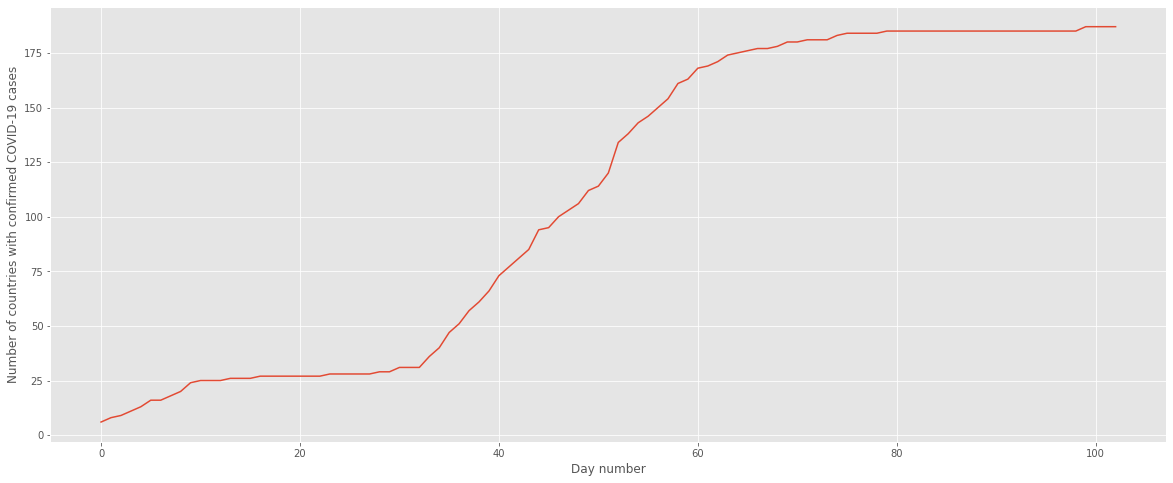

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), graph_data)
plt.ylabel('Number of countries with confirmed COVID-19 cases')
plt.xlabel("Day number")

plt.show()

#### 1.3 Визуализируйте мировые тренды по числу заболевших | погибших | выздоровивших. Постройте графики, которые отражают летальность от вируса в разных странах или на разных континентах. 

Есть несколько подходов, как считать летальность. Изначально это число погибших к общему числу умерших. Так как пандемия не закончена, то это число невозможно сосчитать. Можно посчитать только летальность среди завершенных случаев (deaths/(recovered+deaths)) и можно посчитать летальность среди всех подтвержденных случаев (deaths/confirmed). Обе оценки будут смещенными. Одна будет завышена, так как умирают обычно тяжелые пациенты на ранней стадии заболевания и из-за этого летальность, посчитанная по завершенным случаям на данный момент будет очень высокой. Но если считать как отношение смертей ко всем подтвержденным случаям, то летальность занижена, так как пациенты могут быть в тяжелом предсмертном состоянии, но при этом они пока живы. 
Я думаю, что среднее между этими величинами близко к реальному значению летальности.   


In [ ]:
df1_new = df.groupby(by=['Date','Country/Region']).agg(sum)
china = []
italy = []
for i in df.groupby(by=['Date']).agg(sum).index:
  china.append((i, 'China'))
  italy.append((i, 'Italy'))
df4_temp = df1_new.loc[china]
df5_temp = df1_new.loc[italy]

In [ ]:
# Для проверки метода возьмем Китай и Италию.
# Возьмем 2 оценки и среднюю
df4_temp['Deaths/Confirmed'] = df4_temp.Deaths/df4_temp.Confirmed
df4_temp['Deaths/Completed'] = df4_temp.Deaths/(df4_temp.Recovered + df4_temp.Deaths)
df4_temp['Mortality_estimation'] = (df4_temp['Deaths/Completed'] + df4_temp['Deaths/Confirmed'])/2

df5_temp['Deaths/Confirmed'] = df5_temp.Deaths/df5_temp.Confirmed
df5_temp['Deaths/Completed'] = df5_temp.Deaths/(df5_temp.Recovered + df5_temp.Deaths)
df5_temp['Mortality_estimation'] = (df5_temp['Deaths/Completed'] + df5_temp['Deaths/Confirmed'])/2

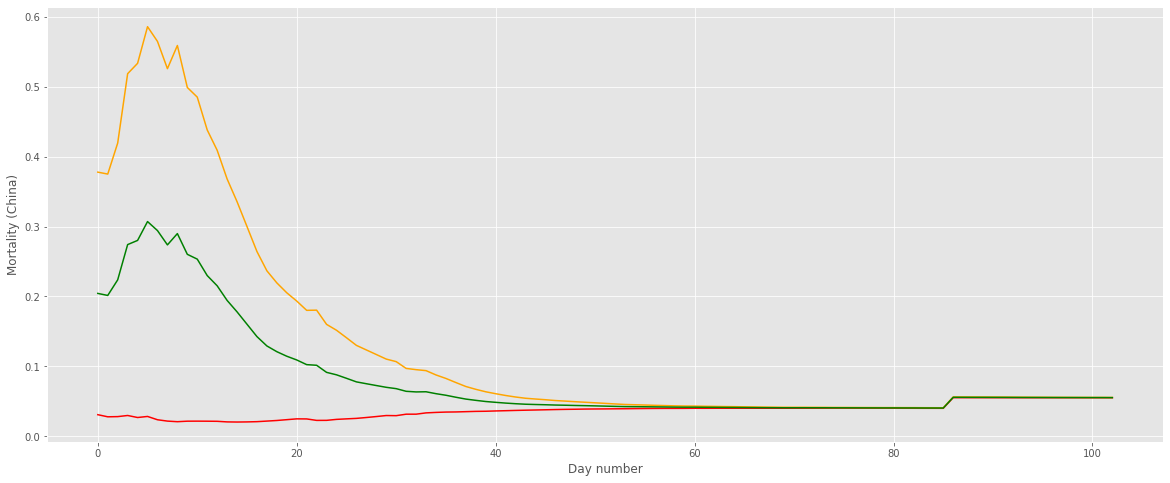

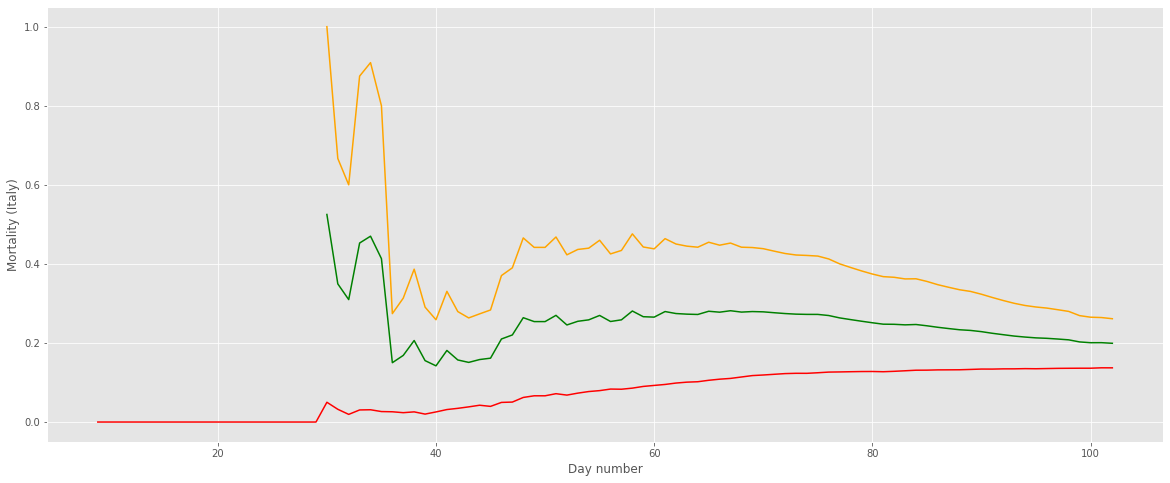

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), df4_temp['Deaths/Confirmed'].values, c = 'red')
plt.plot(np.arange(days), df4_temp['Deaths/Completed'].values, c = 'orange')
plt.plot(np.arange(days), df4_temp['Mortality_estimation'].values, c = 'green')
plt.ylabel('Mortality (China)')
plt.xlabel("Day number")

plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), df5_temp['Deaths/Confirmed'].values, c = 'red')
plt.plot(np.arange(days), df5_temp['Deaths/Completed'].values, c = 'orange')
plt.plot(np.arange(days), df5_temp['Mortality_estimation'].values, c = 'green')

plt.ylabel('Mortality (Italy)')
plt.xlabel("Day number")

plt.show()

plt.show()

Можно заметить, что оценка средним (зеленая линия) точнее, чем каждая из 2 других по отдельностей к реальному уровню смертности, который можно понять, когда красная и желтая линия сходятся. Это полезно, если в стране разгар заболевания, но необходимо понять летальность, которая будет в итоге. Таким образом, оценку средним я буду  использовать для всех стран, так как она точнее других или совпадает. 
Визуализацию по дням можно сделать при желании для любой страны. Но я взял те страны, где заболевание начаалось раньше других.

In [ ]:
# Completed = Deaths + Recovered
df1_temp['Deaths/Confirmed'] = df1_temp.Deaths/df1_temp.Confirmed
df1_temp['Deaths/Completed'] = df1_temp.Deaths/(df1_temp.Recovered + df1_temp.Deaths)
df1_temp['Mortality_estimation'] = (df1_temp['Deaths/Completed'] + df1_temp['Deaths/Confirmed'])/2


In [ ]:
# Некоторые страны не представляют данные по числу выздоровевших, где-то только начинается эпидемия. 
# В части стран пара случаев, которые по сути ни о чем не говорят в плане смертности
# Возьмем страны находящиеся в середине и в конце эпидемиологической траектории
# Возьмем страны, где хотя бы больше 1000 случаев
df1_temp_sample = df1_temp[(df1_temp['Deaths']/df2_temp['Recovered'] < 0.5) & (df2_temp['Confirmed'] > 1000)]
df1_temp_sorted = df1_temp_sample.sort_values('Mortality_estimation', ascending=False)

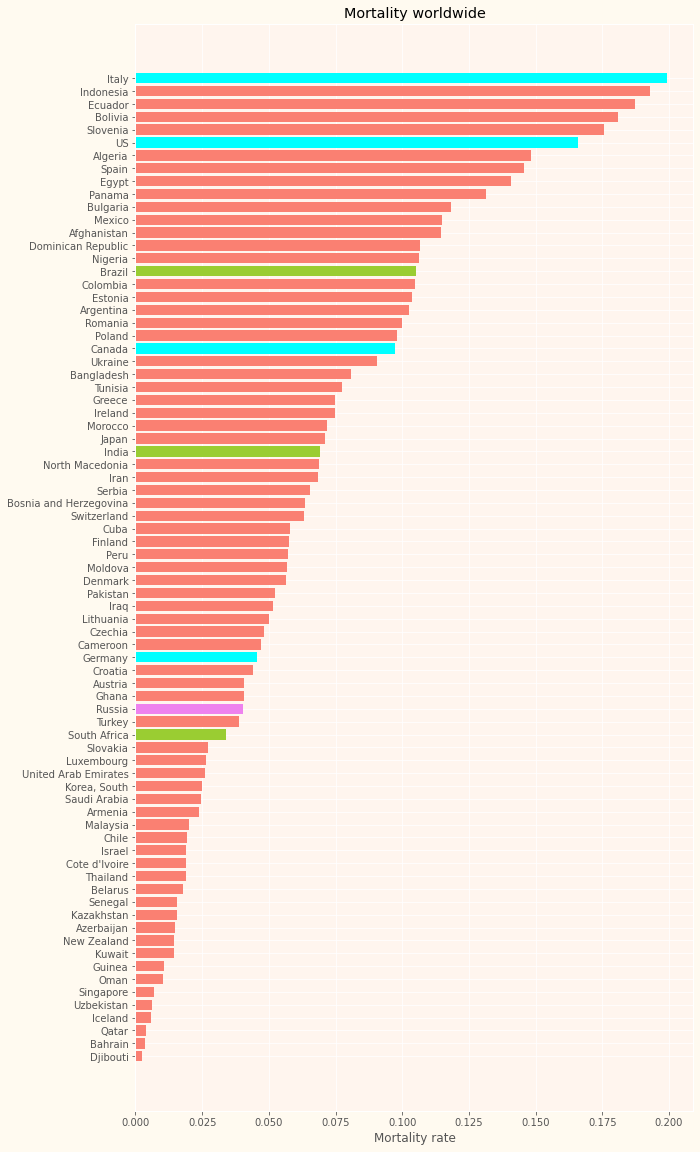

In [ ]:
fig, ax = plt.subplots()

performance = df1_temp_sorted['Mortality_estimation']
objects = df1_temp_sorted.index
y_pos = np.arange(len(objects))

color_list = []
g7_list = ['Italy', 'France', 'United Kingdom', 'US', 'China', 'Germany', 'Canada']
brics_list = ['South Africa', 'China', 'Brazil', 'India']
for i in objects:
  if i in g7_list:
    color_list.append('cyan')
  elif i in brics_list:
    color_list.append('yellowgreen')
  elif i=="Russia":
    color_list.append("violet")  
  else:
    color_list.append('salmon')

ax.barh(y_pos, performance, align='center', color = color_list)
ax.set_yticks(y_pos)
ax.set_yticklabels(objects)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Mortality rate')
ax.set_title("Mortality worldwide")

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(10)    #  ширина Figure
fig.set_figheight(20)    #  высота Figure
plt.show()

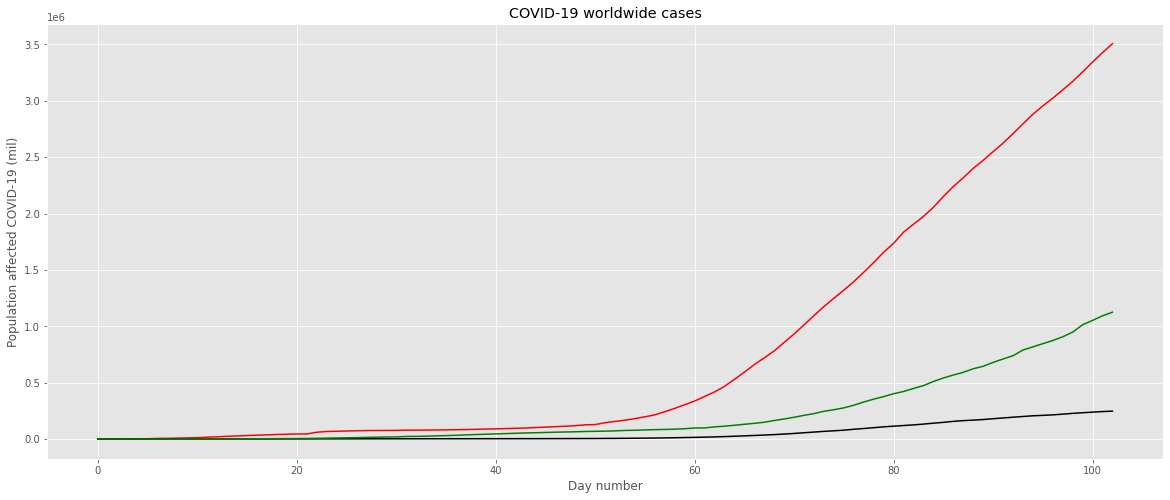

In [ ]:
df_world = df.groupby(by=['Date']).agg(sum)

gf_world = [1, 1]
for i in range(1, len(df_world)-1):
  gf_world.append((df_world.Confirmed.values[i+1]-df_world.Confirmed.values[i])/(df_world.Confirmed.values[i]-df_world.Confirmed.values[i-1]))
df_world['Growth_factor'] = gf_world

plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), df_world['Confirmed'].values, c = 'red')
plt.plot(np.arange(days), df_world['Deaths'].values, c = 'black')
plt.plot(np.arange(days), df_world['Recovered'].values, c = 'green')

plt.ylabel('Population affected COVID-19 (mil)')
plt.xlabel("Day number")
plt.title("COVID-19 worldwide cases")

plt.show()

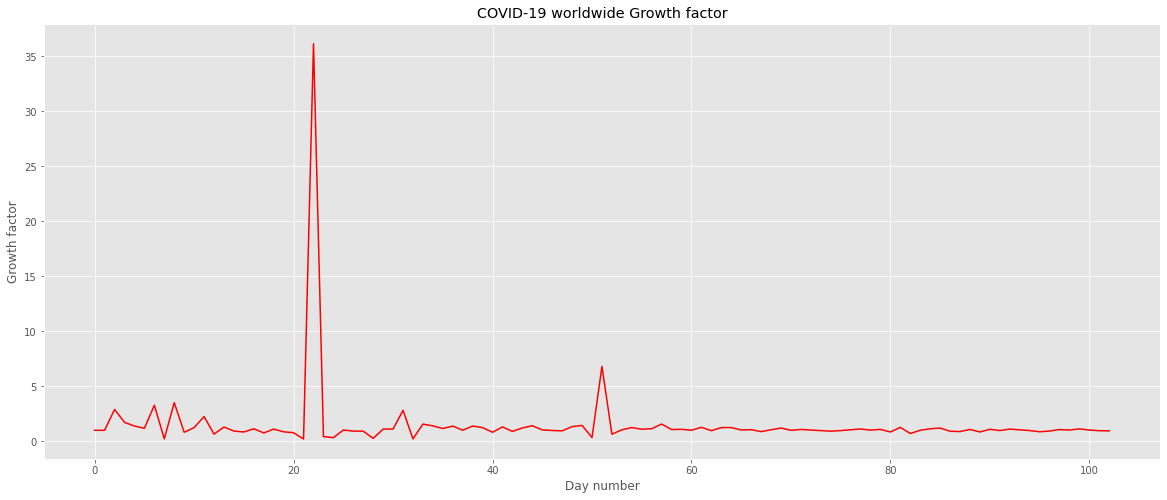

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), df_world['Growth_factor'].values, c = 'red')

plt.ylabel('Growth factor')
plt.xlabel("Day number")
plt.title("COVID-19 worldwide Growth factor")

plt.show()

Как мы видим на графике выброс в виде Growth-factor ~ 36 из-за того, что Китай сменил методику подсчета заболевших. Для того, чтобы данные оставались презентабельными я заменю значение в 36 на 7 (второе по величине значение) в целях визуализации


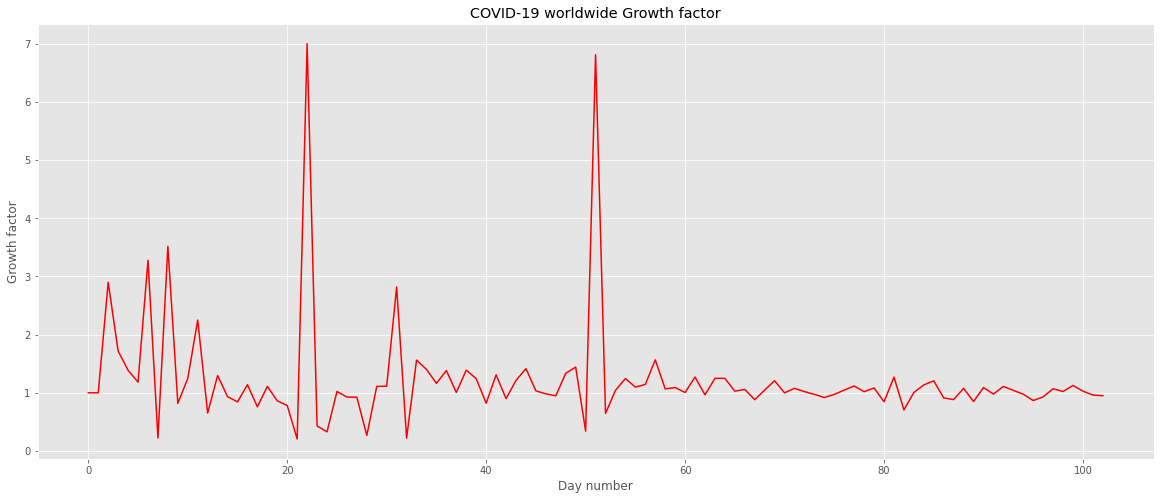

In [ ]:
gf_graph_data = df_world['Growth_factor'].values
gf_graph_data[22] = 7

plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), gf_graph_data, c = 'red')

plt.ylabel('Growth factor')
plt.xlabel("Day number")
plt.title("COVID-19 worldwide Growth factor")

plt.show()

Если growth factor > 1 стабильно, то значит с каждым днем заболевает больше, чем в прошлый день. Если в данных будет виден период, в течении которого growth factor < 1, то это признак окончания пандемии. Пока такого нет.

#### 1.4 Визуализируйте и сравните, как распространялась болезнь в разных странах или континентах по дням с первого зарегистрированного случая заболевания. Определите количество дней для каждой страны со дня первого зарегестрированного случая.

Добавим в датафрейм дату первого случая и его номер

In [ ]:
df6_temp = df.groupby(by = ['Country/Region', 'Date']).agg(sum)

In [ ]:
first_case_list = list(np.zeros(len(df.groupby(by = ['Country/Region']).agg(sum).values)))
df6_temp = df.groupby(by = ['Country/Region', 'Date']).agg(sum)

for country in range(len(df.groupby(by = ['Country/Region']).agg(sum).values)-1):
  for date in range(len(df.groupby(by = ['Date']).agg(sum).values)-1):
      if (df6_temp.iloc[country*days + date][2] < 1):
        first_case_list[country] = int(first_case_list[country]+int(1))
df1_temp['First_case_n'] = first_case_list

first_case_date = []

for i in first_case_list:
  first_case_date.append(df.groupby(by = ['Date']).agg(sum).index[i])
df1_temp['First_case_date'] = first_case_date

df1_temp['First_case_date'] = first_case_date
df1_temp['Days_since_first_case'] = days - df1_temp['First_case_n'] 
df1_temp.head(5) 


Lat  Long  ...  First_case_date  Days_since_first_case
Country/Region               ...                                        
Afghanistan     33.00 65.00  ...       2020-02-24                  70.00
Albania         41.15 20.17  ...       2020-03-09                  56.00
Algeria         28.03  1.66  ...       2020-02-25                  69.00
Andorra         42.51  1.52  ...       2020-03-02                  63.00
Angola         -11.20 17.87  ...       2020-03-20                  45.00

[5 rows x 11 columns]

In [ ]:
# Нарисуем карту, на которой изображены маркеры с информацией о названии страны, датой первого случая 
# и числом дней, которое прошло после первого случая. Для самых поздних стран цвет зеленый,
# для самых ранних зеленый. Оранжевый и желтый по такой же логике с окном 25 дней
map2 = folium.Map(location = [0, 0], 
                 zoom_start = 2, tiles = 'CartoDB dark_matter') 

In [ ]:
from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster().add_to(map2)

def color_change2(elev):
    if(elev < '2020-02-19'):
        return('red')
    elif('2020-02-19' <= elev <'2020-03-15'):
        return('orange')    
    elif('2020-03-15' <= elev <'2020-04-10'):
        return('yellow')
    else:
        return('green')

for i in range(len(df1_temp)):
    folium.CircleMarker(location = [df2_temp.Lat.values[i], df2_temp.Long.values[i]], 
                        tooltip = str(df2_temp.index[i]) + ',\n' +
                                str(df1_temp['First_case_date'].values[i]) + ',\n' + str(int(df1_temp['Days_since_first_case'].values[i])) + ' days',
                        fill_color = color_change2(df1_temp['First_case_date'].values[i]),
                        tiles="Mapbox Bright",
                        radius = 15,
                        color = "gray",

                        fill_opacity = 0.9).add_to(marker_cluster)
map2

#### 1.5 Визуализируйте и оцените как развивалась ситуация в России по сравнению с остальными миром.

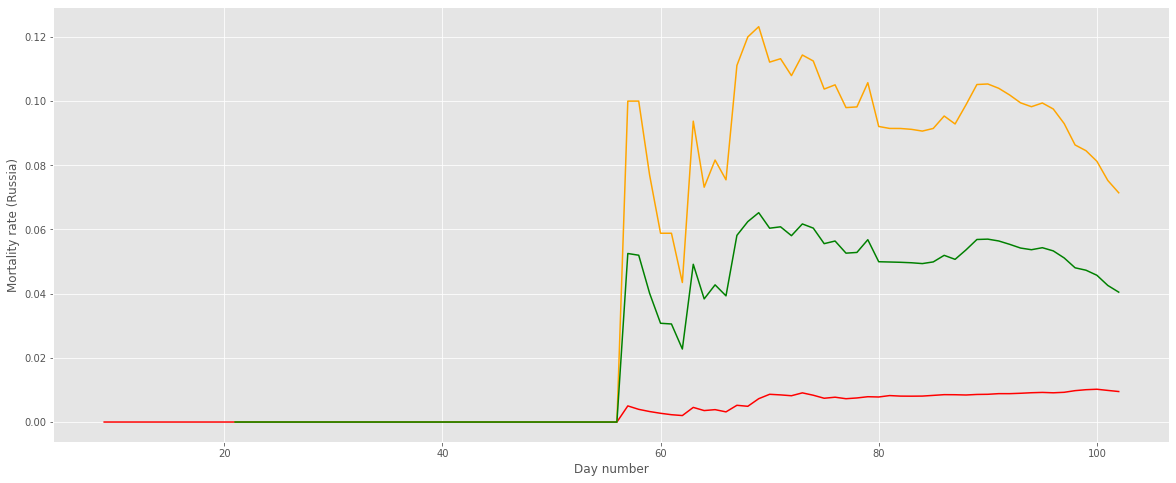

In [ ]:
df1_new = df.groupby(by=['Date','Country/Region']).agg(sum)
russia = []
for i in df.groupby(by=['Date']).agg(sum).index:
  russia.append((i, 'Russia'))
df_russia = df1_new.loc[russia]

df_russia['Deaths/Confirmed'] = df_russia.Deaths/df_russia.Confirmed
df_russia['Deaths/Completed'] = df_russia.Deaths/(df_russia.Recovered + df_russia.Deaths)
df_russia['Mortality_estimation'] = (df_russia['Deaths/Completed'] + df_russia['Deaths/Confirmed'])/2

plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), df_russia['Deaths/Confirmed'].values, c = 'red')
plt.plot(np.arange(days), df_russia['Deaths/Completed'].values, c = 'orange')
plt.plot(np.arange(days), df_russia['Mortality_estimation'].values, c = 'green')
plt.ylabel('Mortality rate (Russia)')
plt.xlabel("Day number")

plt.show()

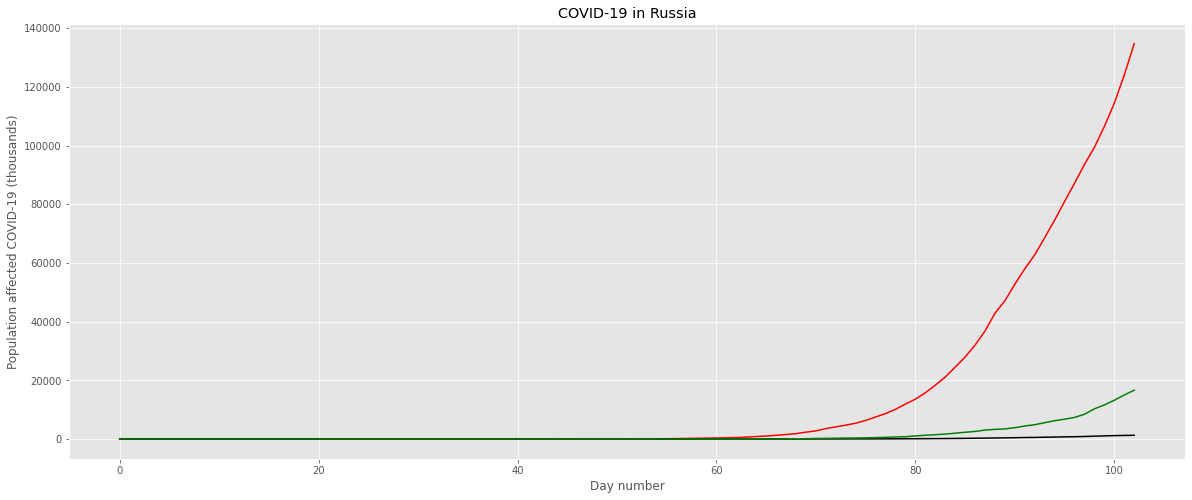

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), df_russia['Confirmed'].values, c = 'red')
plt.plot(np.arange(days), df_russia['Deaths'].values, c = 'black')
plt.plot(np.arange(days), df_russia['Recovered'].values, c = 'green')

plt.ylabel('Population affected COVID-19 (thousands)')
plt.xlabel("Day number")
plt.title("COVID-19 in Russia")

plt.show()

Пока каждый день заболевает в разы больше, чем выздоравливает.

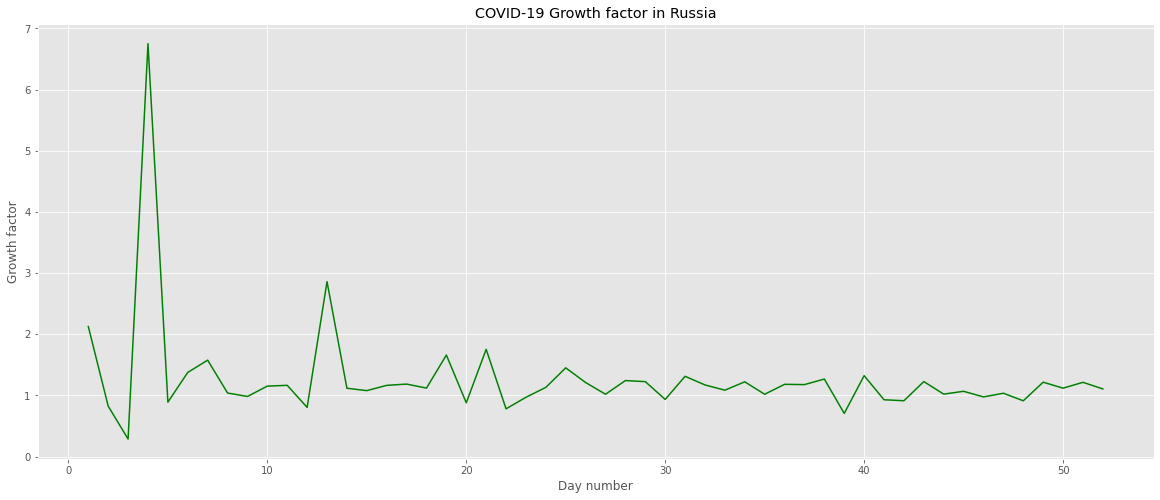

In [ ]:
gf_russia = [1, 1]
for i in range(1, len(df_russia)-1):
  gf_russia.append((df_russia.Confirmed.values[i+1] - df_russia.Confirmed.values[i])/(df_russia.Confirmed.values[i]-df_russia.Confirmed.values[i-1]))
df_russia['Growth_factor'] = gf_russia

plt.figure(figsize=(20, 8))
plt.plot(np.arange(days-50), df_russia['Growth_factor'].values[50:], c = 'green')

plt.ylabel('Growth factor')
plt.xlabel("Day number")
plt.title("COVID-19 Growth factor in Russia")

plt.show()

In [ ]:
df_china = df4_temp
df_italy = df5_temp

In [ ]:
uk = []
iran = []
for i in df.groupby(by=['Date']).agg(sum).index:
  uk.append((i, 'United Kingdom'))
  iran.append((i, 'Iran'))
df_uk = df1_new.loc[uk]
df_iran = df1_new.loc[iran]

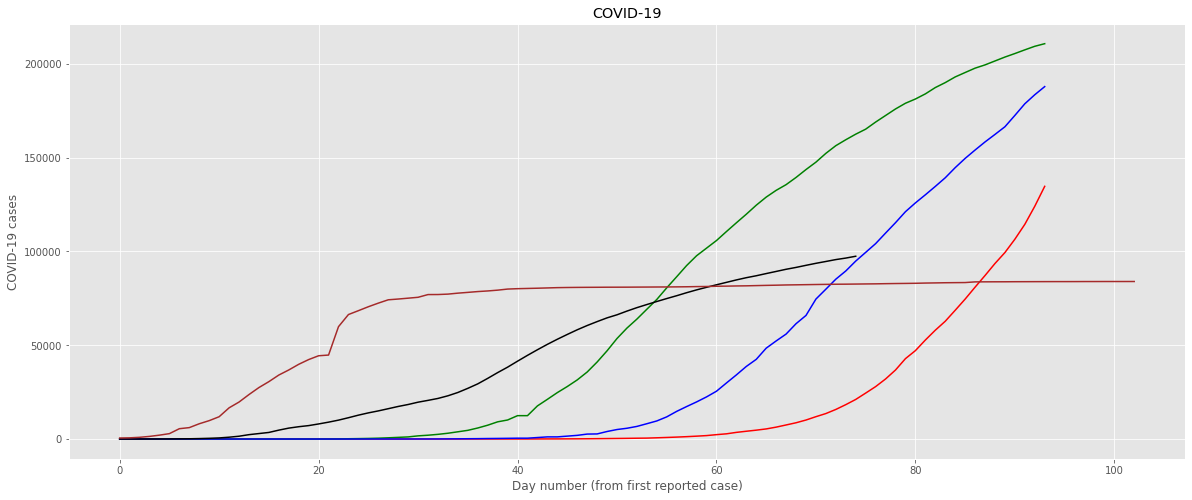

In [ ]:
# Сравним динамику в Китая, Италии, США, России, Иране с момента 1 случая

plt.figure(figsize=(20, 8))
plt.plot(np.arange(df1_temp.Days_since_first_case['Russia']), df_russia.Confirmed[int(df1_temp.First_case_n['Russia']):], c = 'red')
plt.plot(np.arange(df1_temp.Days_since_first_case['Italy']), df_italy.Confirmed[int(df1_temp.First_case_n['Italy']):], c = 'green')
plt.plot(np.arange(df1_temp.Days_since_first_case['United Kingdom']), df_uk.Confirmed[int(df1_temp.First_case_n['United Kingdom']):], c = 'blue')
plt.plot(np.arange(df1_temp.Days_since_first_case['Iran']), df_iran.Confirmed[int(df1_temp.First_case_n['Iran']):], c = 'black')
plt.plot(np.arange(df1_temp.Days_since_first_case['China']), df_china.Confirmed[int(df1_temp.First_case_n['China']):], c = 'brown')

plt.ylabel('COVID-19 cases')
plt.xlabel("Day number (from first reported case)")
plt.title("COVID-19")

plt.show()

 По графикам видно, что РФ долго успешно не давала инфекции распространится, так как в активный рост начался только спустя 2 месяца после 1 случая. Кроме этого число смертей очень низкое. Но с другой стороны, в Италии наблюдается стадия замедления заболевания, в то время как в России наблюдается стадия бурного роста заболевания. В Иране также темпы росты значительно замедлились. В Китае эпидемия окончена.

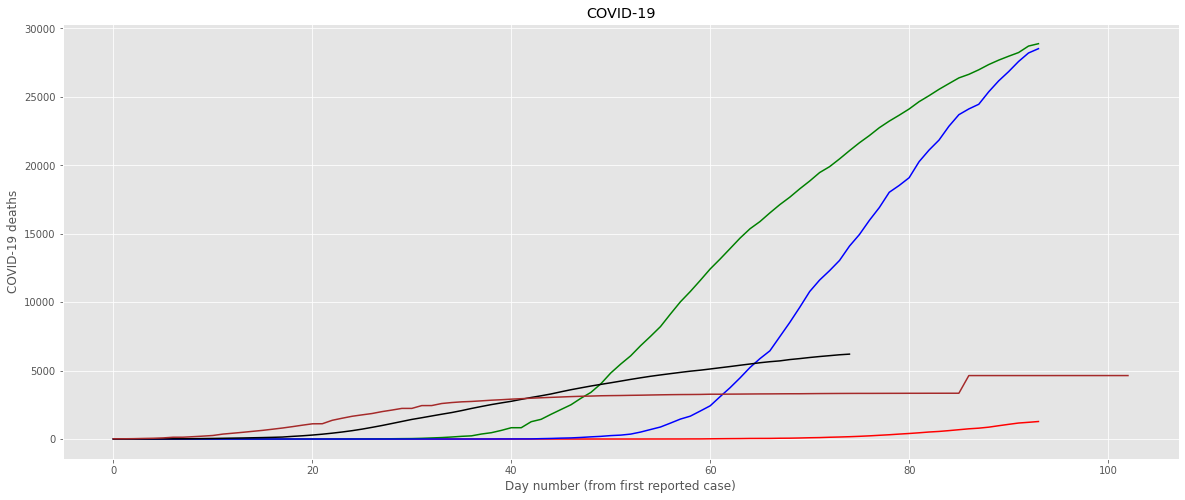

In [ ]:
# Дополнительно нанесем на график еще 5 стран, которых нет в прошлом пункте

plt.figure(figsize=(20, 8))
plt.plot(np.arange(df1_temp.Days_since_first_case['Russia']), df_russia.Deaths[int(df1_temp.First_case_n['Russia']):], c = 'red')
plt.plot(np.arange(df1_temp.Days_since_first_case['Italy']), df_italy.Deaths[int(df1_temp.First_case_n['Italy']):], c = 'green')
plt.plot(np.arange(df1_temp.Days_since_first_case['United Kingdom']), df_uk.Deaths[int(df1_temp.First_case_n['United Kingdom']):], c = 'blue')
plt.plot(np.arange(df1_temp.Days_since_first_case['Iran']), df_iran.Deaths[int(df1_temp.First_case_n['Iran']):], c = 'black')
plt.plot(np.arange(df1_temp.Days_since_first_case['China']), df_china.Deaths[int(df1_temp.First_case_n['China']):], c = 'brown')

plt.ylabel('COVID-19 deaths')
plt.xlabel("Day number (from first reported case)")
plt.title("COVID-19")

plt.show()

На графике смертей Россия положительно отличилась, так как число смертей в наименьшее при разнице в числе случаев не больше, чем в 2 раза. Число смертей отличается в десятки раз с Италией и Великобританией, и раза в 2-3 с Китаем при большем числе случаев.

#### 1.6 Определите топ-10 стран, которые лидируют по имеющимся в датасете показателям. Сравните насколько быстро развивается ситуация в этих странах, определите корреляцию.

* На координаты не смотреть. Они неверные в данном датафрейме.
 

In [ ]:
# Лидеры по количеству, выявленных случаев
df1_temp.sort_values('Confirmed', ascending=False)[:10]

Lat   Long  ...  First_case_date  Days_since_first_case
Country/Region                ...                                        
US              37.09 -95.71  ...       2020-01-22                 103.00
Spain           40.00  -4.00  ...       2020-02-01                  93.00
Italy           43.00  12.00  ...       2020-01-31                  94.00
United Kingdom 609.16 -37.80  ...       2020-01-31                  94.00
France         508.50  24.35  ...       2020-01-24                 101.00
Germany         51.00   9.00  ...       2020-01-27                  98.00
Russia          60.00  90.00  ...       2020-01-31                  94.00
Turkey          38.96  35.24  ...       2020-03-11                  54.00
Brazil         -14.23 -51.93  ...       2020-02-26                  68.00
Iran            32.00  53.00  ...       2020-02-19                  75.00

[10 rows x 11 columns]

In [ ]:
# Лидеры по числу выздоровевших
df1_temp.sort_values('Recovered', ascending=False)[:10]

Lat     Long  ...  First_case_date  Days_since_first_case
Country/Region                   ...                                        
US               37.09   -95.71  ...       2020-01-22                 103.00
Germany          51.00     9.00  ...       2020-01-27                  98.00
Spain            40.00    -4.00  ...       2020-02-01                  93.00
Italy            43.00    12.00  ...       2020-01-31                  94.00
China          1083.34  3684.42  ...       2020-01-22                 103.00
Iran             32.00    53.00  ...       2020-02-19                  75.00
Turkey           38.96    35.24  ...       2020-03-11                  54.00
France          508.50    24.35  ...       2020-01-24                 101.00
Brazil          -14.23   -51.93  ...       2020-02-26                  68.00
Canada          727.89 -1343.98  ...       2020-01-26                  99.00

[10 rows x 11 columns]

In [ ]:
# Лидеры по числу смертей
df1_temp.sort_values('Deaths', ascending=False)[:10]

Lat   Long  ...  First_case_date  Days_since_first_case
Country/Region                ...                                        
US              37.09 -95.71  ...       2020-01-22                 103.00
Italy           43.00  12.00  ...       2020-01-31                  94.00
United Kingdom 609.16 -37.80  ...       2020-01-31                  94.00
Spain           40.00  -4.00  ...       2020-02-01                  93.00
France         508.50  24.35  ...       2020-01-24                 101.00
Belgium         50.83   4.00  ...       2020-02-04                  90.00
Brazil         -14.23 -51.93  ...       2020-02-26                  68.00
Germany         51.00   9.00  ...       2020-01-27                  98.00
Iran            32.00  53.00  ...       2020-02-19                  75.00
Netherlands    260.66  26.46  ...       2020-02-27                  67.00

[10 rows x 11 columns]

In [ ]:
spain = []
france = []
us = []
germany = []
turkey = []
brazil = []
for i in df.groupby(by=['Date']).agg(sum).index:
  spain.append((i, 'Spain'))
  france.append((i, 'France'))
  us.append((i, "US"))
  germany.append((i, 'Germany'))
  turkey.append((i, 'Turkey'))
  brazil.append((i, 'Brazil'))
df_spain = df1_new.loc[spain]
df_france = df1_new.loc[france]
df_us = df1_new.loc[us]
df_germany = df1_new.loc[germany]
df_turkey = df1_new.loc[turkey]
df_brazil = df1_new.loc[brazil]

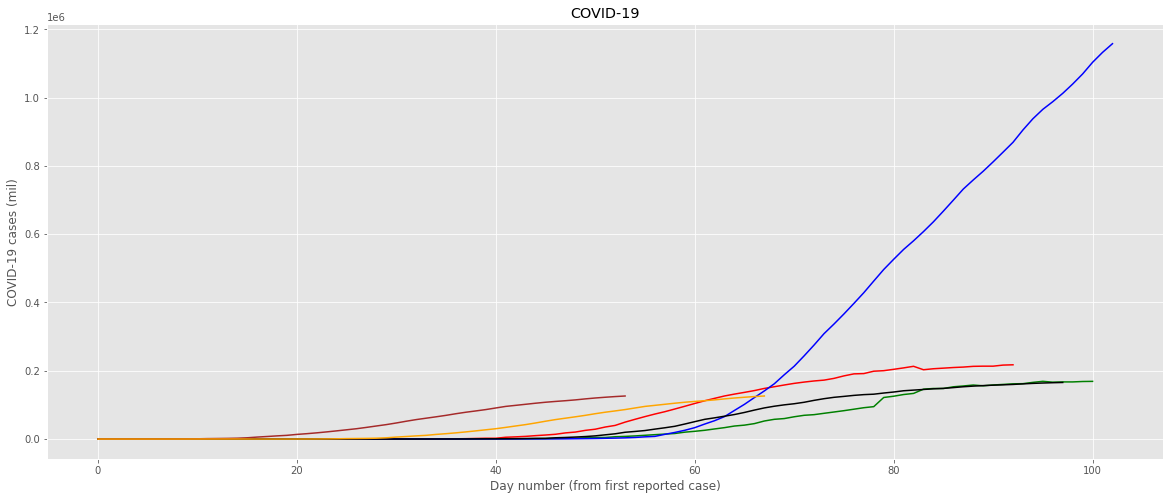

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(np.arange(df1_temp.Days_since_first_case['Spain']), df_spain.Confirmed[int(df1_temp.First_case_n['Spain']):], c = 'red')
plt.plot(np.arange(df1_temp.Days_since_first_case['France']), df_france.Confirmed[int(df1_temp.First_case_n['France']):], c = 'green')
plt.plot(np.arange(df1_temp.Days_since_first_case['US']), df_us.Confirmed[int(df1_temp.First_case_n['US']):], c = 'blue')
plt.plot(np.arange(df1_temp.Days_since_first_case['Germany']), df_germany.Confirmed[int(df1_temp.First_case_n['Germany']):], c = 'black')
plt.plot(np.arange(df1_temp.Days_since_first_case['Turkey']), df_turkey.Confirmed[int(df1_temp.First_case_n['Turkey']):], c = 'brown')
plt.plot(np.arange(df1_temp.Days_since_first_case['Brazil']), df_turkey.Confirmed[int(df1_temp.First_case_n['Brazil']):], c = 'orange')

plt.ylabel('COVID-19 cases (mil)')
plt.xlabel("Day number (from first reported case)")
plt.title("COVID-19")

plt.show()

Отличается только динамика США от остальных. С другой стороны, население приблизительно во столько же раз больше. У других 4 стран приблизительно похожее население.

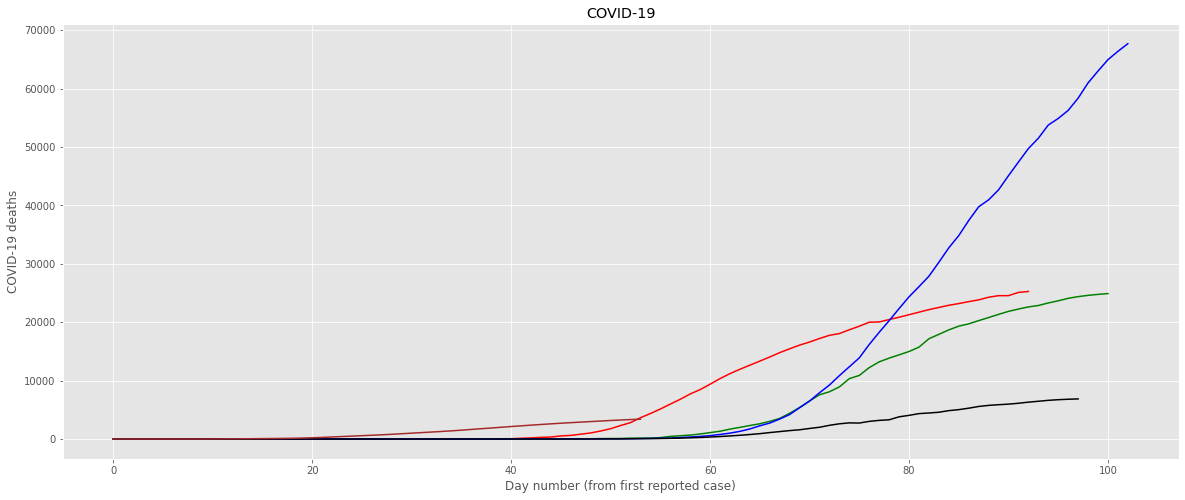

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(np.arange(df1_temp.Days_since_first_case['Spain']), df_spain.Deaths[int(df1_temp.First_case_n['Spain']):], c = 'red')
plt.plot(np.arange(df1_temp.Days_since_first_case['France']), df_france.Deaths[int(df1_temp.First_case_n['France']):], c = 'green')
plt.plot(np.arange(df1_temp.Days_since_first_case['US']), df_us.Deaths[int(df1_temp.First_case_n['US']):], c = 'blue')
plt.plot(np.arange(df1_temp.Days_since_first_case['Germany']), df_germany.Deaths[int(df1_temp.First_case_n['Germany']):], c = 'black')
plt.plot(np.arange(df1_temp.Days_since_first_case['Turkey']), df_turkey.Deaths[int(df1_temp.First_case_n['Turkey']):], c = 'brown')

plt.ylabel('COVID-19 deaths')
plt.xlabel("Day number (from first reported case)")
plt.title("COVID-19")

plt.show()

В числе смертей есть различия. Динамика США, Испании, Франции похожая, при этом в Турции и в Германии число смертей значительно меньше. 

1.7 Для первых 5 стран из топ-10 и России постойте сравнительные графики. Изучите как изменялись значения отношений погибших/выздоровивших, погибших/заболевших, заболевших/общее число жителей, ваш вариант...

In [ ]:
pd.options.display.max_rows = 20

Графики буду строить для США, Италии, Испании, Франции, Великобритании

In [ ]:
# Показатели посчтианы для первых 10 стран и Китая, поэтому при желании можно сравнить их на графиках
dfs_list = [df_china, df_russia, df_italy, df_france, df_germany, df_iran, df_turkey, df_spain, df_uk, df_us, df_brazil]
population = [1439323776, 145934462, 60461826, 65273511, 83783942, 83992949, 84339067, 46754778, 67886011, 331002651, 212559417]
for dfs in dfs_list:
  dfs['Deaths/Confirmed'] = dfs.Deaths/dfs.Confirmed
  dfs['Deaths/Completed'] = dfs.Deaths/(dfs.Recovered + dfs.Deaths)
  dfs['Mortality_estimation'] = (dfs['Deaths/Completed'] + dfs['Deaths/Confirmed'])/2
  dfs['Deaths/Recovered'] = dfs.Deaths/(dfs.Recovered)
  dfs['Date'] = df["Date"].unique()
  dfs['TimeIndex'] = np.arange(days)
for i in range(len(dfs_list)):  
  dfs_list[i]['Cases/Population(%)'] = dfs_list[i].Confirmed/population[i]*100
  dfs_list[i]['Deaths/Population(%)'] = dfs_list[i].Deaths/population[i]*100
  

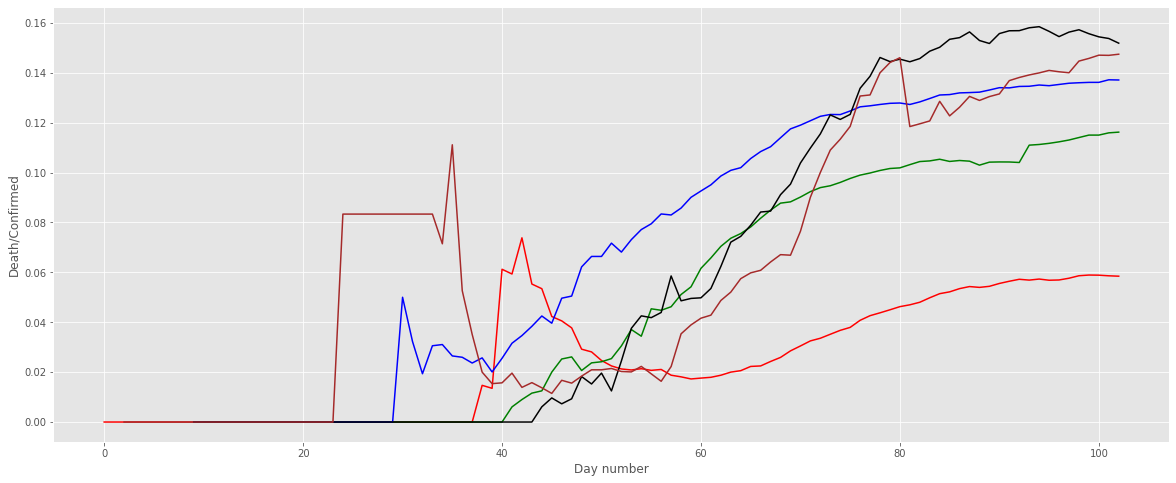

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), df_us['Deaths/Confirmed'].values, c ='red')
plt.plot(np.arange(days), df_spain['Deaths/Confirmed'].values, c ='green')
plt.plot(np.arange(days), df_italy['Deaths/Confirmed'].values, c ='blue')
plt.plot(np.arange(days), df_uk['Deaths/Confirmed'].values, c ='black')
plt.plot(np.arange(days), df_france['Deaths/Confirmed'].values, c ='brown')
plt.ylabel('Death/Confirmed')
plt.xlabel("Day number")

plt.show()

Смерти к числу выявленных случаев можно интепретировать как эффективность медицинской системы. Чем ниже, тем она выше. Но недостаток этого отношения это разница в числе тестов, так как чем их больше, тем больше выявляется бессимптомных больных, которые не умрут и соответственно снизят это отношение.

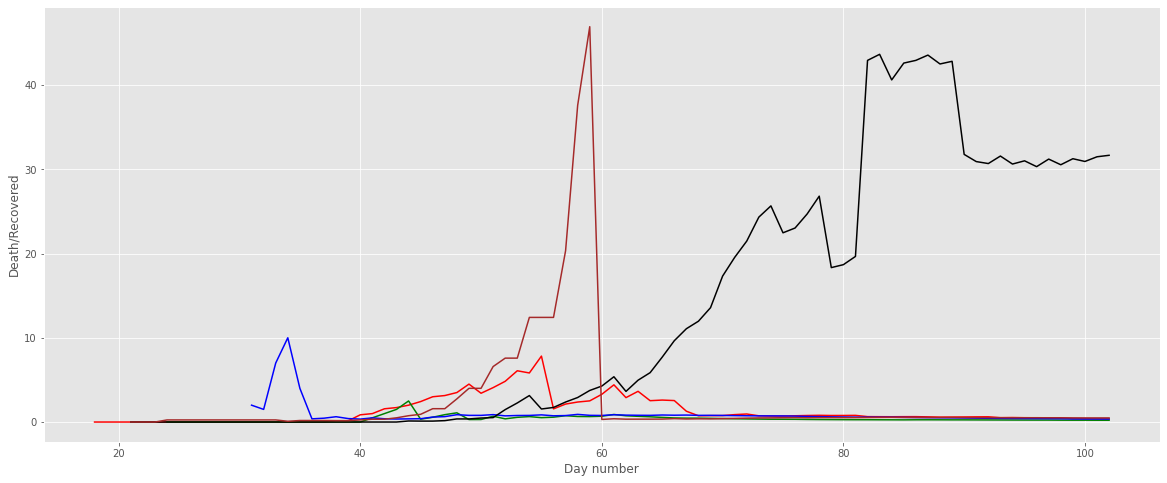

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), df_us['Deaths/Recovered'].values, c ='red')
plt.plot(np.arange(days), df_spain['Deaths/Recovered'].values, c ='green')
plt.plot(np.arange(days), df_italy['Deaths/Recovered'].values, c ='blue')
plt.plot(np.arange(days), df_uk['Deaths/Recovered'].values, c ='black')
plt.plot(np.arange(days), df_france['Deaths/Recovered'].values, c ='brown')
plt.ylabel('Death/Recovered')
plt.xlabel("Day number")

plt.show()

График Deaths/Recovered мало что показывает. По идее его идея похожа на mortality, но качественно это число сложно интерпретировать.

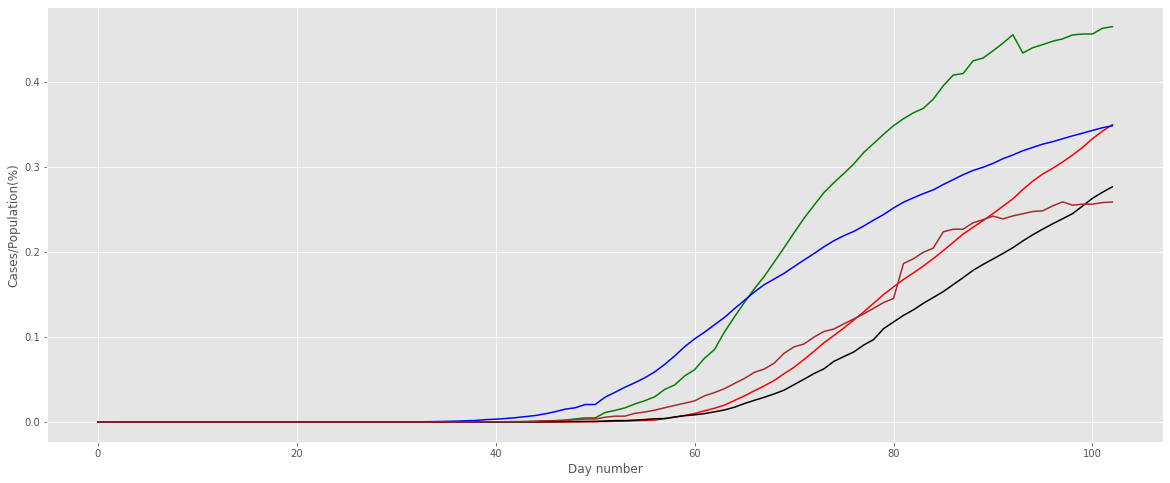

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), df_us['Cases/Population(%)'].values, c ='red')
plt.plot(np.arange(days), df_spain['Cases/Population(%)'].values, c ='green')
plt.plot(np.arange(days), df_italy['Cases/Population(%)'].values, c ='blue')
plt.plot(np.arange(days), df_uk['Cases/Population(%)'].values, c ='black')
plt.plot(np.arange(days), df_france['Cases/Population(%)'].values, c ='brown')
plt.ylabel('Cases/Population(%)')
plt.xlabel("Day number")

plt.show()

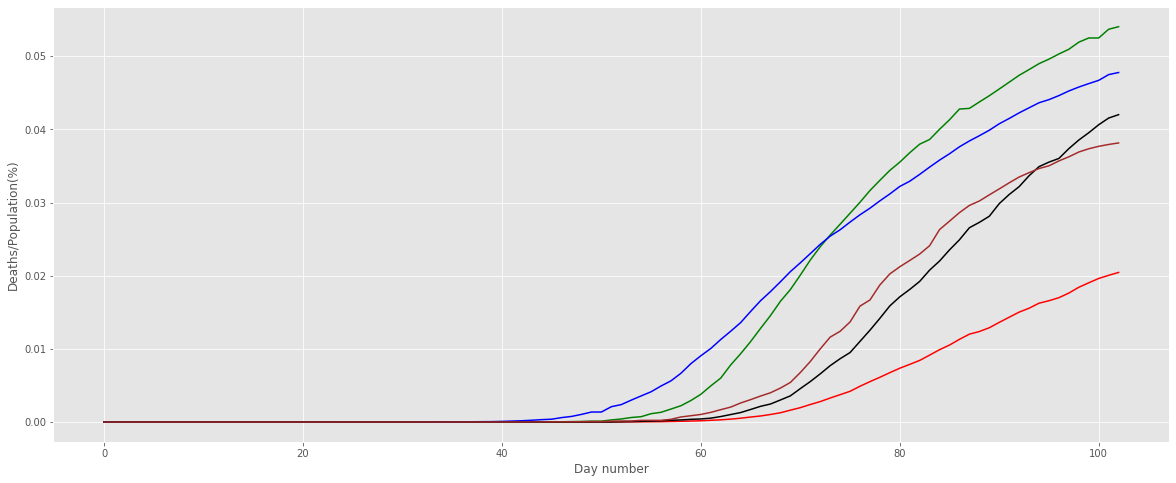

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), df_us['Deaths/Population(%)'].values, c ='red')
plt.plot(np.arange(days), df_spain['Deaths/Population(%)'].values, c ='green')
plt.plot(np.arange(days), df_italy['Deaths/Population(%)'].values, c ='blue')
plt.plot(np.arange(days), df_uk['Deaths/Population(%)'].values, c ='black')
plt.plot(np.arange(days), df_france['Deaths/Population(%)'].values, c ='brown')
plt.ylabel('Deaths/Population(%)')
plt.xlabel("Day number")

plt.show()

Когда мы смотрим на графики на душу населения то мы видим, что самая худшая ситуация оказывается в Испании и в Италии, а не в США. Смерти на душу населения в США в несколько раз ниже, чем у других стран, при наибольшем абсолютном числе смертей. С числом случаев аналогичная история.

1.8 Выделите временной ряд по одному из целевых признаков. Для выделенного временного ряда:
  - Представьте временной ряд в виде последовательности разницы между значениями. Рассчитайте лаги, выведите их на графике.
  - Попробуйте декомпозировать временной ряд. Постройте график тренда.
  - Что вы можете сказать о стационарности временного ряда? 

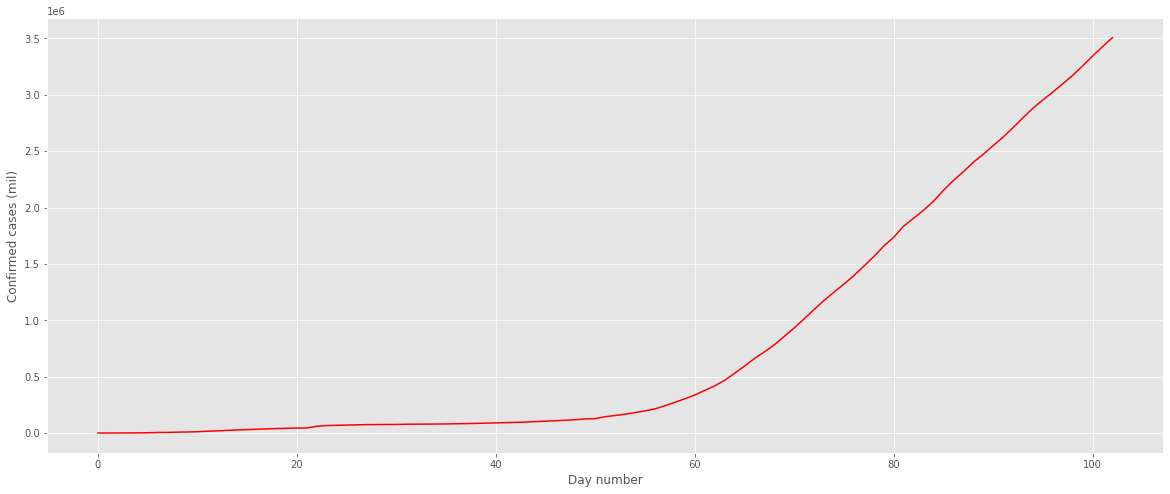

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), df_world['Confirmed'].values, c ='red')

plt.ylabel('Confirmed cases (mil)')
plt.xlabel("Day number")

plt.show()

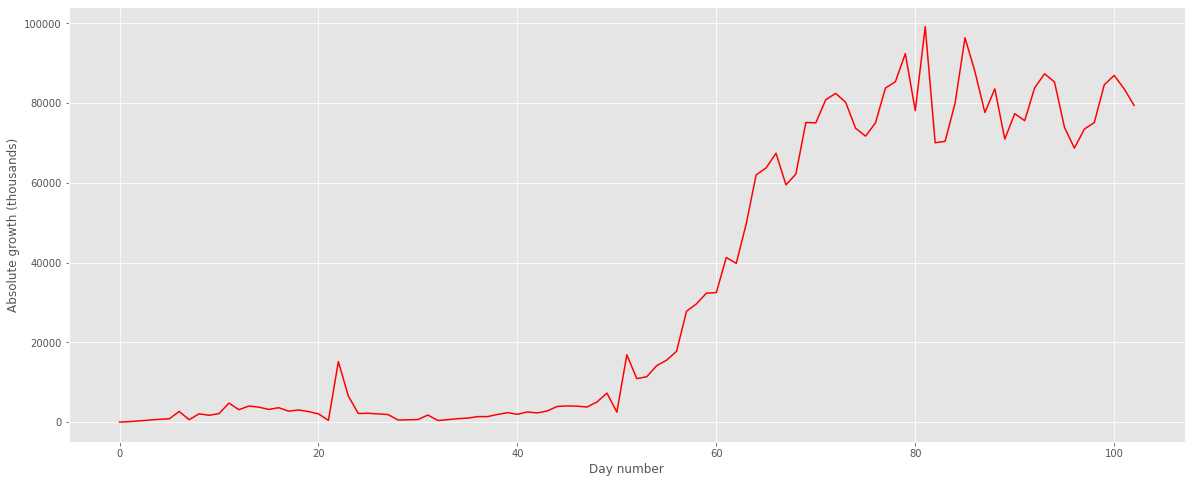

In [ ]:
conf_diff = [0]
for i in range(days-1):
  conf_diff.append(df_world.Confirmed.values[i+1]-df_world.Confirmed.values[i])
df_world["Growth_abs"] = conf_diff

plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), df_world['Growth_abs'].values, c ='red')

plt.ylabel('Absolute growth (thousands)')
plt.xlabel("Day number")

plt.show()

Визуально оба ряда не стационарные, но для подтверждения своего наблюдения необходимо провести обобщенный тест Дикки-Фуллера на наличие единичных корней.

In [ ]:
# Тест на стационарность для общего числа выявленных случаев

test = sma.tsa.adfuller(df_world.Confirmed.values)
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен')
else:
    print ('Единичных корней нет, ряд стационарен')

adf:  2.5411950167283734
p-value:  0.9990619417104006
Critical values:  {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
Есть единичные корни, ряд не стационарен


In [ ]:
# Тест на стационаррность для ежедневного прироста случаев (лагов первого порядка)

test_lags = sma.tsa.adfuller(df_world.Growth_abs.values)
print ('adf: ', test_lags[0]) 
print ('p-value: ', test_lags[1])
print('Critical values: ', test[4])
if test_lags[0]> test_lags[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен')
else:
    print ('Единичных корней нет, ряд стационарен')

adf:  -0.9793252494572253
p-value:  0.7607300603233407
Critical values:  {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
Есть единичные корни, ряд не стационарен


Сам ряд не стационарен. Ряд из лагов также не стационарный. Но для использования ARIMA нам необходимо найти порядок лага, который будет стационарен, чтоб передать его как d.

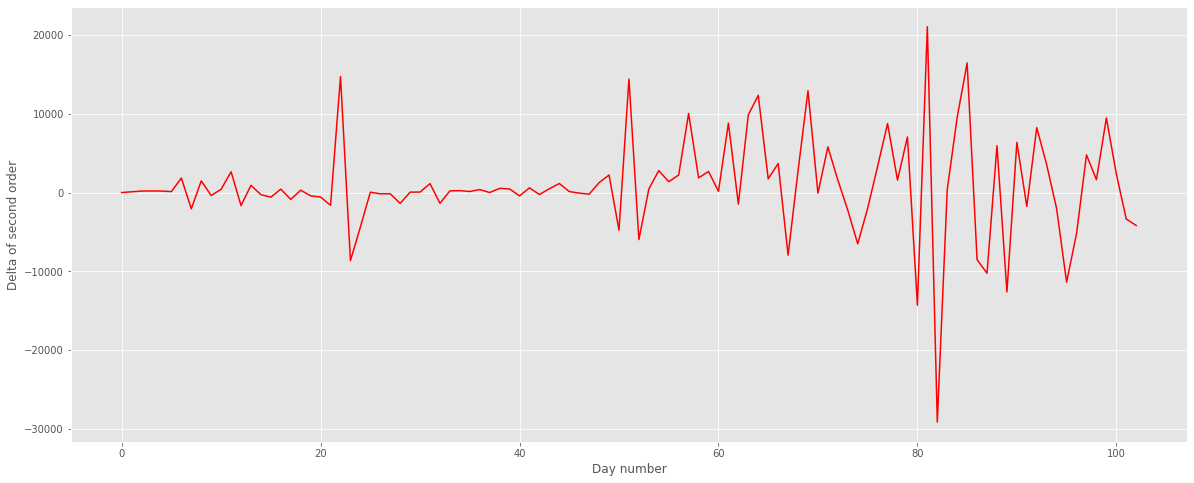

In [ ]:
conf_diff_2 = [0]
for i in range(days-1):
  conf_diff_2.append(df_world.Growth_abs.values[i+1]-df_world.Growth_abs.values[i])
df_world["Delta_2"] = conf_diff_2

plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), df_world['Delta_2'].values, c ='red')

plt.ylabel('Delta of second order')
plt.xlabel("Day number")

plt.show()

In [ ]:
# Тест на стационаррность для ежедневного прироста случаев (лагов первого порядка)

test_lags = sma.tsa.adfuller(df_world.Delta_2.values)
print ('adf: ', test_lags[0]) 
print ('p-value: ', test_lags[1])
print('Critical values: ', test[4])
if test_lags[0]> test_lags[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен')
else:
    print ('Единичных корней нет, ряд стационарен')

adf:  -2.1592099216640706
p-value:  0.22138142317493453
Critical values:  {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
Есть единичные корни, ряд не стационарен


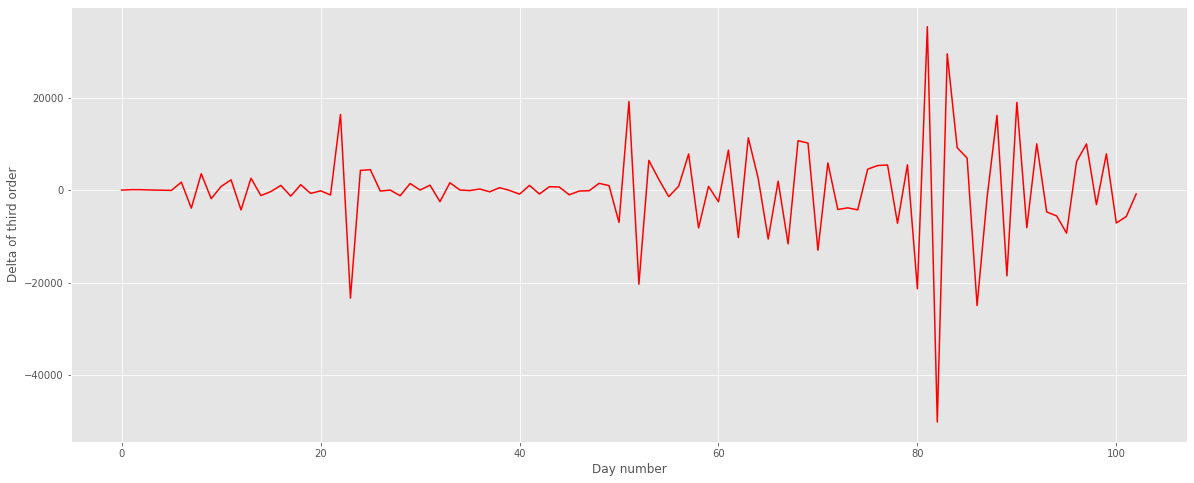

In [ ]:
conf_diff_3 = [0]
for i in range(days-1):
  conf_diff_3.append(df_world.Delta_2.values[i+1]-df_world.Delta_2.values[i])
df_world["Delta_3"] = conf_diff_3

plt.figure(figsize=(20, 8))
plt.plot(np.arange(days), df_world['Delta_3'].values, c ='red')

plt.ylabel('Delta of third order')
plt.xlabel("Day number")

plt.show()

In [ ]:
# Тест на стационарность для ежедневного прироста случаев (разности первого порядка)

test_lags = sma.tsa.adfuller(df_world.Delta_3.values)
print ('adf: ', test_lags[0]) 
print ('p-value: ', test_lags[1])
print('Critical values: ', test[4])
if test_lags[0]> test_lags[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен')
else:
    print ('Единичных корней нет, ряд стационарен')

adf:  -4.61445465916859
p-value:  0.00012147327321257697
Critical values:  {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
Единичных корней нет, ряд стационарен


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
df_world.Date = pd.DatetimeIndex(df.Date)
df_world.head(3)

Lat    Long  Confirmed  ...  Growth_abs  Delta_2  Delta_3
Date                                   ...                              
2020-01-22 5711.12 5860.70     555.00  ...        0.00     0.00     0.00
2020-01-23 5711.12 5860.70     654.00  ...       99.00    99.00    99.00
2020-01-24 5711.12 5860.70     941.00  ...      287.00   188.00    89.00

[3 rows x 9 columns]

In [ ]:
df_world.index = pd.PeriodIndex(df_world.Date[:days], freq='D')

In [ ]:
df_world.index = df_world.index.to_timestamp()

In [ ]:
decomposition = seasonal_decompose(df_world.Confirmed, model = "additive")
decomposition_lags = seasonal_decompose(df_world.Growth_abs, model = "additive")

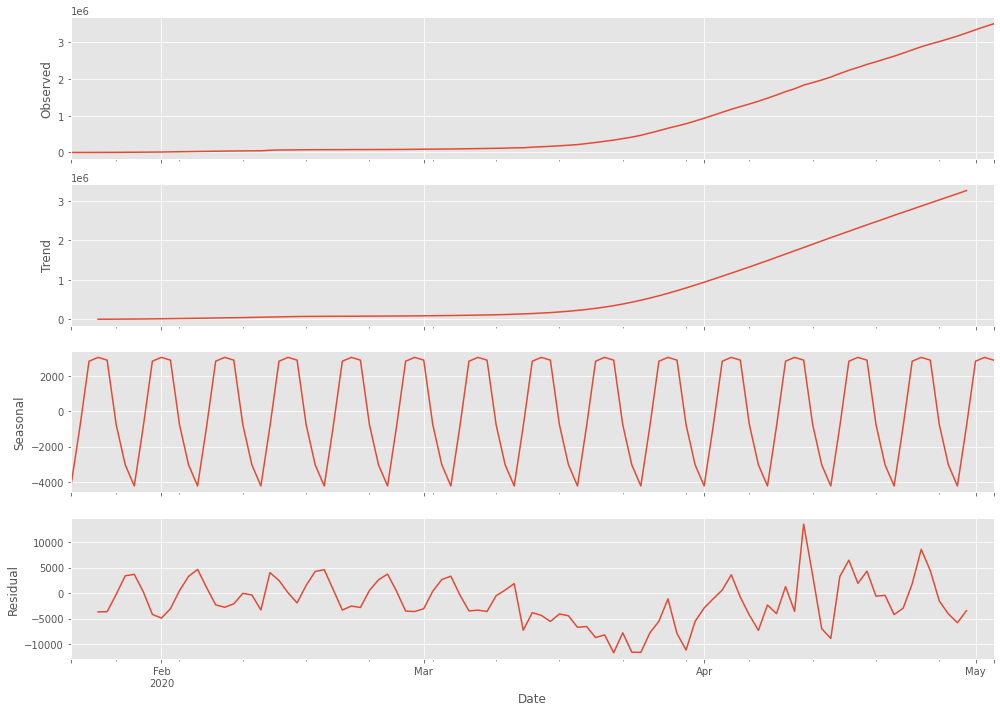

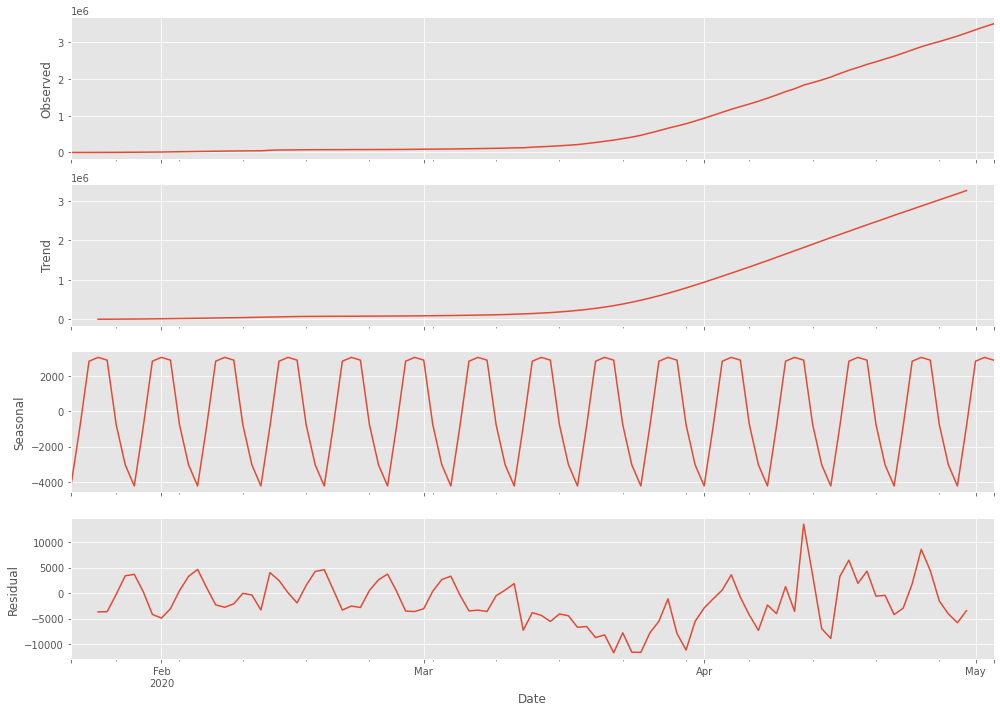

In [ ]:
import pylab
pylab.rcParams['figure.figsize'] = (14, 10)
decomposition.plot()

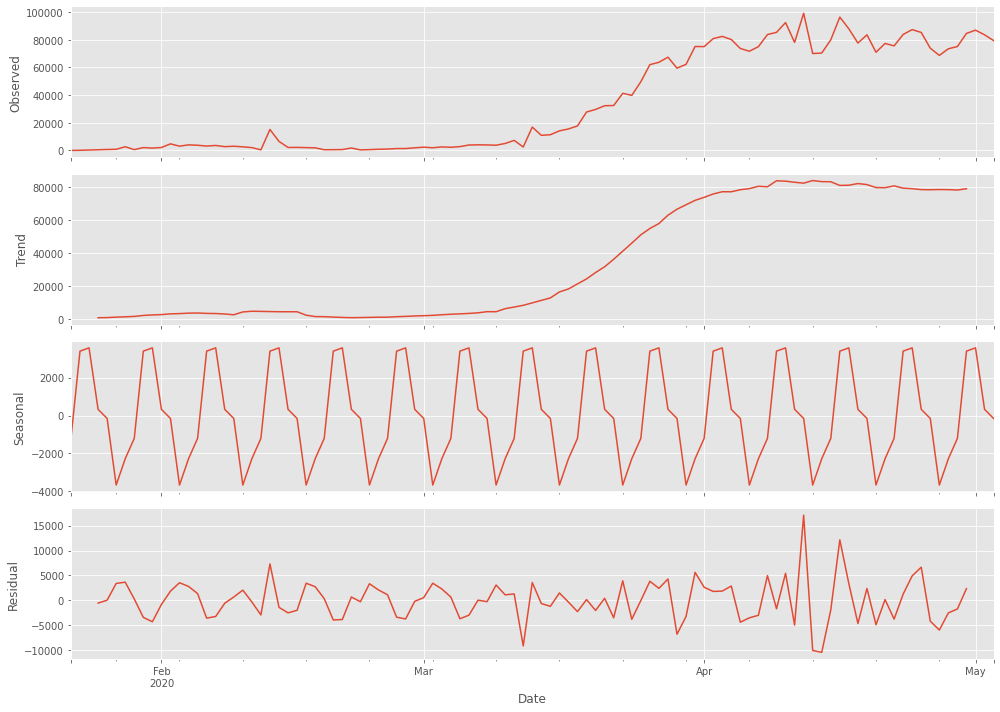

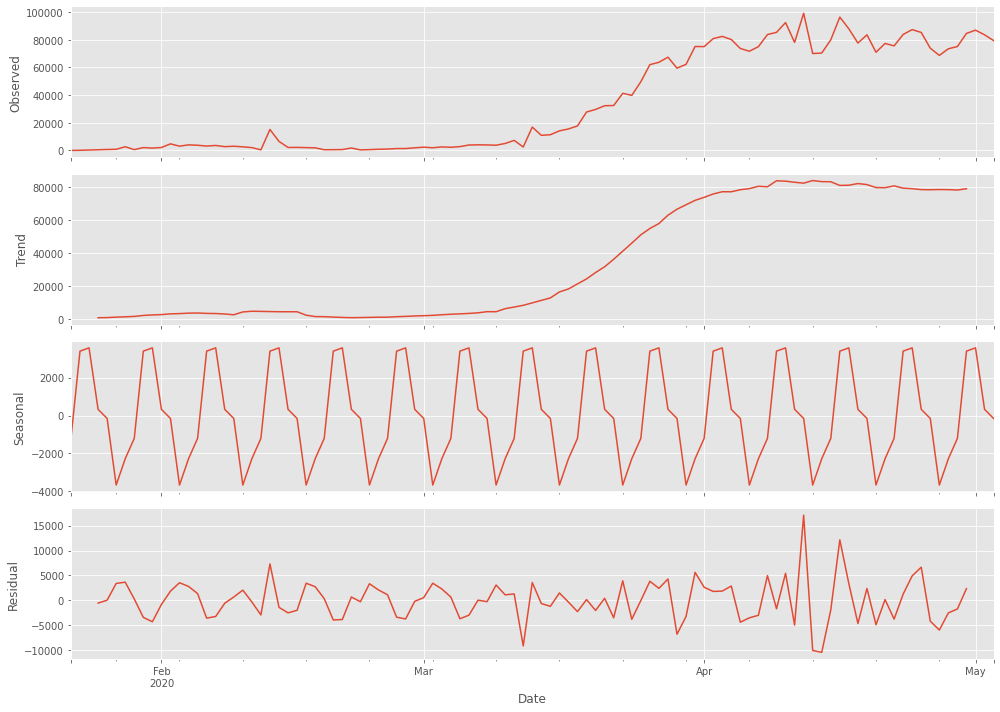

In [ ]:
import pylab
pylab.rcParams['figure.figsize'] = (14, 10)
decomposition_lags.plot()

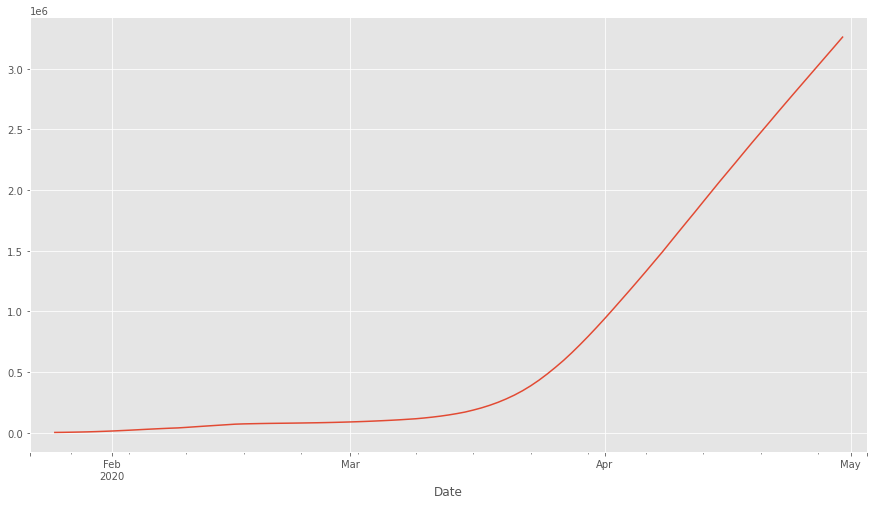

In [ ]:
import matplotlib.pyplot as plt 

fig, ax1 = plt.subplots(1,1, figsize=(15,8))
decomposition.trend.plot(ax=ax1)

# График тренда числа случаев отдельно 

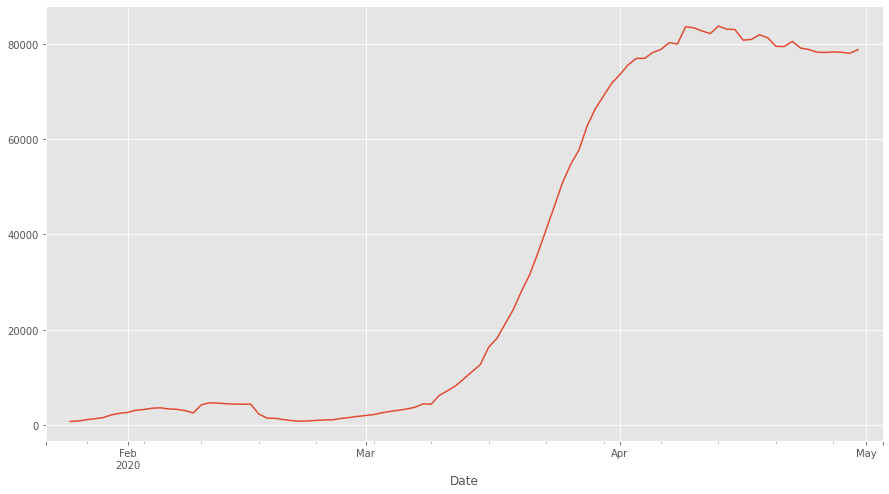

In [ ]:
import matplotlib.pyplot as plt 

fig, ax1 = plt.subplots(1,1, figsize=(15,8))
decomposition_lags.trend.plot(ax=ax1)

# График тренда ежедневного прироста случаев отдельно 

1.9 Для любого интересующего Вас временного ряда постройте графики ACF и PACF. Сделайте выводы. 

In [ ]:
from statsmodels.tsa.stattools import acf, pacf


Так как ARIMA будем строить на лаге 3 порядка, то и считать ACF и PACF имеет смысл для ряда из лагов 3 порядка. 

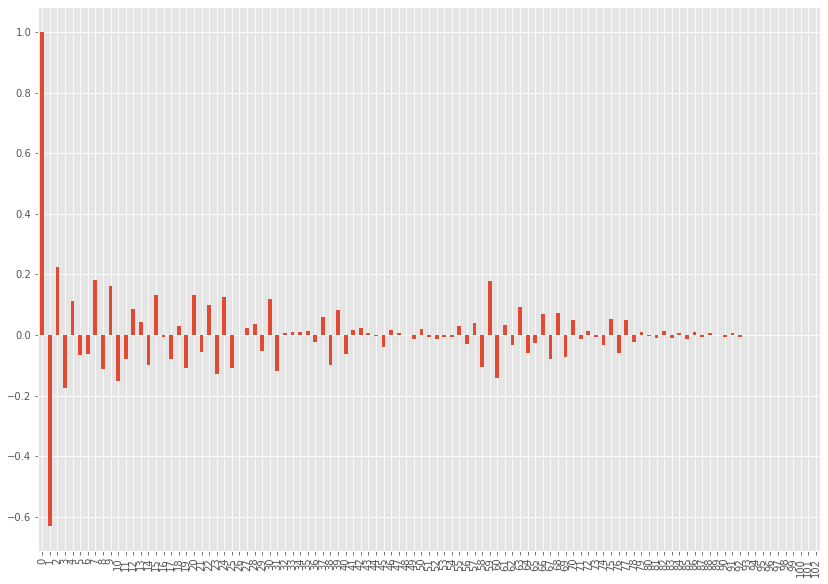

In [ ]:
lag_acf = acf(df_world.Delta_3.values, nlags=days-1)
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar")

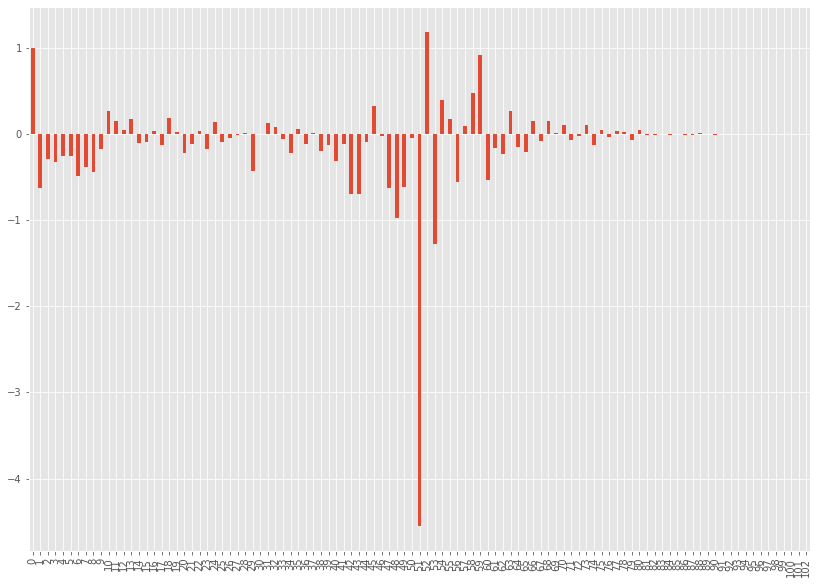

In [ ]:
lag_pacf = pacf(df_world.Delta_3.values, nlags=days-1, method='ols')
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar")

Из этих графиков можно предположить, что оптимальное значение AR части это 2. Для МА части существуют лаги высоких порядков, которые значимо отличаются от 0. Но попробую строить MA часть с 2. Так как будет использоваться лаг третьего порядка, то оптимальная ARIMA будет скорее всего выглядеть следующим образом ARIMA(2, 3, 2).

#### 1.10. Изучаемый Вами датасет отражает текущую мировую статистику распространения болезни. Однако эти данные не дают нам возможноси предположить о возможных факторах, которые влюяют на скорость распространения, летальности, заразность и тд. Поэтому в наш датасет можно добавить новые признаки из других наборов данных, которые могут не только помочь при прогнозировании временного ряда, но и определить наиболее значимые факторы.

- Добавьте новый признак "количество дней со дня первого случая заражения". Добавьте еще не менее 5 новых признаков в датасет, которые могут быть значимым фактором распространения вируса. Сохраните полученный датасет, вы можете его использовать во второй части домашнего задания.
- Исследуйте как добавленные признаки соотносятся с трендами распространения короновируса в некоторых странах. Сделайте выводы.

*Примеры признаков - количество дней со начала карантина, конинент, плотность населения, количество употребляемого алкоголя, летучих мышей, алкоголя, крокодилов на душу населения, количество туристов в год, уровень безработицы, температура, количество игроков в Plague Inc., средний возраст или продолжительность жизни и так далее. Вы можете использовать любой найденный датасет. Главное, чтобы у Вас получилось скомбинировать данные.*

  Примеры датасеты:
  1. [500 Cities: Local Data for Better Health (2019)](https://www.kaggle.com/jaimeblasco/500-cities-local-data-for-better-health-2019)
  2. [Daily global surface summary from over 9000 weather stations from 1929 to now](https://www.kaggle.com/noaa/gsod)
  3. [Population by Country - 2020](https://www.kaggle.com/tanuprabhu/population-by-country-2020)



In [ ]:
df_world_ext = df_world.drop(columns = ['Lat', 'Long'])
df_world_ext

Confirmed  Recovered    Deaths  ...  Growth_abs  Delta_2  Delta_3
Date                                        ...                              
2020-01-22     555.00      28.00     17.00  ...        0.00     0.00     0.00
2020-01-23     654.00      30.00     18.00  ...       99.00    99.00    99.00
2020-01-24     941.00      36.00     26.00  ...      287.00   188.00    89.00
2020-01-25    1434.00      39.00     42.00  ...      493.00   206.00    18.00
2020-01-26    2118.00      52.00     56.00  ...      684.00   191.00   -15.00
...               ...        ...       ...  ...         ...      ...      ...
2020-04-29 3172287.00  948425.00 227665.00  ...    75097.00  1629.00 -3150.00
2020-04-30 3256853.00 1013871.00 233357.00  ...    84566.00  9469.00  7840.00
2020-05-01 3343777.00 1052415.00 238619.00  ...    86924.00  2358.00 -7111.00
2020-05-02 3427343.00 1093112.00 243808.00  ...    83566.00 -3358.00 -5716.00
2020-05-03 3506729.00 1125236.00 247470.00  ...    79386.00 -4180.00  -822.00

[103 rows x 7 columns]

In [ ]:
df_countries = df1_temp.drop(columns = ['Lat', 'Long'])

In [ ]:
# Датасет с данными по населению

! wget https://www.dropbox.com/s/nx3rcwl53tif33l/population.csv?dl=0
pop = pd.read_csv('/content/population.csv?dl=0', sep = ';', header = 0)

--2020-05-05 02:24:18--  https://www.dropbox.com/s/nx3rcwl53tif33l/population.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nx3rcwl53tif33l/population.csv [following]
--2020-05-05 02:24:18--  https://www.dropbox.com/s/raw/nx3rcwl53tif33l/population.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5a972dde68ba7a96777c460700.dl.dropboxusercontent.com/cd/0/inline/A3Gna66JCvA_Qof0lGAxq_Xu0mrh_9awvT_QkePJTptZkNi8Y4aUmt9YQaya0t3eLeGwfaqqx5qNNZA0t-WIYVs5vpNcnuu22My9FdLSwXmGnZtOK-I9bpdS7DRMyM1x0-U/file# [following]
--2020-05-05 02:24:18--  https://uc5a972dde68ba7a96777c460700.dl.dropboxusercontent.com/cd/0/inline/A3Gna66JCvA_Qof0lGAxq_Xu0mrh_9awvT_QkePJTptZkNi8Y4aUmt9YQaya0t3eLeGwfaqqx5qNNZA0t-WIYVs5vpNcnuu22My9

In [ ]:
pop = pop.drop(columns = ['#', 'Yearly Change', 'Net change', 'Fert. Rate'])
pop.replace(pop['Country (or dependency)'][52], "Cote d'Ivoire", inplace=True)
pop.replace(pop['Country (or dependency)'][116], 'Congo (Brazzaville)', inplace=True)
pop.replace(pop['Country (or dependency)'][15], 'Congo (Kinshasa)', inplace=True)
pop.replace(pop['Country (or dependency)'][85], 'Czechia', inplace=True) 
pop.replace(pop['Country (or dependency)'][2], 'US', inplace=True)
pop.replace(pop['Country (or dependency)'][27], 'Korea, South', inplace=True)
pop.replace(pop['Country (or dependency)'][210], 'Saint Kitts and Nevis', inplace=True)
pop.replace(pop['Country (or dependency)'][195], 'Saint Vincent and the Grenadines', inplace=True)
pop.replace(pop['Country (or dependency)'][186], 'Sao Tome and Principe', inplace=True)
pop.replace(pop['Country (or dependency)'][120], 'West Bank and Gaza', inplace=True)
pop.replace(pop['Country (or dependency)'][56], 'Taiwan*', inplace=True)
new_index = list(pop['Country (or dependency)'].values)
pop.index = new_index
pop

Country (or dependency)  Population  ... Urban Pop %  World Share
China                              China  1439323776  ...        0,61       18,47%
India                              India  1380004385  ...        0,35       17,70%
US                                    US   331002651  ...        0,83        4,25%
Indonesia                      Indonesia   273523615  ...        0,56        3,51%
Pakistan                        Pakistan   220892340  ...        0,35        2,83%
...                                  ...         ...  ...         ...          ...
Montserrat                    Montserrat        4992  ...         0,1        0,00%
Falkland Islands        Falkland Islands         348  ...        0,66        0,00%
Niue                                Niue        1626  ...        0,46        0,00%
Tokelau                          Tokelau        1357  ...           0        0,00%
Holy See                        Holy See         801  ...        N.A.        0,00%

[235 rows x 8 columns]

In [ ]:
df_countries.drop(index = ['Burma', 'Diamond Princess', 'Kosovo', 'MS Zaandam'], inplace = True)

In [ ]:
pop.drop(columns = ['Country (or dependency)'], inplace =True)
df_countries = pd.concat([df_countries, pop.loc[list(df_countries.index)]], axis =1)
df_countries

Confirmed  Recovered  ...  Urban Pop %  World Share
Country/Region                            ...                          
Afghanistan           2704.00     345.00  ...         0,25        0,50%
Albania                795.00     531.00  ...         0,63        0,04%
Algeria               4474.00    1936.00  ...         0,73        0,56%
Andorra                748.00     493.00  ...         0,88        0,00%
Angola                  35.00      11.00  ...         0,67        0,42%
...                       ...        ...  ...          ...          ...
West Bank and Gaza     353.00      77.00  ...          0,8        0,07%
Western Sahara           6.00       5.00  ...         0,87        0,01%
Yemen                   10.00       1.00  ...         0,38        0,38%
Zambia                 124.00      78.00  ...         0,45        0,24%
Zimbabwe                34.00       5.00  ...         0,38        0,19%

[183 rows x 16 columns]

In [ ]:
for i in range(len(df_countries['Urban Pop %'].values)):
  df_countries['Urban Pop %'][i] = df_countries['Urban Pop %'][i].replace(',', '.')

for i in range(len(df_countries['Med. Age'].values)):
  df_countries['Med. Age'][i] = df_countries['Med. Age'][i].replace('N.A.', '0')

for i in range(len(df_countries['Density (P/SQ_KM)'].values)):
  df_countries['Density (P/SQ_KM)'][i] = str(df_countries['Density (P/SQ_KM)'][i]).replace(',', '.')

for i in range(len(df_countries['Land Area (SQ_KM)'].values)):
  df_countries['Land Area (SQ_KM)'][i] = str(df_countries['Land Area (SQ_KM)'][i]).replace(',', '.')

for i in range(len(df_countries['World Share'].values)):
  df_countries['World Share'][i] = df_countries['World Share'][i].replace(',', '.')
  df_countries['World Share'][i] = df_countries['World Share'][i].replace('%', '')

In [ ]:
df_countries

Confirmed  Recovered  ...  Urban Pop %  World Share
Country/Region                            ...                          
Afghanistan           2704.00     345.00  ...         0.25         0.50
Albania                795.00     531.00  ...         0.63         0.04
Algeria               4474.00    1936.00  ...         0.73         0.56
Andorra                748.00     493.00  ...         0.88         0.00
Angola                  35.00      11.00  ...         0.67         0.42
...                       ...        ...  ...          ...          ...
West Bank and Gaza     353.00      77.00  ...          0.8         0.07
Western Sahara           6.00       5.00  ...         0.87         0.01
Yemen                   10.00       1.00  ...         0.38         0.38
Zambia                 124.00      78.00  ...         0.45         0.24
Zimbabwe                34.00       5.00  ...         0.38         0.19

[183 rows x 16 columns]

In [ ]:
df_countries.to_csv('dataset_extended.csv')

In [ ]:
df_countries.corr(method='pearson').style.background_gradient(cmap='cool').set_precision(2)

### 1.11 Выводы
Выводы писал в целом по каждому пункту в самих пунктах. Здесь прокомментирую матрицу корреляций. Здесь, как мне кажется, самый важный элемент это корреляция Migrants(net) (конечно было бы лучше видеть не чистую, а суммарную из тех кто прибыл в страну и убыл из нее, так как именно этот показатель оценивает пассажиропоток и да показатель на дату, а не за период эпидемии, но он важный) с числом подтвержденных случаев. Как раз таки, это взаимосвязь хорошо объясняется, тем что чем больше миграция, тем выше шанс того, что эпидемия начнется раньше, чем у других и соответственно число больных будет больше, чем в тех странах, где она началась позже. Корреляция между Deaths, Recovered, Confirmed тоже не удивительна. 

## 2. Прогнозирование временного ряда

Теперь вам предстоит построить несколько моделей и спрогнозировать временной ряд для такого показателя как летальности от вируса. Летальность можно рассчитывать по формуле:

$$ CFR = \frac{Deaths}{Confirmed} $$

Для каждого типа модели сделайте несколько прогнозов для не менее 3 разных стран/регионов/другое (на ваш обоснованный выбор). Главное, чтобы каждый из типов моделей прознозировал одинаковый набор данных, чтобы в конце можно было сделать выводы о качестве работы той или иной модели.

Метрика качества RMSE. Не забудьте разбить данные временной ряд на данные для обучения и тестовые.

Не забывайте сопровождать ваш код комментариями, графиками и выводами.

In [ ]:
!wget https://www.dropbox.com/s/jvau2mgkuunusgu/dataset_extended.csv?dl=0

--2020-05-05 01:17:09--  https://www.dropbox.com/s/jvau2mgkuunusgu/dataset_extended.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jvau2mgkuunusgu/dataset_extended.csv [following]
--2020-05-05 01:17:09--  https://www.dropbox.com/s/raw/jvau2mgkuunusgu/dataset_extended.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccee2f5ef00266c1cb7102e2d94.dl.dropboxusercontent.com/cd/0/inline/A3GkNWJjExtJ9c_oPp7HGTw7__3hqND7-5XYixpe4vsF3gR852qUAqT1Yart2dHRzHR2uCYZI2p_iAioH-b9m8K3_MXgbg6T3hJV_lmTklDET6q8Cm6R72qBTl-c-eNz65Q/file# [following]
--2020-05-05 01:17:09--  https://uccee2f5ef00266c1cb7102e2d94.dl.dropboxusercontent.com/cd/0/inline/A3GkNWJjExtJ9c_oPp7HGTw7__3hqND7-5XYixpe4vsF3gR852qUAqT1Yart2dHRzHR2uCYZI2p_iAioH-

Из-за того, что я сделал всю первую часть динамической и данные постоянно обновляются, то возможно ситуация когда создание нового датафрейма будет с ошибкой из-за увеличевшегося числа стран. Поэтому буду подгружать его так. Это тот же датафреййм, что и df_countries. В моделях буду использовать не обновляющиеся данные.

In [ ]:
df_ext = pd.read_csv('/content/dataset_extended.csv?dl=0', sep = ',')


Разделим выборку в отношении 80 на 20 дней (так как рассматриваемый период 100 дней) на train и test. Сперва буду делить, а потом проводить операции с nan для тех стран, где первый случай заболевания это не первый день в датасете.

In [ ]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

### 2.1 Прогнозирование средним (Mean Constant Model)

В прошлом блоке я создал лист датафреймов для топ 10 стран и Китая по дням. Он также обновляется с обновлением данных. Поэтому возьмем в каждом датафрейме только 100 дней.

Все прогнозы для сопоставимости я буду строить для США [9], Италии [2] и России [1].

In [ ]:
df_russia_100 = dfs_list[1].iloc[:100]
df_italy_100 = dfs_list[2].iloc[:100]
df_us_100 = dfs_list[9].iloc[:100]

In [ ]:
def ConstantModel(dataframe):
  case_day = int(df_ext[df_ext['Country/Region'] == dataframe.index[0][1]]['First_case_n'].values)
  dataframe = dataframe.iloc[case_day:80]
  mean_forecast = dataframe['Deaths/Confirmed'].values.mean()
  return mean_forecast


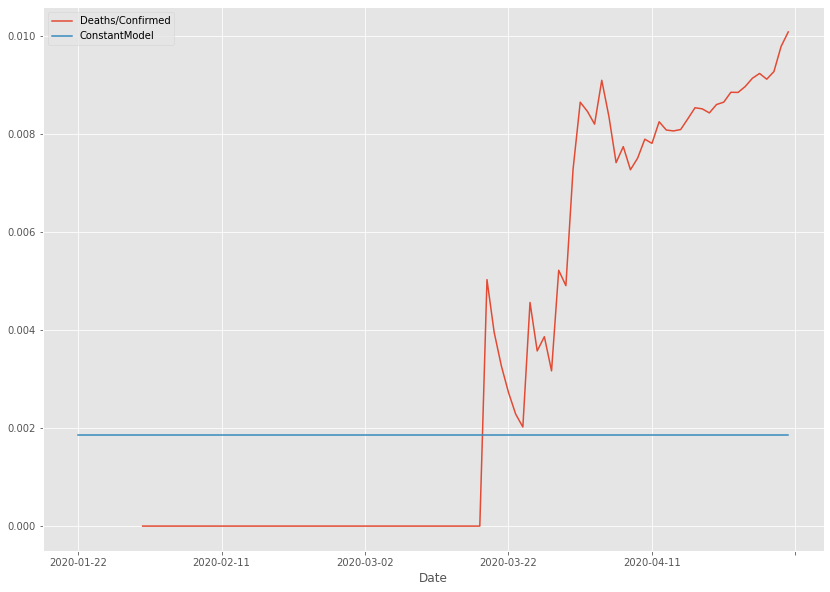

In [ ]:
df_russia_100['ConstantModel'] = ConstantModel(df_russia_100) 
df_russia_100.plot(kind="line", x="Date", y = ["Deaths/Confirmed", "ConstantModel"])

In [ ]:
# Качество на тесте
ConstantModel_RMSE_ru = RMSE(df_russia_100.iloc[80:100]['Deaths/Confirmed'], df_russia_100.iloc[80:100]['ConstantModel'])
ConstantModel_RMSE_ru 

0.006885097393603345

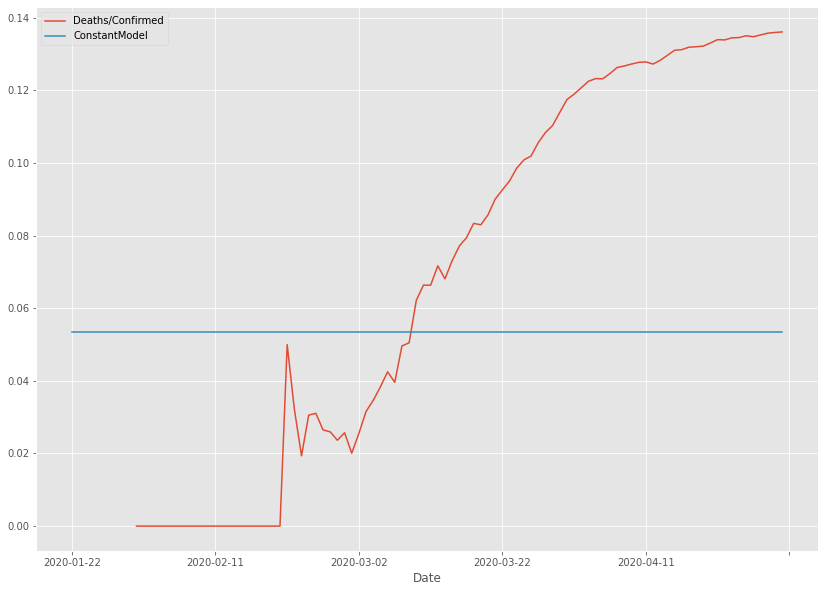

In [ ]:
df_italy_100['ConstantModel'] = ConstantModel(df_italy_100) 
df_italy_100.plot(kind="line", x="Date", y = ["Deaths/Confirmed", "ConstantModel"])

In [ ]:
# Качество на тесте
ConstantModel_RMSE_it = RMSE(df_italy_100.iloc[80:100]['Deaths/Confirmed'], df_italy_100.iloc[80:100]['ConstantModel'])
ConstantModel_RMSE_it 

0.07938726100270688

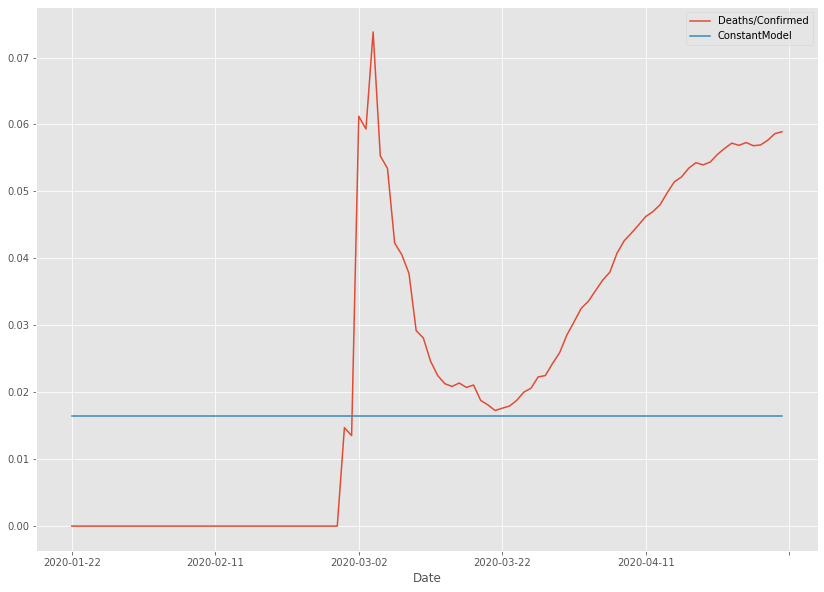

In [ ]:
df_us_100['ConstantModel'] = ConstantModel(df_us_100) 
df_us_100.plot(kind="line", x="Date", y = ["Deaths/Confirmed", "ConstantModel"])

In [ ]:
# Качество на тесте
ConstantModel_RMSE_us = RMSE(df_us_100.iloc[80:100]['Deaths/Confirmed'], df_us_100.iloc[80:100]['ConstantModel'])
ConstantModel_RMSE_us 

0.03793016512584514

#### 2.2 Линейная модель (Linear Trend Model) 

In [ ]:
def LinearModel(dataframe):
  case_day = int(df_ext[df_ext['Country/Region'] == dataframe.index[0][1]]['First_case_n'].values)
  dataframe_train = dataframe.iloc[case_day:80]
  dataframe_test = dataframe.iloc[80:100]
  linear_model = sma.OLS(dataframe_train['Deaths/Confirmed'].values, dataframe_train['TimeIndex'].values).fit()
  linear_forecast_train = linear_model.predict()
  model_params = linear_model.params
  linear_forecast_test = np.dot(dataframe_test['TimeIndex'].values.reshape(-1, 1), model_params)
  if len(linear_forecast_train) == 80:
    return linear_forecast_train, linear_forecast_test
  if len(linear_forecast_train) != 80:
    return np.hstack((np.zeros(80-len(linear_forecast_train)), linear_forecast_train)), linear_forecast_test, model_params

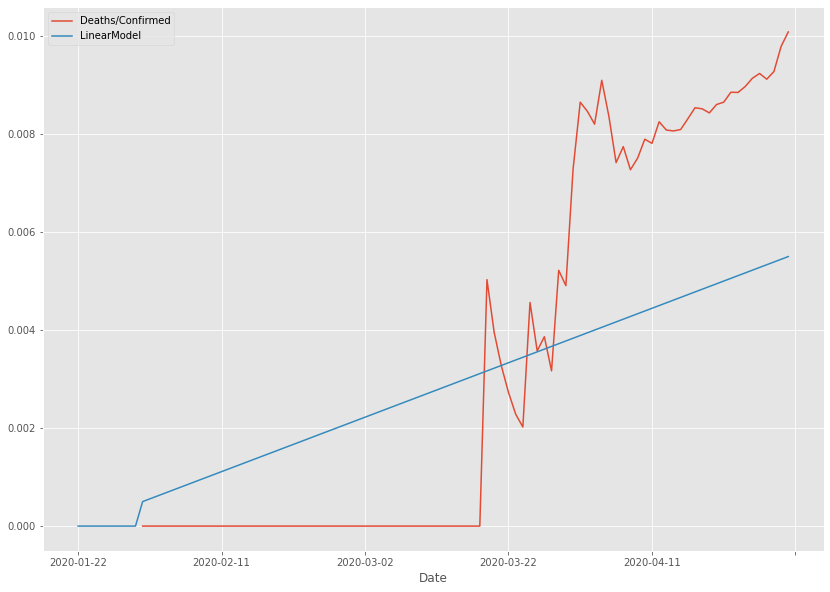

In [ ]:
df_russia_100['LinearModel'] = np.hstack((LinearModel(df_russia_100)[0], LinearModel(df_russia_100)[1]))
df_russia_100.plot(kind="line", x="Date", y = ["Deaths/Confirmed", "LinearModel"])


In [ ]:
# Качество на тесте
ConstantModel_RMSE_ru = RMSE(df_russia_100.iloc[80:100]['Deaths/Confirmed'], df_russia_100.iloc[80:100]['LinearModel'])
ConstantModel_RMSE_ru 

0.0037681100732887434

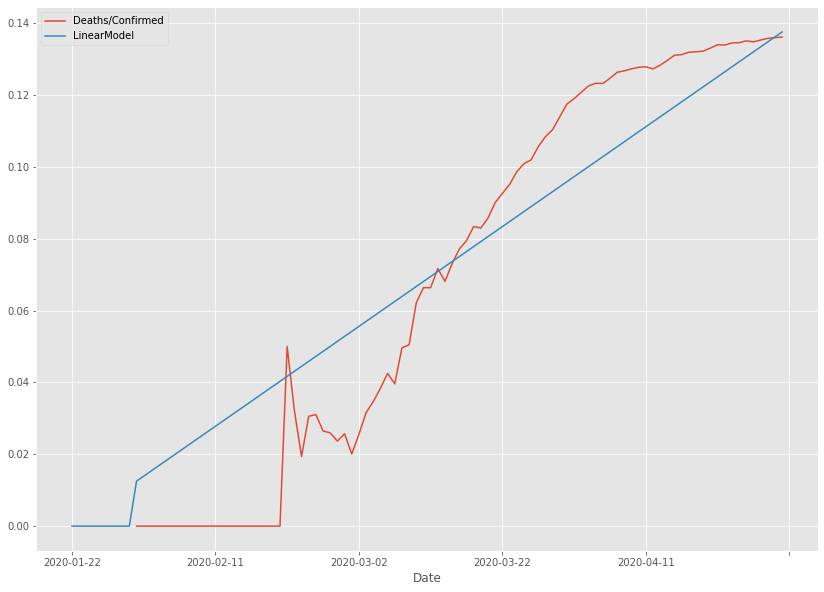

In [ ]:
df_italy_100['LinearModel'] = np.hstack((LinearModel(df_italy_100)[0], LinearModel(df_italy_100)[1]))
df_italy_100.plot(kind="line", x="Date", y = ["Deaths/Confirmed", "LinearModel"])


In [ ]:
# Качество на тесте
ConstantModel_RMSE_it = RMSE(df_italy_100.iloc[80:100]['Deaths/Confirmed'], df_italy_100.iloc[80:100]['LinearModel'])
ConstantModel_RMSE_it 

0.00998031625802423

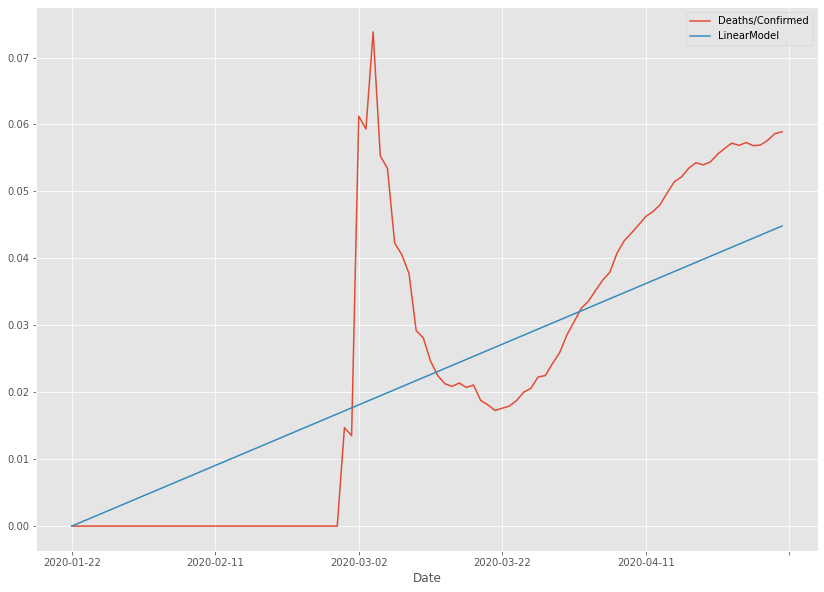

In [ ]:
df_us_100['LinearModel'] = np.hstack((LinearModel(df_us_100)[0], LinearModel(df_us_100)[1]))
df_us_100.plot(kind="line", x="Date", y = ["Deaths/Confirmed", "LinearModel"])


In [ ]:
# Качество на тесте
ConstantModel_RMSE_us = RMSE(df_us_100.iloc[80:100]['Deaths/Confirmed'], df_us_100.iloc[80:100]['LinearModel'])
ConstantModel_RMSE_us 

0.013709090750228158

#### 2.3 Экспоненциальное сглаживание (Exponential smoothing)

Попробуйте так же применить Double exponential smoothing или Triple exponential smoothing.

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

def ExponentialSmoothing(dataframe, alpha):
  case_day = int(df_ext[df_ext['Country/Region'] == dataframe.index[0][1]]['First_case_n'].values)
  dataframe_train = dataframe.iloc[case_day:80]['Deaths/Confirmed']
  dataframe_test = dataframe.iloc[80:100]['Deaths/Confirmed'] 

  model = SimpleExpSmoothing(dataframe_train)

  fit1 = model.fit(smoothing_level=alpha)
  pred1 = fit1.forecast(20)
  fit_pred1 = list(fit1.fittedvalues) + list(pred1)

  fig, ax = plt.subplots(figsize=(12, 6))
  ax.plot(np.arange(case_day, 100), dataframe['Deaths/Confirmed'].iloc[case_day:].values)
  ax.plot(np.arange(case_day, 100), fit_pred1, label="alpha="+str(fit1.params['smoothing_level'])[:3], color='blue')

  plt.title("Simple Exponential Smoothing")    
  plt.legend();
  return list(np.zeros(case_day)) + fit_pred1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provide

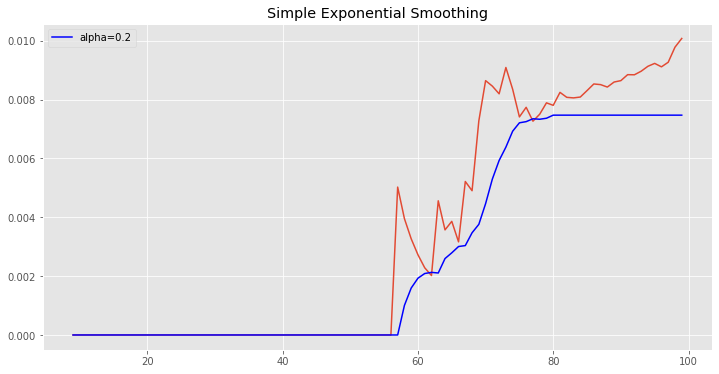

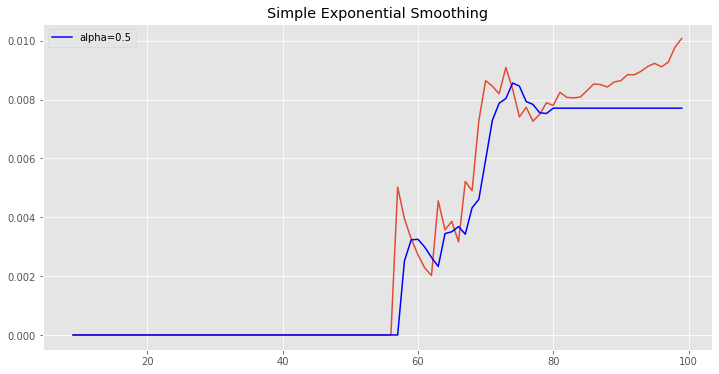

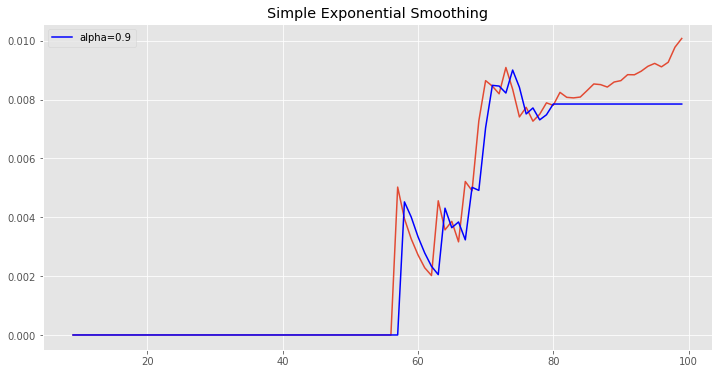

In [ ]:
df_russia_100['ExpSmthModel_1'] = ExponentialSmoothing(df_russia_100, 0.2)
df_russia_100['ExpSmthModel_2'] = ExponentialSmoothing(df_russia_100, 0.5)
df_russia_100['ExpSmthModel_3'] = ExponentialSmoothing(df_russia_100, 0.9)


In [ ]:
# Качество на тесте
ExpSmthModel_1_RMSE_ru = RMSE(df_russia_100.iloc[80:100]['Deaths/Confirmed'], df_russia_100.iloc[80:100]['ExpSmthModel_1'])
ExpSmthModel_2_RMSE_ru = RMSE(df_russia_100.iloc[80:100]['Deaths/Confirmed'], df_russia_100.iloc[80:100]['ExpSmthModel_2'])
ExpSmthModel_3_RMSE_ru = RMSE(df_russia_100.iloc[80:100]['Deaths/Confirmed'], df_russia_100.iloc[80:100]['ExpSmthModel_3'])

ExpSmthModel_1_RMSE_ru, ExpSmthModel_2_RMSE_ru, ExpSmthModel_3_RMSE_ru 

(0.0013813671812865568, 0.0011695623601228236, 0.0010494602313470519)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provide

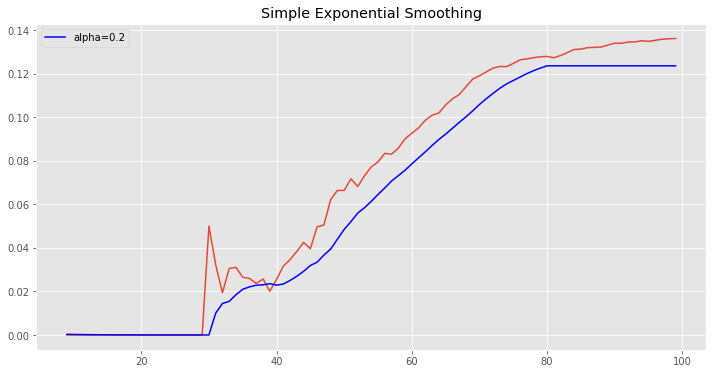

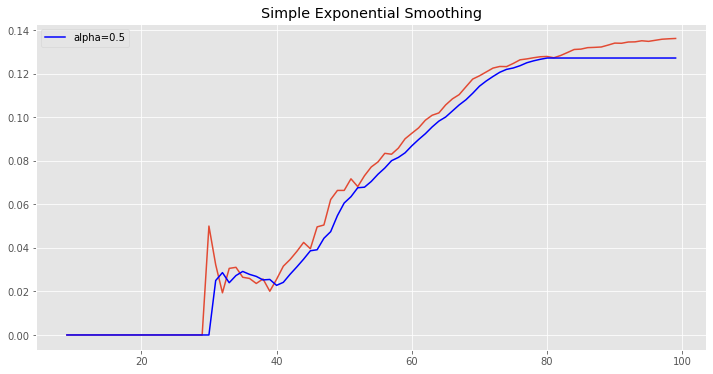

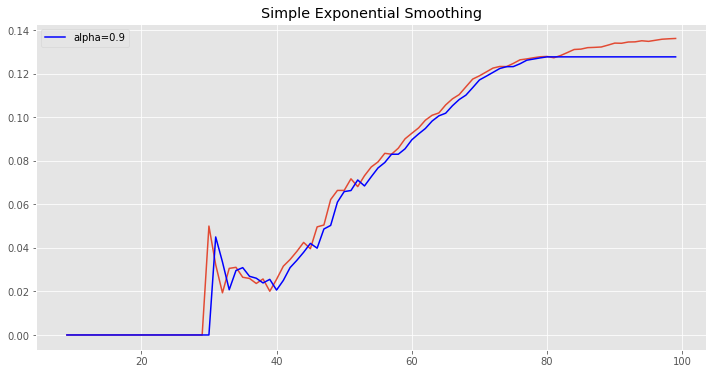

In [ ]:
df_italy_100['ExpSmthModel_1'] = ExponentialSmoothing(df_italy_100, 0.2)
df_italy_100['ExpSmthModel_2'] = ExponentialSmoothing(df_italy_100, 0.5)
df_italy_100['ExpSmthModel_3'] = ExponentialSmoothing(df_italy_100, 0.9)


In [ ]:
# Качество на тесте
ExpSmthModel_1_RMSE_it = RMSE(df_italy_100.iloc[80:100]['Deaths/Confirmed'], df_italy_100.iloc[80:100]['ExpSmthModel_1'])
ExpSmthModel_2_RMSE_it = RMSE(df_italy_100.iloc[80:100]['Deaths/Confirmed'], df_italy_100.iloc[80:100]['ExpSmthModel_2'])
ExpSmthModel_3_RMSE_it = RMSE(df_italy_100.iloc[80:100]['Deaths/Confirmed'], df_italy_100.iloc[80:100]['ExpSmthModel_3'])

ExpSmthModel_1_RMSE_it, ExpSmthModel_2_RMSE_it, ExpSmthModel_3_RMSE_it 

(0.009556440218404317, 0.006203449759898345, 0.005730084835888081)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provide

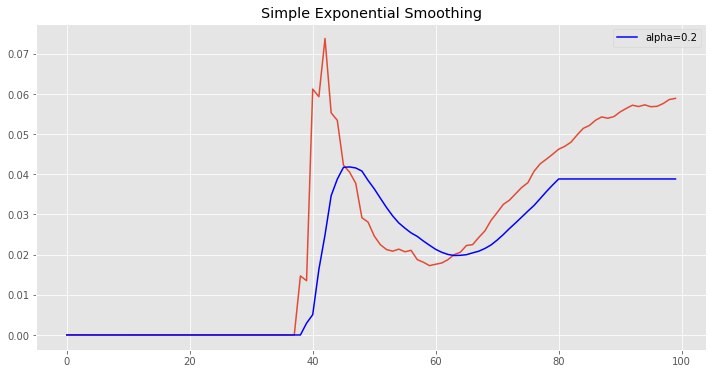

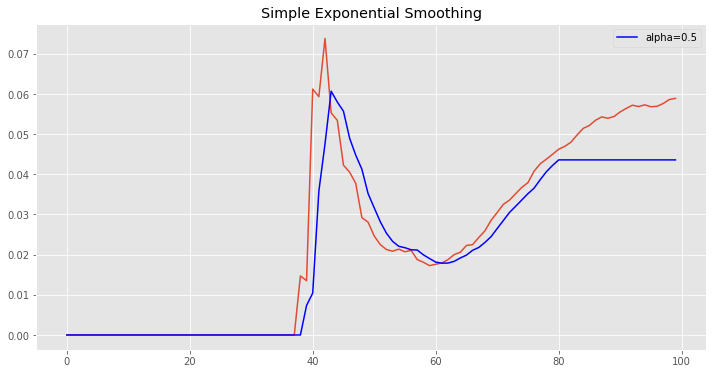

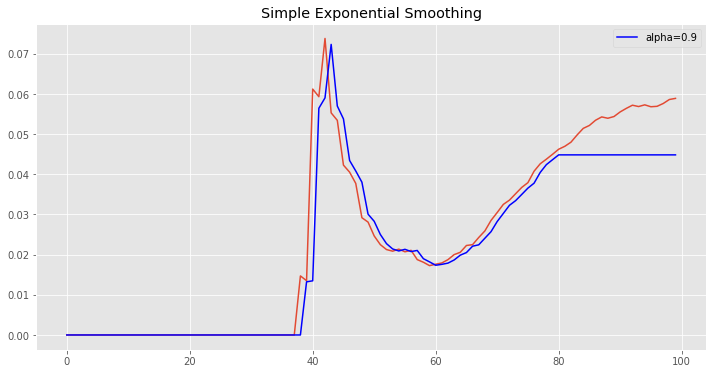

In [ ]:
df_us_100['ExpSmthModel_1'] = ExponentialSmoothing(df_us_100, 0.2)
df_us_100['ExpSmthModel_2'] = ExponentialSmoothing(df_us_100, 0.5)
df_us_100['ExpSmthModel_3'] = ExponentialSmoothing(df_us_100, 0.9)


In [ ]:
# Качество на тесте
ExpSmthModel_1_RMSE_us = RMSE(df_us_100.iloc[80:100]['Deaths/Confirmed'], df_us_100.iloc[80:100]['ExpSmthModel_1'])
ExpSmthModel_2_RMSE_us = RMSE(df_us_100.iloc[80:100]['Deaths/Confirmed'], df_us_100.iloc[80:100]['ExpSmthModel_2'])
ExpSmthModel_3_RMSE_us = RMSE(df_us_100.iloc[80:100]['Deaths/Confirmed'], df_us_100.iloc[80:100]['ExpSmthModel_3'])

ExpSmthModel_1_RMSE_us, ExpSmthModel_2_RMSE_us, ExpSmthModel_3_RMSE_us 

(0.0157667777830067, 0.011215166481040413, 0.010045462972223326)

In [ ]:
def DoubleExponentialSmoothing(dataframe, alpha, beta, exponential=False, damped=False, damping_slope=0.98):
  case_day = int(df_ext[df_ext['Country/Region'] == dataframe.index[0][1]]['First_case_n'].values)
  dataframe_train = dataframe.iloc[case_day:80]['Deaths/Confirmed']
  dataframe_test = dataframe.iloc[80:100]['Deaths/Confirmed'] 

  fit1 = Holt(dataframe_train, exponential = exponential, damped = damped).fit(smoothing_level=alpha, 
                                                                               smoothing_slope=beta, damping_slope=damping_slope)
  pred1 = fit1.forecast(20)
  fit_pred1 = list(fit1.fittedvalues) + list(pred1)
  
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.plot(np.arange(case_day, 100), dataframe['Deaths/Confirmed'].iloc[case_day:].values)
  ax.plot(np.arange(case_day, 100), fit_pred1, label="alpha="+str(fit1.params['smoothing_level'])[:4]+", beta="+str(fit1.params['smoothing_slope'])[:4], color='blue')

  plt.title("Double Exponential Smoothing")    
  plt.legend();
  return list(np.zeros(case_day)) + fit_pred1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provide

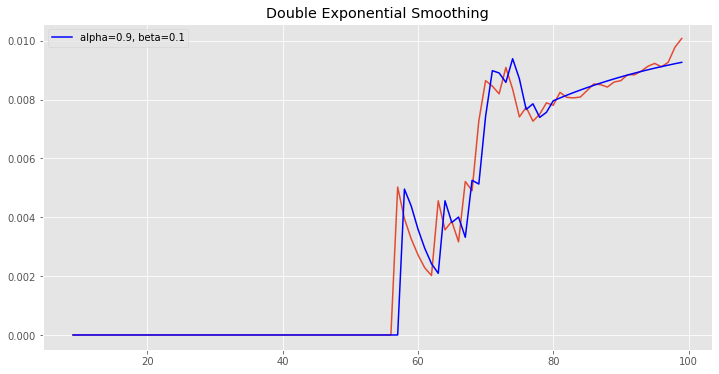

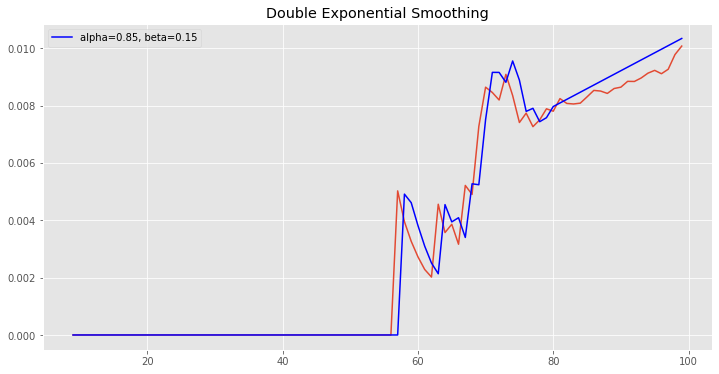

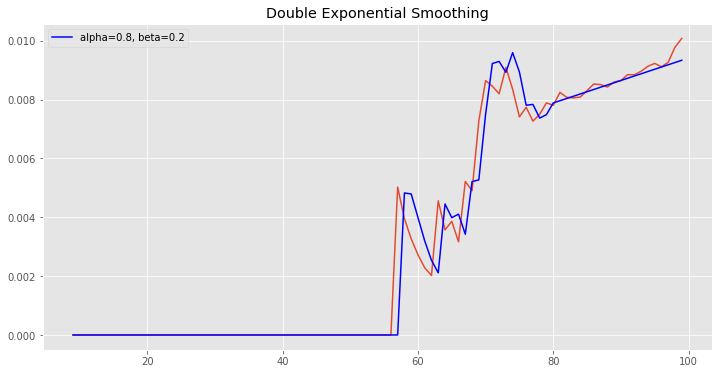

In [ ]:
df_russia_100['DoubleExpSmthModel_1'] = DoubleExponentialSmoothing(df_russia_100, 0.9, 0.1,  
                                                                   damped=True, damping_slope =0.96)
df_russia_100['DoubleExpSmthModel_2'] = DoubleExponentialSmoothing(df_russia_100, 0.85, 0.15)
df_russia_100['DoubleExpSmthModel_3'] = DoubleExponentialSmoothing(df_russia_100, 0.8, 0.2)

In [ ]:
# Качество на тесте
DoubleExpSmthModel_1_RMSE_ru = RMSE(df_russia_100.iloc[80:100]['Deaths/Confirmed'], df_russia_100.iloc[80:100]['DoubleExpSmthModel_1'])
DoubleExpSmthModel_2_RMSE_ru = RMSE(df_russia_100.iloc[80:100]['Deaths/Confirmed'], df_russia_100.iloc[80:100]['DoubleExpSmthModel_2'])
DoubleExpSmthModel_3_RMSE_ru = RMSE(df_russia_100.iloc[80:100]['Deaths/Confirmed'], df_russia_100.iloc[80:100]['DoubleExpSmthModel_3'])

DoubleExpSmthModel_1_RMSE_ru, DoubleExpSmthModel_2_RMSE_ru, DoubleExpSmthModel_3_RMSE_ru 

(0.0002514032752185114, 0.0004906341804790161, 0.00023189460369292642)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provide

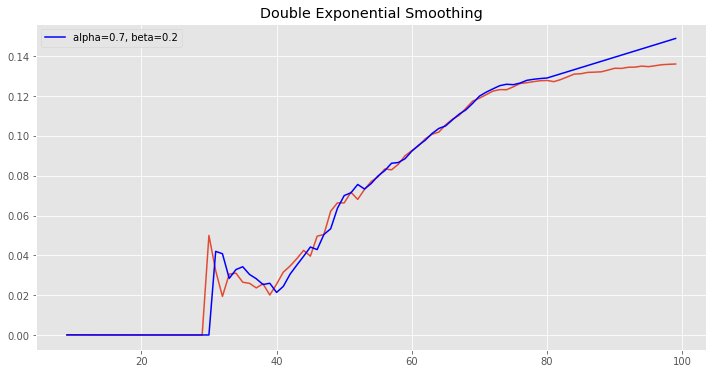

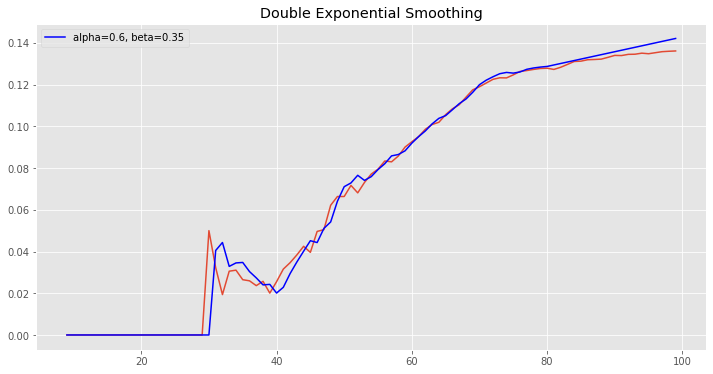

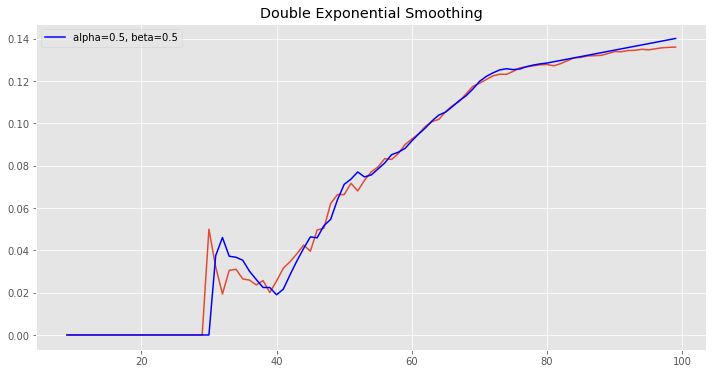

In [ ]:
df_italy_100['DoubleExpSmthModel_1'] = DoubleExponentialSmoothing(df_italy_100, 0.7, 0.2)
df_italy_100['DoubleExpSmthModel_2'] = DoubleExponentialSmoothing(df_italy_100, 0.6, 0.35)
df_italy_100['DoubleExpSmthModel_3'] = DoubleExponentialSmoothing(df_italy_100, 0.5, 0.5)

In [ ]:
# Качество на тесте
DoubleExpSmthModel_1_RMSE_it = RMSE(df_italy_100.iloc[80:100]['Deaths/Confirmed'], df_italy_100.iloc[80:100]['DoubleExpSmthModel_1'])
DoubleExpSmthModel_2_RMSE_it = RMSE(df_italy_100.iloc[80:100]['Deaths/Confirmed'], df_italy_100.iloc[80:100]['DoubleExpSmthModel_2'])
DoubleExpSmthModel_3_RMSE_it = RMSE(df_italy_100.iloc[80:100]['Deaths/Confirmed'], df_italy_100.iloc[80:100]['DoubleExpSmthModel_3'])

DoubleExpSmthModel_1_RMSE_it, DoubleExpSmthModel_2_RMSE_it, DoubleExpSmthModel_3_RMSE_it 

(0.007199969619839696, 0.0031253718059353884, 0.002001396990003954)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provide

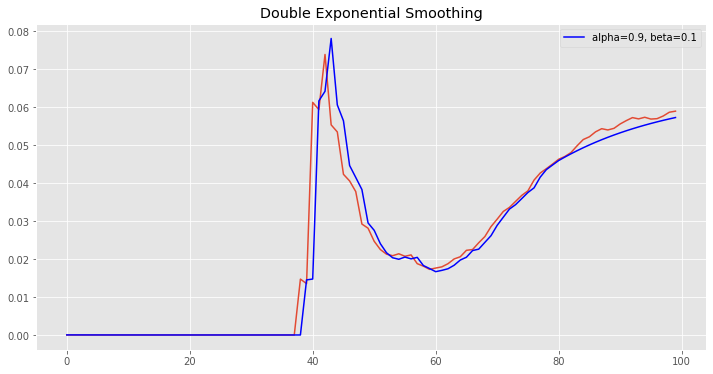

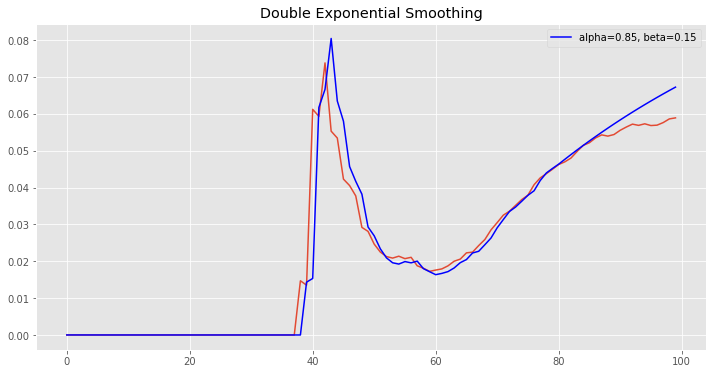

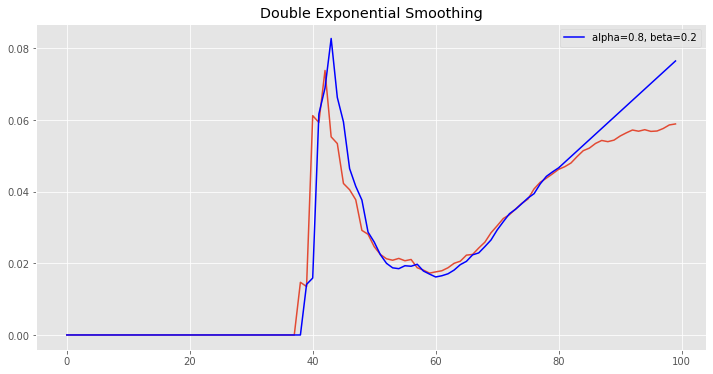

In [ ]:
df_us_100['DoubleExpSmthModel_1'] = DoubleExponentialSmoothing(df_us_100, 0.9, 0.1, 
                                                               damped = True, damping_slope =0.95)
df_us_100['DoubleExpSmthModel_2'] = DoubleExponentialSmoothing(df_us_100, 0.85, 0.15, damped = True)
df_us_100['DoubleExpSmthModel_3'] = DoubleExponentialSmoothing(df_us_100, 0.8, 0.2)

In [ ]:
# Качество на тесте
DoubleExpSmthModel_1_RMSE_us = RMSE(df_us_100.iloc[80:100]['Deaths/Confirmed'], df_us_100.iloc[80:100]['DoubleExpSmthModel_1'])
DoubleExpSmthModel_2_RMSE_us = RMSE(df_us_100.iloc[80:100]['Deaths/Confirmed'], df_us_100.iloc[80:100]['DoubleExpSmthModel_2'])
DoubleExpSmthModel_3_RMSE_us = RMSE(df_us_100.iloc[80:100]['Deaths/Confirmed'], df_us_100.iloc[80:100]['DoubleExpSmthModel_3'])

DoubleExpSmthModel_1_RMSE_us, DoubleExpSmthModel_2_RMSE_us, DoubleExpSmthModel_3_RMSE_us 

(0.0019128226490765516, 0.004367448394779092, 0.00929005114511935)

Сезонности  нет, поэтому смысла в тройном экспоненциальном сглаживании нет.

#### 2.4 Скользящее среднее (MA - Moving average)

In [ ]:
def MA(dataframe, n):

  case_day = int(df_ext[df_ext['Country/Region'] == dataframe.index[0][1]]['First_case_n'].values)
  dataframe_train = dataframe.iloc[case_day:80]['Deaths/Confirmed']
  dataframe_test = dataframe.iloc[80:100]['Deaths/Confirmed']
      
  rolling_mean_train = dataframe_train.rolling(window=n).mean()
  
  list_temp = list(dataframe_train.iloc[80 - case_day - n:])
  for i in range(20):
    list_temp.append(sum(list_temp[i:n+i])/n)
  
  rolling_mean = list(rolling_mean_train.values) + list_temp[n:]

  fig, ax = plt.subplots(figsize=(12, 6))
  
  ax.plot(np.arange(n-1,100), dataframe['Deaths/Confirmed'][n-1:].values, label="Actual values", c = 'red') 
  ax.plot(np.arange(case_day, 100), rolling_mean, color = 'blue', label="Rolling mean trend")
  
  plt.title("Moving average\n window size = {}".format(n))
  plt.legend(loc="upper left")
  plt.grid(True)
  rolling_mean[:n-1] = np.zeros(100 - len(rolling_mean)) 
  rolling_mean = list(np.zeros(n-1)) + rolling_mean
  return rolling_mean

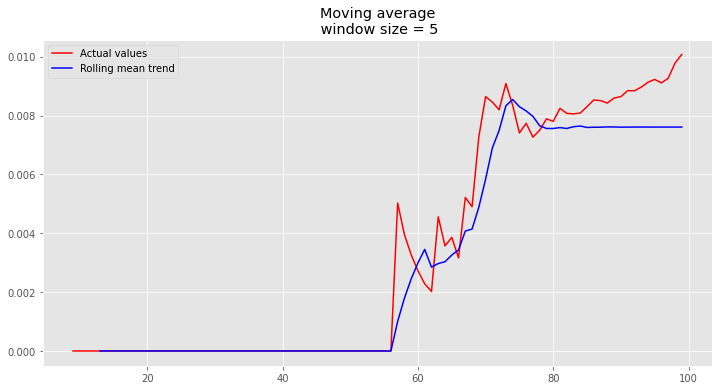

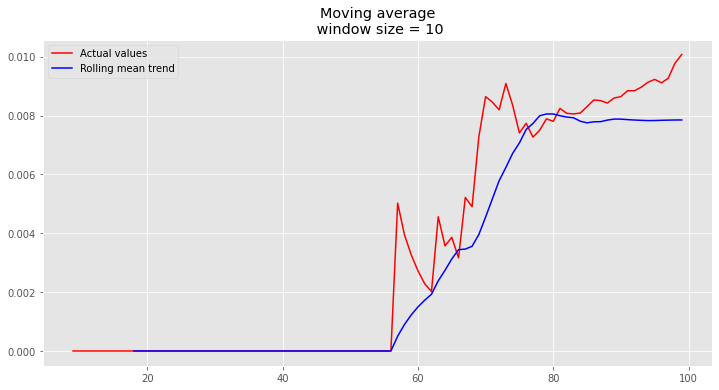

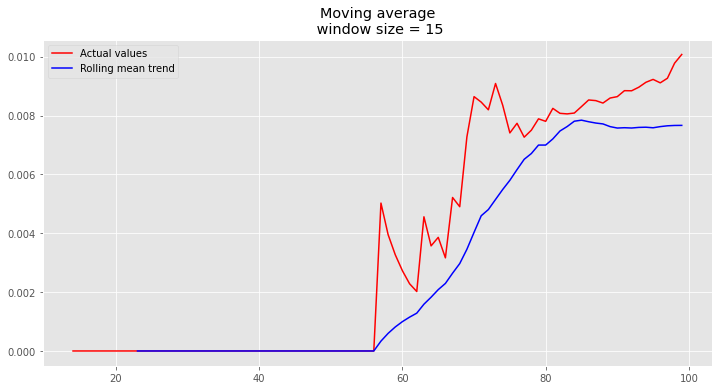

In [ ]:
df_russia_100['MovAverModel_1'] = MA(df_russia_100, 5)
df_russia_100['MovAverModel_2'] = MA(df_russia_100, 10)
df_russia_100['MovAverModel_3'] = MA(df_russia_100, 15)

In [ ]:
# Качество на тесте
MovAverModel_1_RMSE_ru = RMSE(df_russia_100.iloc[80:100]['Deaths/Confirmed'], df_russia_100.iloc[80:100]['MovAverModel_1'])
MovAverModel_2_RMSE_ru = RMSE(df_russia_100.iloc[80:100]['Deaths/Confirmed'], df_russia_100.iloc[80:100]['MovAverModel_2'])
MovAverModel_3_RMSE_ru = RMSE(df_russia_100.iloc[80:100]['Deaths/Confirmed'], df_russia_100.iloc[80:100]['MovAverModel_3'])

MovAverModel_1_RMSE_ru, MovAverModel_2_RMSE_ru, MovAverModel_3_RMSE_ru 

(0.0012578463537082005, 0.0010541959275255344, 0.0012542651103645288)

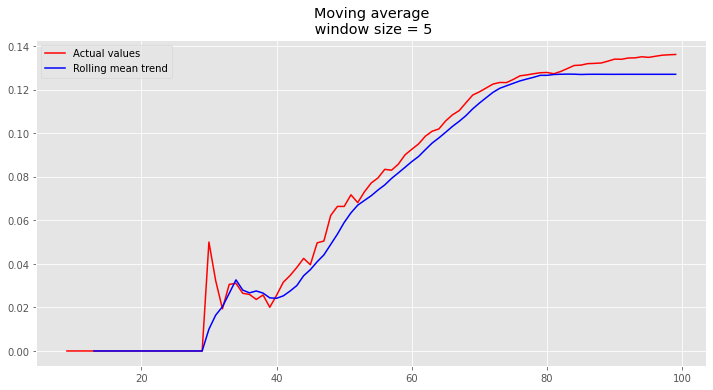

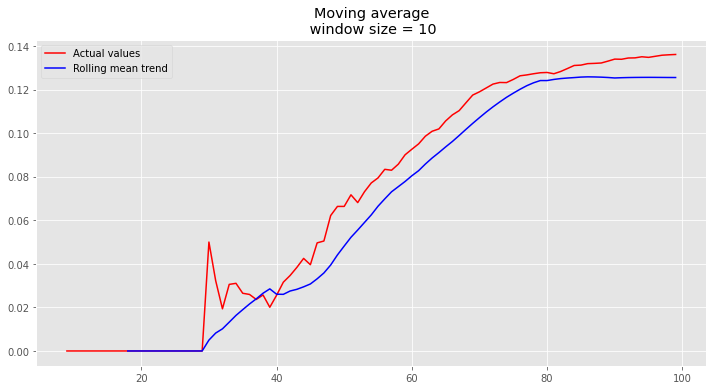

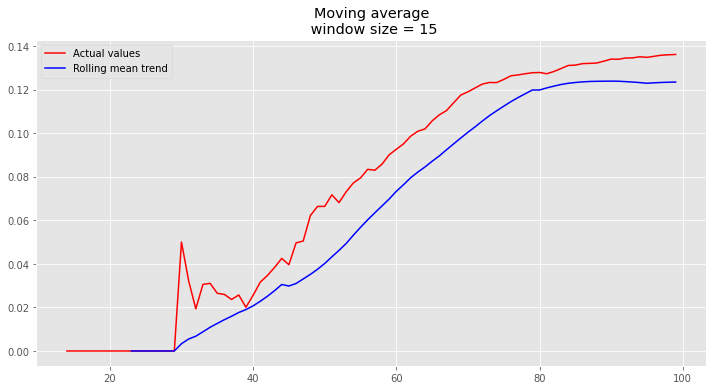

In [ ]:
df_italy_100['MovAverModel_1'] = MA(df_italy_100, 5)
df_italy_100['MovAverModel_2'] = MA(df_italy_100, 10)
df_italy_100['MovAverModel_3'] = MA(df_italy_100, 15)

In [ ]:
# Качество на тесте
MovAverModel_1_RMSE_it = RMSE(df_italy_100.iloc[80:100]['Deaths/Confirmed'], df_italy_100.iloc[80:100]['MovAverModel_1'])
MovAverModel_2_RMSE_it = RMSE(df_italy_100.iloc[80:100]['Deaths/Confirmed'], df_italy_100.iloc[80:100]['MovAverModel_2'])
MovAverModel_3_RMSE_it = RMSE(df_italy_100.iloc[80:100]['Deaths/Confirmed'], df_italy_100.iloc[80:100]['MovAverModel_3'])

MovAverModel_1_RMSE_it, MovAverModel_2_RMSE_it, MovAverModel_3_RMSE_it 

(0.006322624662356192, 0.0076986654732283865, 0.009950258617021398)

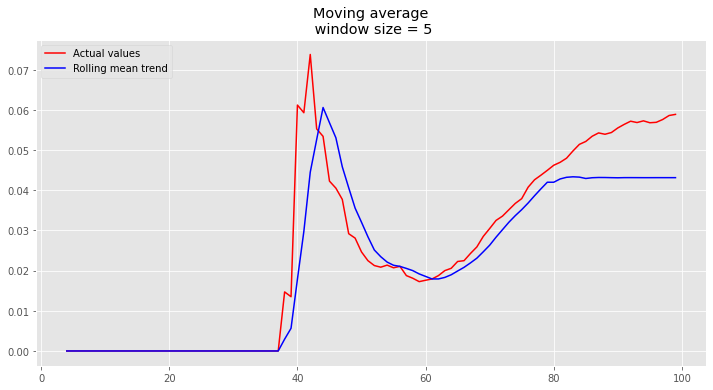

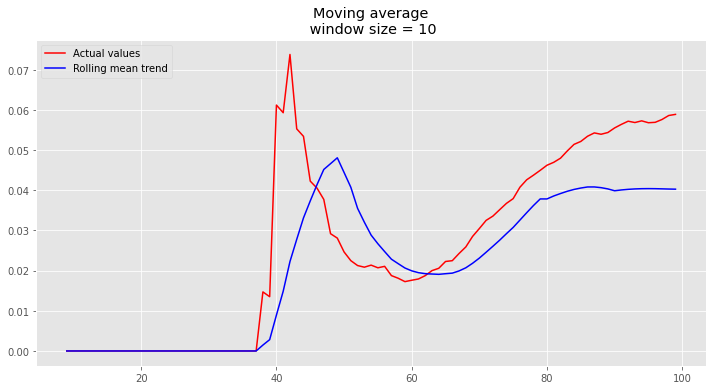

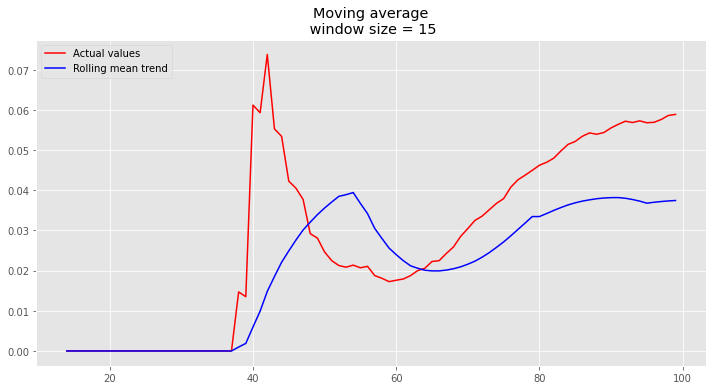

In [ ]:
df_us_100['MovAverModel_1'] = MA(df_us_100, 5)
df_us_100['MovAverModel_2'] = MA(df_us_100, 10)
df_us_100['MovAverModel_3'] = MA(df_us_100, 15)

In [ ]:
# Качество на тесте
MovAverModel_1_RMSE_us = RMSE(df_us_100.iloc[80:100]['Deaths/Confirmed'], df_us_100.iloc[80:100]['MovAverModel_1'])
MovAverModel_2_RMSE_us = RMSE(df_us_100.iloc[80:100]['Deaths/Confirmed'], df_us_100.iloc[80:100]['MovAverModel_2'])
MovAverModel_3_RMSE_us = RMSE(df_us_100.iloc[80:100]['Deaths/Confirmed'], df_us_100.iloc[80:100]['MovAverModel_3'])

MovAverModel_1_RMSE_us, MovAverModel_2_RMSE_us, MovAverModel_3_RMSE_us 

(0.011645854103445555, 0.014445249949400697, 0.017480482757342857)

Поэксперементируйте с гиперпараметрами модели.

#### 2.5 Авторегрессионная модель (AR - Autoregressive model)

Поэксперементируйте с гиперпараметрами модели.

In [ ]:
from statsmodels.tsa.arima_model import ARMA

In [ ]:
def ARModel(dataframe, p, q):
  case_day = int(df_ext[df_ext['Country/Region'] == dataframe.index[0][1]]['First_case_n'].values)
  dataframe_train = dataframe.iloc[case_day:80]['Deaths/Confirmed']
  dataframe_test = dataframe.iloc[80:100]['Deaths/Confirmed'] 

  fit1 = ARMA(dataframe_train, (p, q)).fit()
  pred1 = fit1.predict(case_day, 99)
  
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.plot(np.arange(case_day, 100), dataframe['Deaths/Confirmed'].iloc[case_day:].values)
  ax.plot(np.arange(case_day, 100), pred1, color='blue')

  plt.title("Autoregression Model")    
  plt.legend();
  return list(np.zeros(case_day)) + list(pred1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-

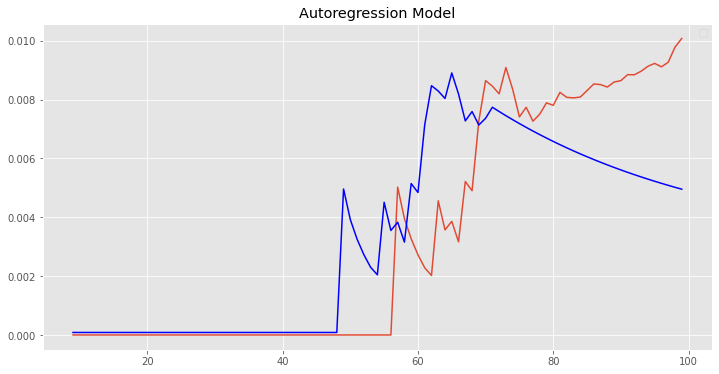

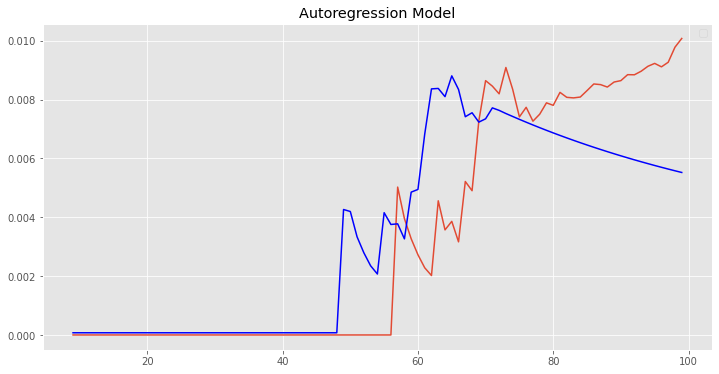

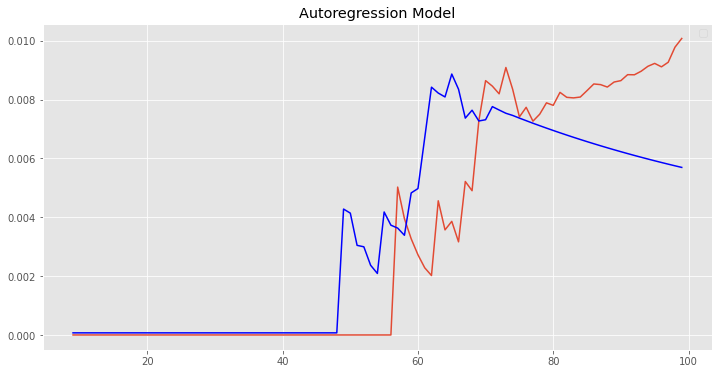

In [ ]:
df_russia_100['ARModel_1'] = ARModel(df_russia_100, 1, 0)
df_russia_100['ARModel_2'] = ARModel(df_russia_100, 3, 0)
df_russia_100['ARModel_3'] = ARModel(df_russia_100, 5, 0)

In [ ]:
# Качество на тесте
ARModel_1_RMSE_ru = RMSE(df_russia_100.iloc[80:100]['Deaths/Confirmed'], df_russia_100.iloc[80:100]['ARModel_1'])
ARModel_2_RMSE_ru = RMSE(df_russia_100.iloc[80:100]['Deaths/Confirmed'], df_russia_100.iloc[80:100]['ARModel_2'])
ARModel_3_RMSE_ru = RMSE(df_russia_100.iloc[80:100]['Deaths/Confirmed'], df_russia_100.iloc[80:100]['ARModel_3'])

ARModel_1_RMSE_ru, ARModel_2_RMSE_ru, ARModel_3_RMSE_ru 

(0.003209757664919974, 0.002752782840974764, 0.002618148626711452)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-

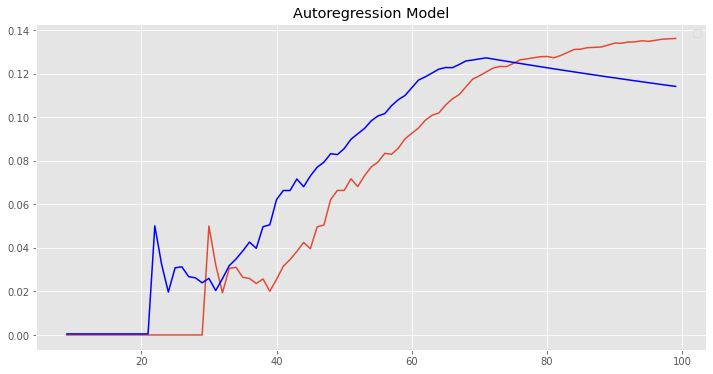

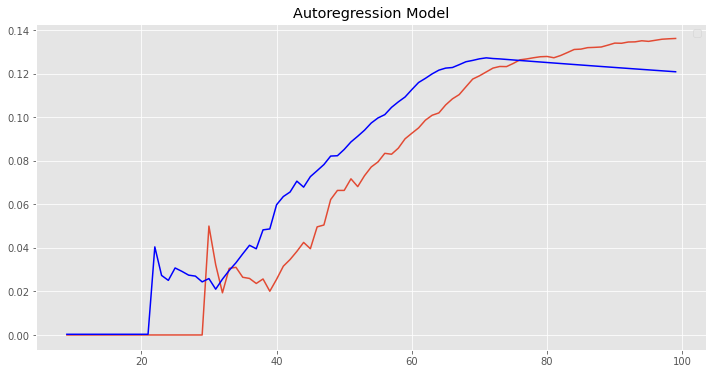

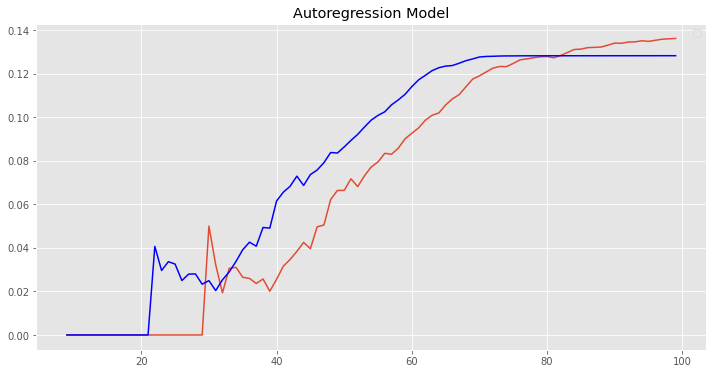

In [ ]:
df_italy_100['ARModel_1'] = ARModel(df_italy_100, 1, 0)
df_italy_100['ARModel_2'] = ARModel(df_italy_100, 3, 0)
df_italy_100['ARModel_3'] = ARModel(df_italy_100, 5, 0)

In [ ]:
# Качество на тесте
ARModel_1_RMSE_it = RMSE(df_italy_100.iloc[80:100]['Deaths/Confirmed'], df_italy_100.iloc[80:100]['ARModel_1'])
ARModel_2_RMSE_it = RMSE(df_italy_100.iloc[80:100]['Deaths/Confirmed'], df_italy_100.iloc[80:100]['ARModel_2'])
ARModel_3_RMSE_it = RMSE(df_italy_100.iloc[80:100]['Deaths/Confirmed'], df_italy_100.iloc[80:100]['ARModel_3'])

ARModel_1_RMSE_it, ARModel_2_RMSE_it, ARModel_3_RMSE_it 

(0.015362325748669343, 0.010564521105990142, 0.005276562486068462)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-

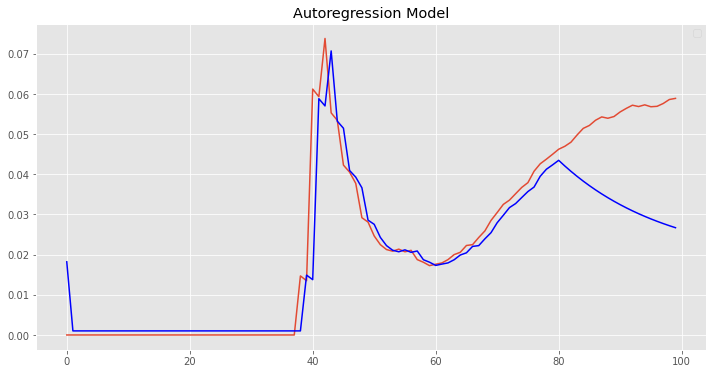

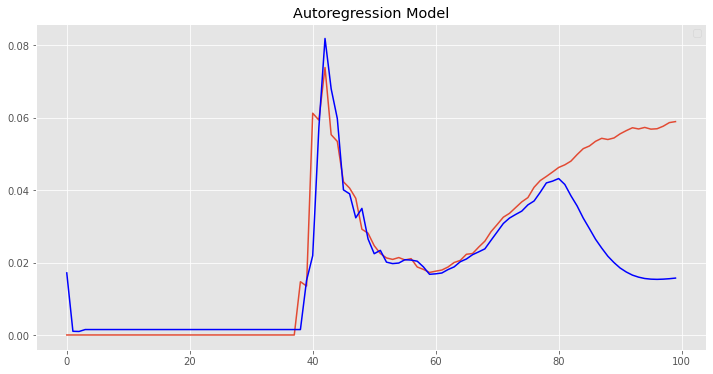

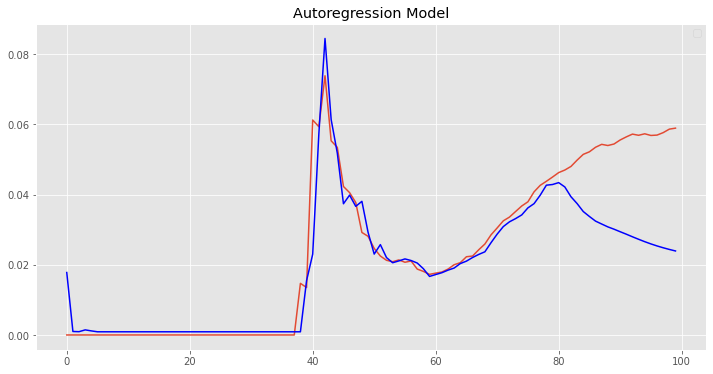

In [ ]:
df_us_100['ARModel_1'] = ARModel(df_us_100, 1, 0)
df_us_100['ARModel_2'] = ARModel(df_us_100, 3, 0)
df_us_100['ARModel_3'] = ARModel(df_us_100, 5, 0)

In [ ]:
# Качество на тесте
ARModel_1_RMSE_us = RMSE(df_us_100.iloc[80:100]['Deaths/Confirmed'], df_us_100.iloc[80:100]['ARModel_1'])
ARModel_2_RMSE_us = RMSE(df_us_100.iloc[80:100]['Deaths/Confirmed'], df_us_100.iloc[80:100]['ARModel_2'])
ARModel_3_RMSE_us = RMSE(df_us_100.iloc[80:100]['Deaths/Confirmed'], df_us_100.iloc[80:100]['ARModel_3'])

ARModel_1_RMSE_us, ARModel_2_RMSE_us, ARModel_3_RMSE_us 

(0.02228165685068477, 0.033170363059003546, 0.02499671467785411)

#### 2.6 ARMA

Поэксперементируйте с гиперпараметрами модели.

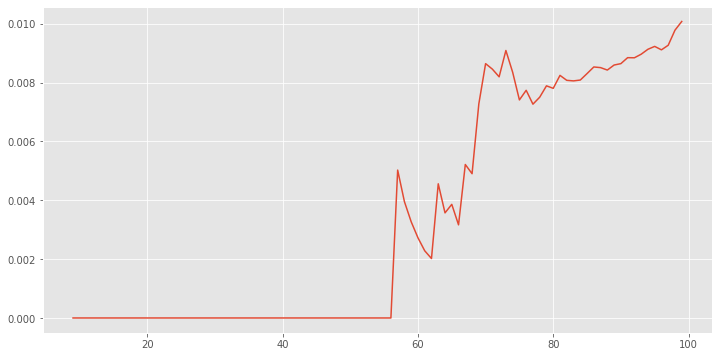

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_russia_100['Deaths/Confirmed'].iloc[:100].values)

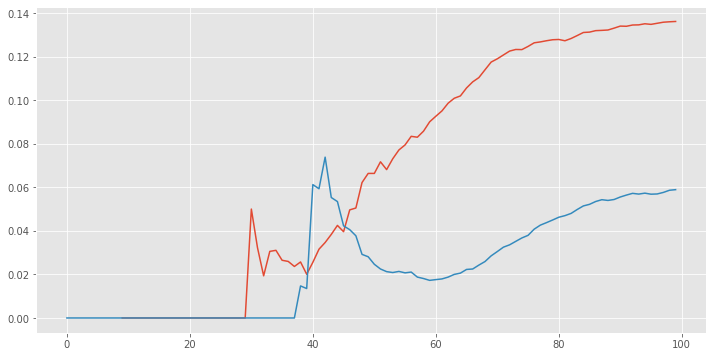

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(np.arange(100), df_italy_100['Deaths/Confirmed'].iloc[:100].values)
ax.plot(np.arange(100), df_us_100['Deaths/Confirmed'].iloc[:100].values)


In [ ]:
def AdfullerTest(dataframe):
  case_day = int(df_ext[df_ext['Country/Region'] == dataframe.index[0][1]]['First_case_n'].values)
  dataframe = dataframe.iloc[case_day:100]['Deaths/Confirmed'] 
  test_lags = sma.tsa.adfuller(dataframe.values)
  print ('adf: ', test_lags[0]) 
  print ('p-value: ', test_lags[1])
  print('Critical values: ', test[4])
  if test_lags[0]> test_lags[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен')
  else:
    print ('Единичных корней нет, ряд стационарен')

In [ ]:
AdfullerTest(df_russia_100)

adf:  -0.015604583294997412
p-value:  0.9572224150045562
Critical values:  {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
Есть единичные корни, ряд не стационарен


In [ ]:
AdfullerTest(df_italy_100)

adf:  -0.5963406360106447
p-value:  0.8718067511176046
Critical values:  {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
Есть единичные корни, ряд не стационарен


In [ ]:
AdfullerTest(df_us_100)

adf:  -1.2555679922016496
p-value:  0.6492471244429218
Critical values:  {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
Есть единичные корни, ряд не стационарен


Все 3 ряда не стационарные, нарушается одна из предпосылок ARMA. Дифференцирование приведет к модели ARIMA. Логарифмирование тоже не особо изменит что-то, как и преобразование Бокса-Кокса.

#### 2.7 Интегрированная модель авторегрессии — скользящего среднего (Auto Regressive Integrated Moving Average)

In [ ]:
def Delta(dataframe):
  diff = [0]

  for i in range(len(dataframe['Deaths/Confirmed'])):
    if pd.isna(dataframe['Deaths/Confirmed']).values[:100][i] == True:
      dataframe.iloc[i] = 0 

  for i in range(99):
    diff.append(dataframe['Deaths/Confirmed'].values[i+1]-dataframe['Deaths/Confirmed'].values[i])
  dataframe["Delta_1"] = diff

  plt.figure(figsize=(20, 8))
  plt.plot(np.arange(100), dataframe['Delta_1'].values, c ='red')

  plt.ylabel('Delta of first order')
  plt.xlabel("Day number")

  plt.show()
  return dataframe

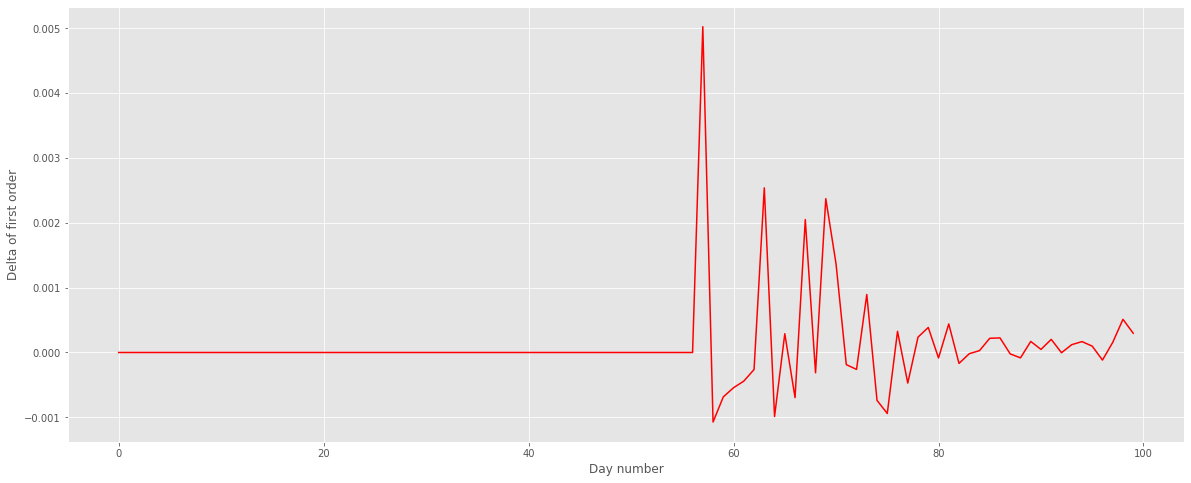

Lat  Long  Confirmed  ...  ARModel_2  ARModel_3  Delta_1
Date       Country/Region                         ...                               
2020-01-22 Russia          0.00  0.00       0.00  ...       0.00       0.00     0.00
2020-01-23 Russia          0.00  0.00       0.00  ...       0.00       0.00     0.00
2020-01-24 Russia          0.00  0.00       0.00  ...       0.00       0.00     0.00
2020-01-25 Russia          0.00  0.00       0.00  ...       0.00       0.00     0.00
2020-01-26 Russia          0.00  0.00       0.00  ...       0.00       0.00     0.00
...                         ...   ...        ...  ...        ...        ...      ...
2020-04-26 Russia         60.00 90.00   80949.00  ...       0.01       0.01     0.00
2020-04-27 Russia         60.00 90.00   87147.00  ...       0.01       0.01    -0.00
2020-04-28 Russia         60.00 90.00   93558.00  ...       0.01       0.01     0.00
2020-04-29 Russia         60.00 90.00   99399.00  ...       0.01       0.01     0.00
2020-04-30 Russia         60.00 90.00  106498.00  ...       0.01       0.01     0.00

[100 rows x 29 columns]

In [ ]:
Delta(df_russia_100)

In [ ]:
test_lags = sma.tsa.adfuller(df_russia_100.Delta_1.values)
print ('adf: ', test_lags[0]) 
print ('p-value: ', test_lags[1])
print('Critical values: ', test[4])
if test_lags[0]> test_lags[4]['5%']: 
  print ('Есть единичные корни, ряд не стационарен')
else:
  print ('Единичных корней нет, ряд стационарен')

adf:  -3.664734567740902
p-value:  0.0046374435122354
Critical values:  {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
Единичных корней нет, ряд стационарен


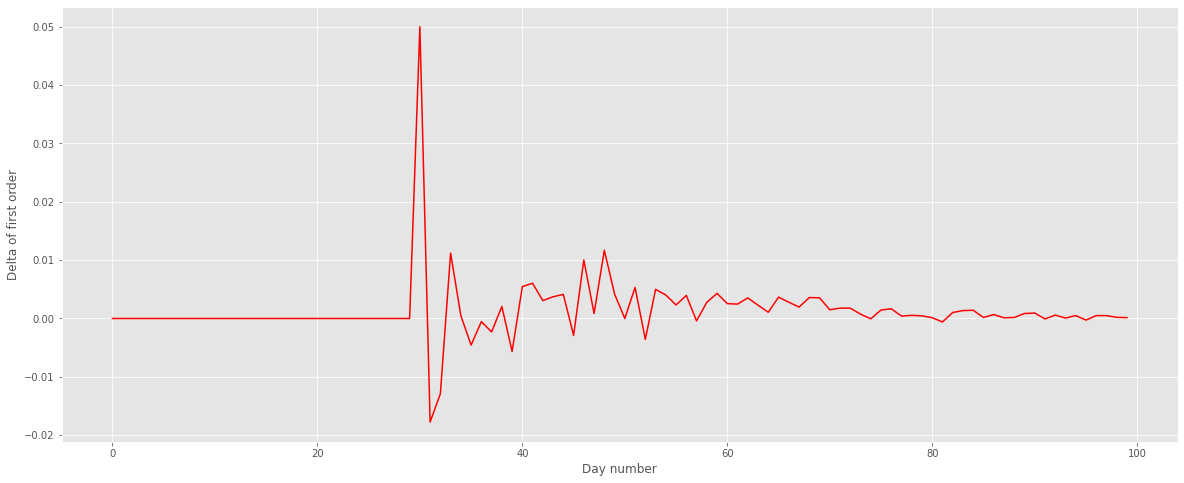

Lat  Long  Confirmed  ...  ARModel_2  ARModel_3  Delta_1
Date       Country/Region                         ...                               
2020-01-22 Italy           0.00  0.00       0.00  ...       0.00       0.00     0.00
2020-01-23 Italy           0.00  0.00       0.00  ...       0.00       0.00     0.00
2020-01-24 Italy           0.00  0.00       0.00  ...       0.00       0.00     0.00
2020-01-25 Italy           0.00  0.00       0.00  ...       0.00       0.00     0.00
2020-01-26 Italy           0.00  0.00       0.00  ...       0.00       0.00     0.00
...                         ...   ...        ...  ...        ...        ...      ...
2020-04-26 Italy          43.00 12.00  197675.00  ...       0.12       0.13    -0.00
2020-04-27 Italy          43.00 12.00  199414.00  ...       0.12       0.13     0.00
2020-04-28 Italy          43.00 12.00  201505.00  ...       0.12       0.13     0.00
2020-04-29 Italy          43.00 12.00  203591.00  ...       0.12       0.13     0.00
2020-04-30 Italy          43.00 12.00  205463.00  ...       0.12       0.13     0.00

[100 rows x 28 columns]

In [ ]:
Delta(df_italy_100)

In [ ]:
test_lags = sma.tsa.adfuller(df_italy_100.Delta_1.values)
print ('adf: ', test_lags[0]) 
print ('p-value: ', test_lags[1])
print('Critical values: ', test[4])
if test_lags[0]> test_lags[4]['5%']: 
  print ('Есть единичные корни, ряд не стационарен')
else:
  print ('Единичных корней нет, ряд стационарен')

adf:  -10.068901477508511
p-value:  1.2743691768136088e-17
Critical values:  {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
Единичных корней нет, ряд стационарен


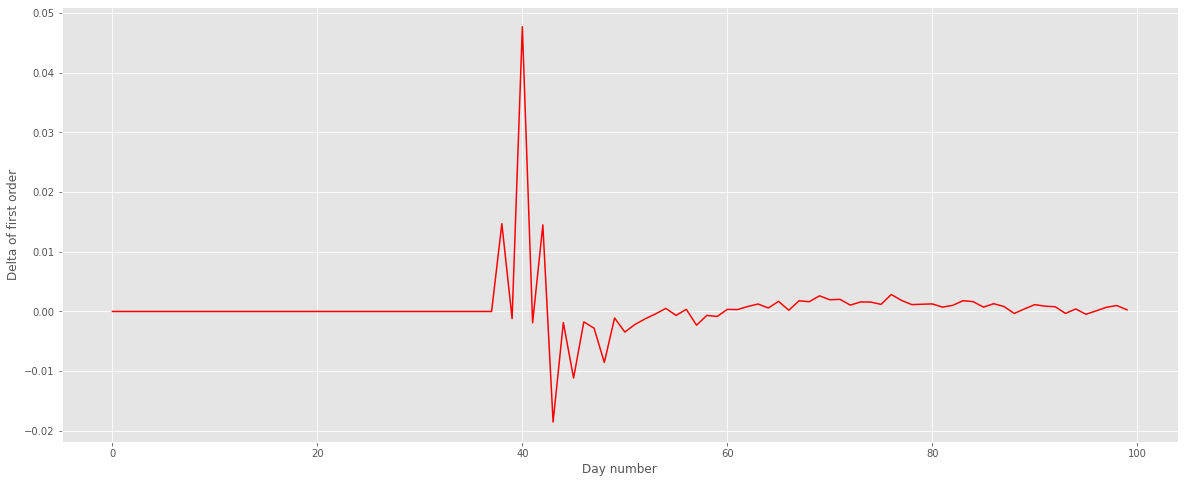

Lat   Long  ...  ARModel_3  Delta_1
Date       Country/Region               ...                    
2020-01-22 US             37.09 -95.71  ...       0.02     0.00
2020-01-23 US             37.09 -95.71  ...       0.00     0.00
2020-01-24 US             37.09 -95.71  ...       0.00     0.00
2020-01-25 US             37.09 -95.71  ...       0.00     0.00
2020-01-26 US             37.09 -95.71  ...       0.00     0.00
...                         ...    ...  ...        ...      ...
2020-04-26 US             37.09 -95.71  ...       0.03    -0.00
2020-04-27 US             37.09 -95.71  ...       0.03     0.00
2020-04-28 US             37.09 -95.71  ...       0.02     0.00
2020-04-29 US             37.09 -95.71  ...       0.02     0.00
2020-04-30 US             37.09 -95.71  ...       0.02     0.00

[100 rows x 28 columns]

In [ ]:
Delta(df_us_100)

In [ ]:
test_lags = sma.tsa.adfuller(df_us_100.Delta_1.values)
print ('adf: ', test_lags[0]) 
print ('p-value: ', test_lags[1])
print('Critical values: ', test[4])
if test_lags[0]> test_lags[4]['5%']: 
  print ('Есть единичные корни, ряд не стационарен')
else:
  print ('Единичных корней нет, ряд стационарен')

adf:  -5.753255940623746
p-value:  5.899294919067587e-07
Critical values:  {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
Единичных корней нет, ряд стационарен


Параметр d в АRIMA для России, Италии и США будет равен 1

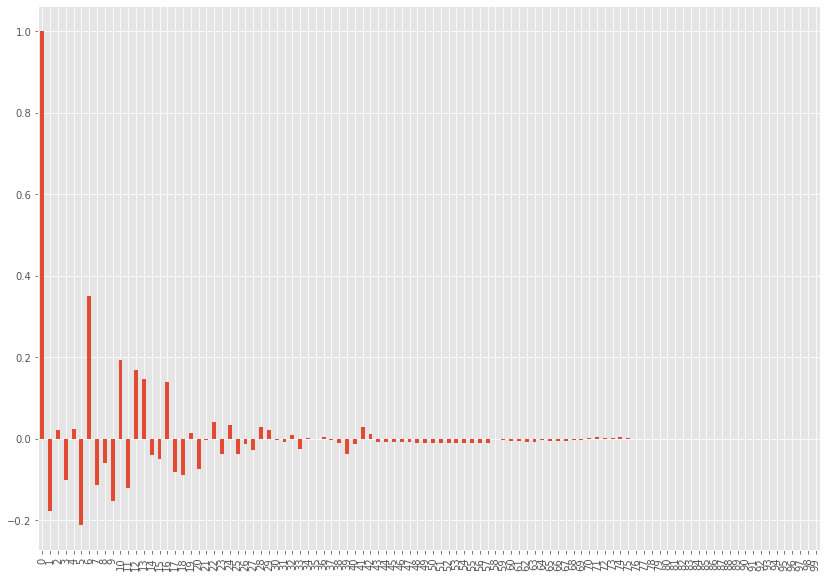

In [ ]:
lag_acf = acf(df_russia_100.Delta_1.values, nlags=99)
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar")

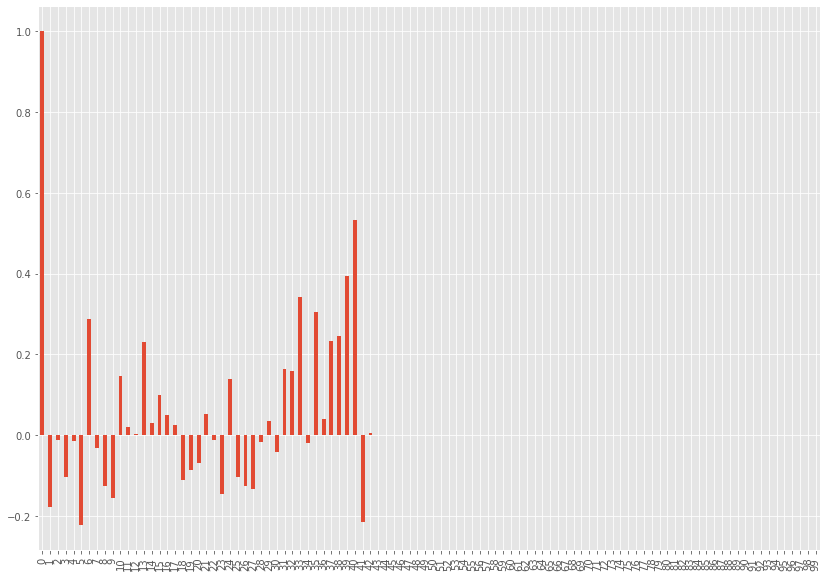

In [ ]:
lag_pacf = pacf(df_russia_100.Delta_1.values, nlags=99, method='ols')
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar")

Строить ARIMA(1, 1, 30+) не имеет смысла, так как значим только 1 и 2 лаг  и какие-то из лагов с 30 по 40 в МА части. 1, 6 и 7 лаги в AR части значимы. Буду строить ARIMA(1, 1, 1) и ARIMA(7, 1, 1) для России.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

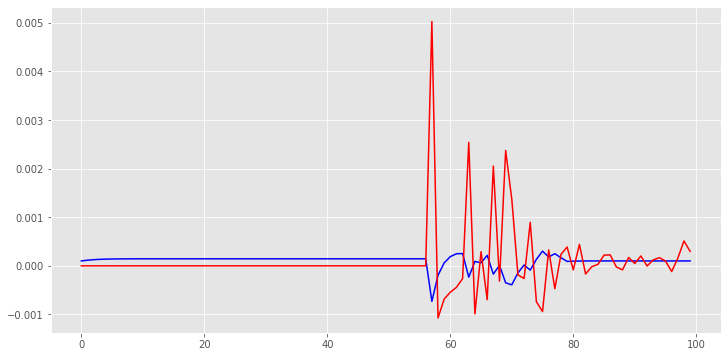

In [ ]:
ARIMAModel_1_ru = ARIMA(df_russia_100['Deaths/Confirmed'].values[:80], order=(1,1,1))
results_ARIMA_1_ru = ARIMAModel_1_ru.fit()
df_russia_100['ARIMA_1'] = results_ARIMA_1_ru.predict(1, 100)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_russia_100['ARIMA_1'], color ='blue')
ax.plot(np.arange(100), df_russia_100.Delta_1.values, color ='red')


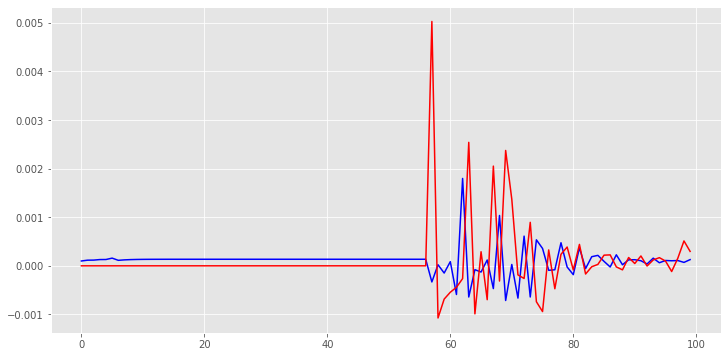

In [ ]:
ARIMAModel_2_ru = ARIMA(df_russia_100['Deaths/Confirmed'].values[:80], order=(7,1,1))
results_ARIMA_2_ru = ARIMAModel_2_ru.fit()
df_russia_100['ARIMA_2'] = results_ARIMA_2_ru.predict(1, 100)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_russia_100['ARIMA_2'], color ='blue')
ax.plot(np.arange(100), df_russia_100.Delta_1.values, color ='red')


In [ ]:
# Качество на тесте
ARIMA_1_RMSE_ru = RMSE(df_russia_100.iloc[80:99]['Delta_1'], df_russia_100.iloc[80:]['ARIMA_1'])
ARIMA_2_RMSE_ru = RMSE(df_russia_100.iloc[80:99]['Delta_1'], df_russia_100.iloc[80:99]['ARIMA_2'])

ARIMA_1_RMSE_ru, ARIMA_2_RMSE_ru

(0.00017355102037327756, 0.00016750151743973518)

2 модель лучше

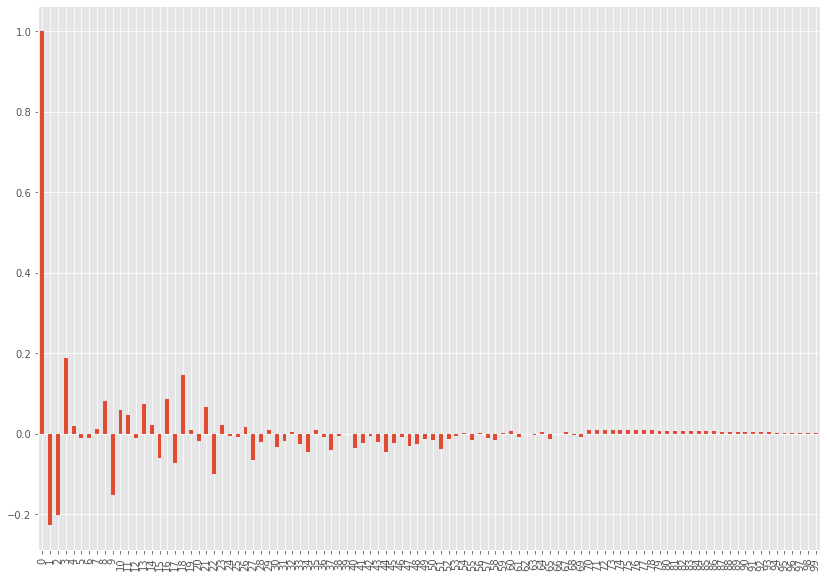

In [ ]:
lag_acf = acf(df_italy_100.Delta_1.values, nlags=99)
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar")

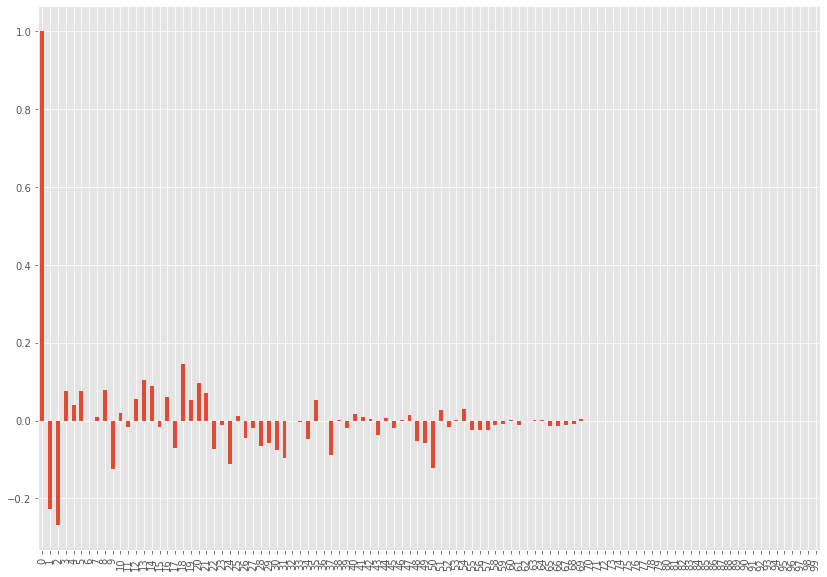

In [ ]:
lag_pacf = pacf(df_italy_100.Delta_1.values, nlags=99, method='ols')
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar")

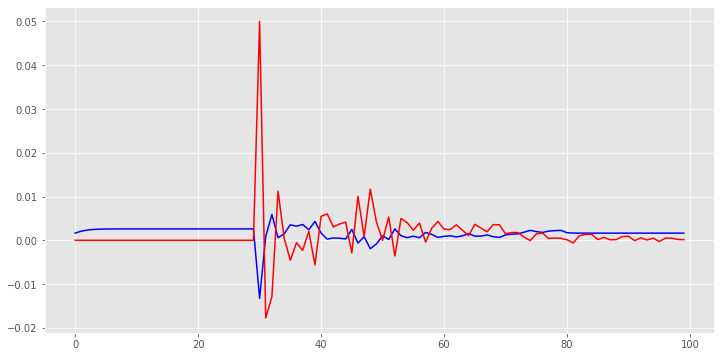

In [ ]:
ARIMAModel_1_it = ARIMA(df_italy_100['Deaths/Confirmed'].values[:80], order=(1,1,1))
results_ARIMA_1_it = ARIMAModel_1_it.fit()
df_italy_100['ARIMA_1'] = results_ARIMA_1_it.predict(1, 100)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_italy_100['ARIMA_1'], color ='blue')
ax.plot(np.arange(100), df_italy_100.Delta_1.values, color ='red')


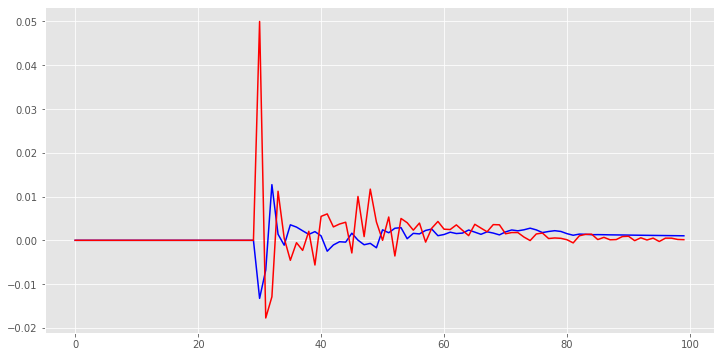

In [ ]:
ARIMAModel_2_it = ARIMA(df_italy_100['Deaths/Confirmed'].values[:80], order=(3,1,3))
results_ARIMA_2_it = ARIMAModel_2_it.fit(trend='nc')
df_italy_100['ARIMA_2'] = results_ARIMA_2_it.predict(1, 100)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_italy_100['ARIMA_2'], color ='blue')
ax.plot(np.arange(100), df_italy_100.Delta_1.values, color ='red')


In [ ]:
# Качество на тесте
ARIMA_1_RMSE_it = RMSE(df_italy_100.iloc[80:99]['Delta_1'], df_italy_100.iloc[80:]['ARIMA_1'])
ARIMA_2_RMSE_it = RMSE(df_italy_100.iloc[80:99]['Delta_1'], df_italy_100.iloc[80:99]['ARIMA_2'])

ARIMA_1_RMSE_it, ARIMA_2_RMSE_it

(0.0013181793238126423, 0.0009211329082284458)

2 модель лучше

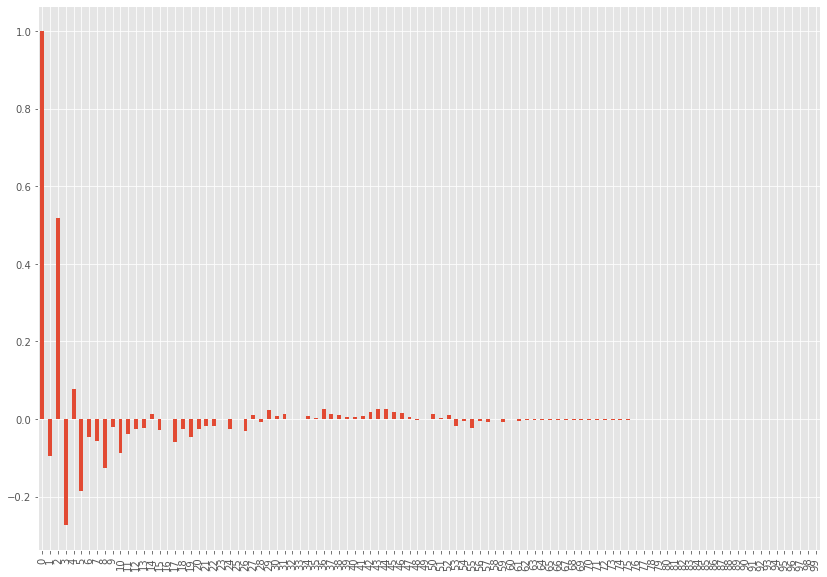

In [ ]:
lag_acf = acf(df_us_100.Delta_1.values, nlags=99)
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar")

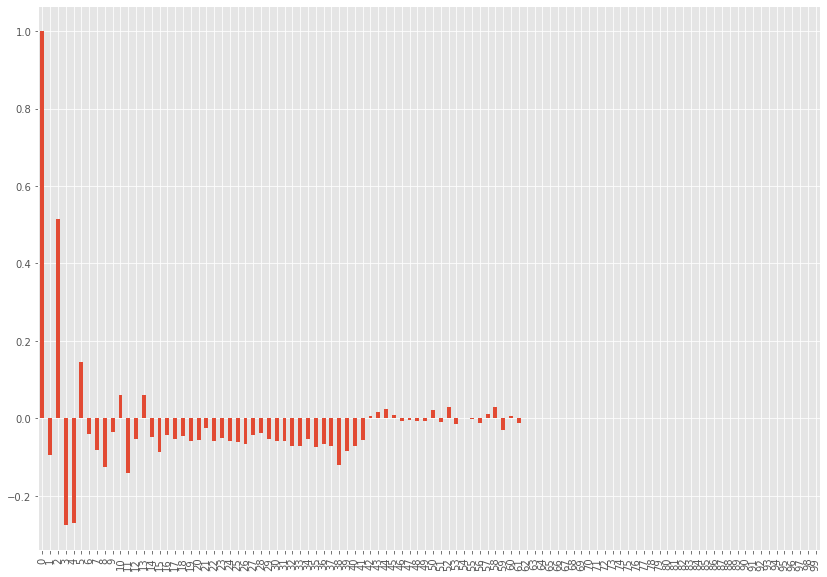

In [ ]:
lag_pacf = pacf(df_us_100.Delta_1.values, nlags=99, method='ols')
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar")

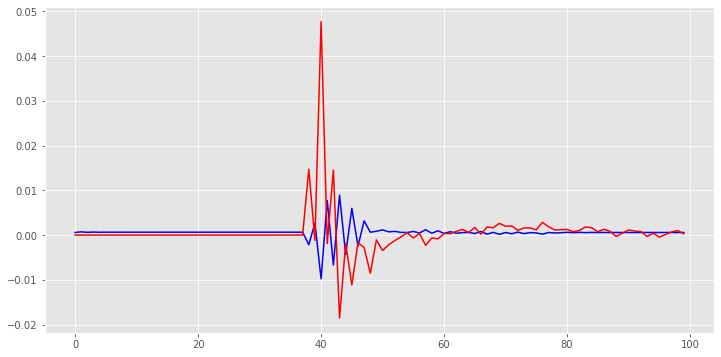

In [ ]:
ARIMAModel_1_us = ARIMA(df_us_100['Deaths/Confirmed'].values[:80], order=(1,1,1))
results_ARIMA_1_us = ARIMAModel_1_us.fit()
df_us_100['ARIMA_1'] = results_ARIMA_1_us.predict(1, 100)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_us_100['ARIMA_1'], color ='blue')
ax.plot(np.arange(100), df_us_100.Delta_1.values, color ='red')


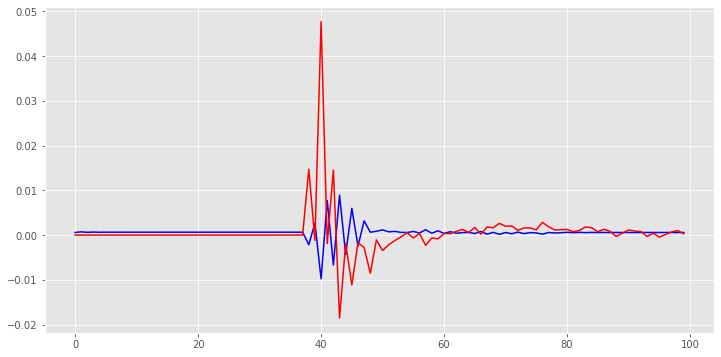

In [ ]:
ARIMAModel_2_us = ARIMA(df_us_100['Deaths/Confirmed'].values[:80], order=(4,1,5))
results_ARIMA_2_us = ARIMAModel_1_us.fit(trend='nc')
df_us_100['ARIMA_2'] = results_ARIMA_1_us.predict(1, 100)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_us_100['ARIMA_1'], color ='blue')
ax.plot(np.arange(100), df_us_100.Delta_1.values, color ='red')


In [ ]:
# Качество на тесте
ARIMA_1_RMSE_us = RMSE(df_us_100.iloc[80:99]['Delta_1'], df_us_100.iloc[80:]['ARIMA_1'])
ARIMA_2_RMSE_us = RMSE(df_us_100.iloc[80:99]['Delta_1'], df_us_100.iloc[80:99]['ARIMA_2'])

ARIMA_1_RMSE_us, ARIMA_2_RMSE_us

(0.0006318556648929951, 0.0009466686876802567)

1  модель лучше

Сравнивать RMSE ARIMA с другими моделями нет смысла, так как она строится на разностях 1 порядка.

2.8 SARIMA

Смысл строить SARIMA нет, все что будет построено не имеет логики и интерпретации. Сделаю интерпретацию как только на арену выйдет COVID-20. Рассматривать дни и недели как сезоны - плохая идея.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


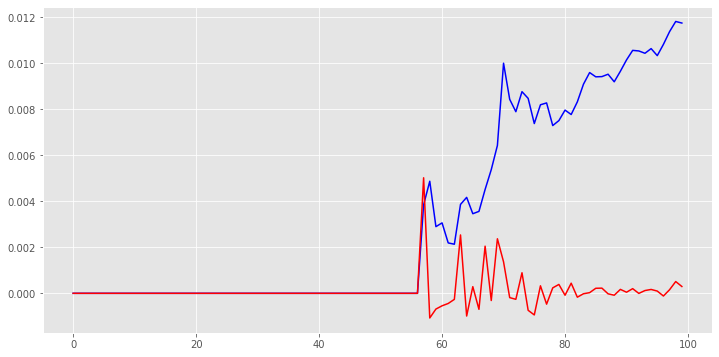

In [ ]:
SARIMAModel_1_ru = SARIMAX(df_russia_100['Deaths/Confirmed'].values[:80], order=(1,1,1), seasonal_order=(1, 1, 1, 7))
results_SARIMA_1_ru = SARIMAModel_1_ru.fit()
df_russia_100['SARIMA_1'] = results_SARIMA_1_ru.predict(1, 100)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_russia_100['SARIMA_1'], color ='blue')
ax.plot(np.arange(100), df_russia_100.Delta_1.values, color ='red')


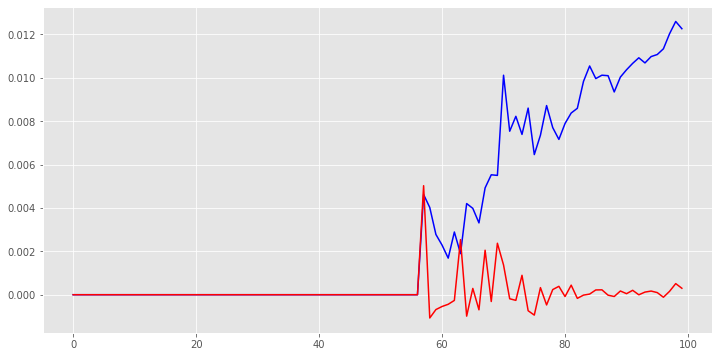

In [ ]:
SARIMAModel_2_ru = SARIMAX(df_russia_100['Deaths/Confirmed'].values[:80], order=(7,1,1), seasonal_order=(1, 1, 1, 7))
results_SARIMA_2_ru = SARIMAModel_2_ru.fit()
df_russia_100['SARIMA_2'] = results_SARIMA_2_ru.predict(1, 100)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_russia_100['SARIMA_2'], color ='blue')
ax.plot(np.arange(100), df_russia_100.Delta_1.values, color ='red')


In [ ]:
# Качество на тесте
SARIMA_1_RMSE_ru = RMSE(df_russia_100.iloc[80:99]['Delta_1'], df_russia_100.iloc[80:]['SARIMA_1'])
SARIMA_2_RMSE_ru = RMSE(df_russia_100.iloc[80:99]['Delta_1'], df_russia_100.iloc[80:99]['SARIMA_2'])

SARIMA_1_RMSE_ru, SARIMA_2_RMSE_ru

(0.009781330316425231, 0.010246291020985147)

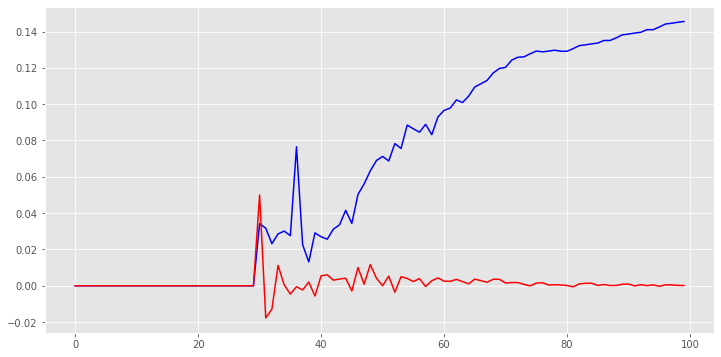

In [ ]:
SARIMAModel_1_it = SARIMAX(df_italy_100['Deaths/Confirmed'].values[:80], order=(1,1,1), seasonal_order=(0, 1, 0, 7))
results_SARIMA_1_it = SARIMAModel_1_it.fit()
df_italy_100['SARIMA_1'] = results_SARIMA_1_it.predict(1, 100)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_italy_100['SARIMA_1'], color ='blue')
ax.plot(np.arange(100), df_italy_100.Delta_1.values, color ='red')


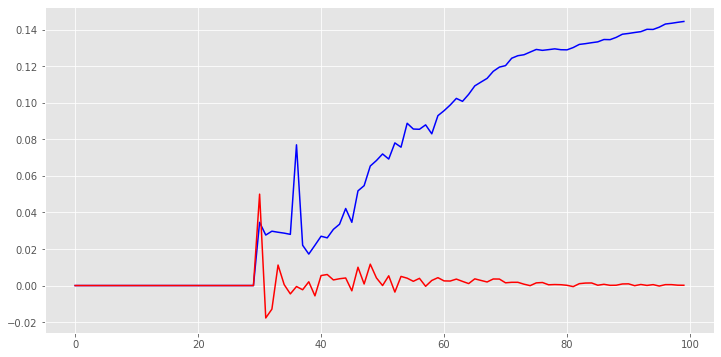

In [ ]:
SARIMAModel_2_it = SARIMAX(df_italy_100['Deaths/Confirmed'].values[:80], order=(3,1,3), seasonal_order=(0, 1, 0, 7))
results_SARIMA_2_it = SARIMAModel_2_it.fit(trend='nc')
df_italy_100['SARIMA_2'] = results_SARIMA_2_it.predict(1, 100)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_italy_100['SARIMA_2'], color ='blue')
ax.plot(np.arange(100), df_italy_100.Delta_1.values, color ='red')


In [ ]:
# Качество на тесте
SARIMA_1_RMSE_it = RMSE(df_italy_100.iloc[80:99]['Delta_1'], df_italy_100.iloc[80:]['SARIMA_1'])
SARIMA_2_RMSE_it = RMSE(df_italy_100.iloc[80:99]['Delta_1'], df_italy_100.iloc[80:99]['SARIMA_2'])

SARIMA_1_RMSE_it, SARIMA_2_RMSE_it

(0.13713353101577408, 0.13643786697136742)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


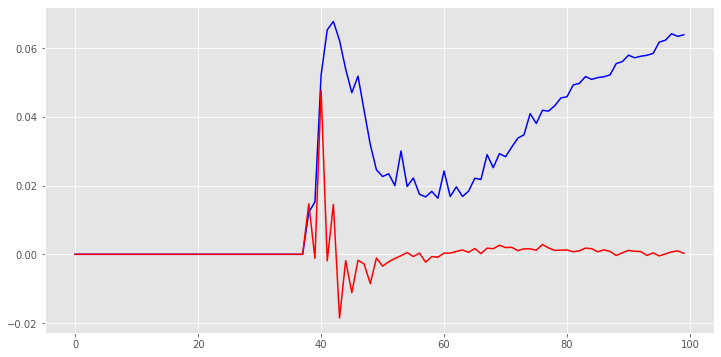

In [ ]:
SARIMAModel_1_us = SARIMAX(df_us_100['Deaths/Confirmed'].values[:80], order=(1,1,1), seasonal_order=(1, 1, 1, 7))
results_SARIMA_1_us = SARIMAModel_1_us.fit()
df_us_100['SARIMA_1'] = results_SARIMA_1_us.predict(1, 100)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_us_100['SARIMA_1'], color ='blue')
ax.plot(np.arange(100), df_us_100.Delta_1.values, color ='red')


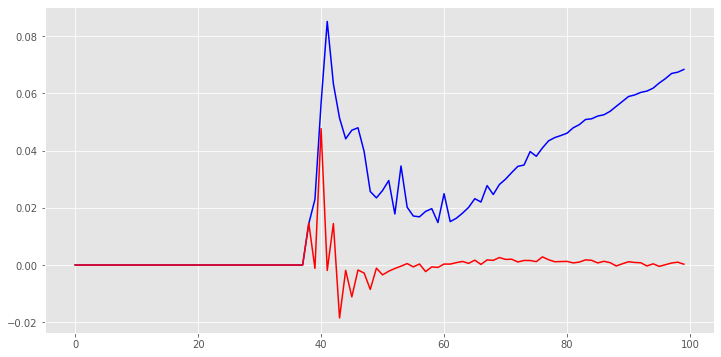

In [ ]:
SARIMAModel_2_us = SARIMAX(df_us_100['Deaths/Confirmed'].values[:80], order=(4,1,5), seasonal_order=(1, 1, 1, 7))
results_SARIMA_2_us = SARIMAModel_2_us.fit(trend='nc')
df_us_100['SARIMA_2'] = results_SARIMA_2_us.predict(1, 100)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_us_100['SARIMA_2'], color ='blue')
ax.plot(np.arange(100), df_us_100.Delta_1.values, color ='red')


In [ ]:
# Качество на тесте
SARIMA_1_RMSE_us = RMSE(df_us_100.iloc[80:99]['Delta_1'], df_us_100.iloc[80:]['SARIMA_1'])
SARIMA_2_RMSE_us = RMSE(df_us_100.iloc[80:99]['Delta_1'], df_us_100.iloc[80:99]['SARIMA_2'])

SARIMA_1_RMSE_us, SARIMA_2_RMSE_us

(0.05507152323367298, 0.05658764944106428)

#### 2.9 Библиотека Prophet
Попробуйте использовать библиотеку Prophet для предсказания временного ряда. [Документация](https://facebook.github.io/prophet/docs/quick_start.html).


In [ ]:
from fbprophet import Prophet


# Ваш код здесь

#### 2.10 Линейная модель с регрессией (Linear Regression Model)

Какие признаки оказались наиболее значимыми?

Есть смысл включать только признаки в динамике. Таких немного. Deaths, Confirmed, Recovered. Но 2 из них входят напрямую в расчет метрики, а другой косвенно выражается через них. Признак, который мог бы подойти это число тестов или число тестов на душу населения. Но я не нашел хорошей информации по числу ежедневных тестов в каждой из стран. Поэтому придется использовать то, что есть.

Кроме этого нам либо надо спрогнозировать наши признаки с помощью которых мы будем строить модель, либо предполагать, что они нам даны уже. Предполагать, что и Deaths, и Confirmed даны одновременно это глупо, так как тогда значение определяется точно и прогнозировать нечего. Предположим тогда, что нам даны только Recovered и надо посчитать значение метрики с помощью регрессии.

In [ ]:
def LinearRegressionModel(dataframe, features_list =['TimeIndex']):
  case_day = int(df_ext[df_ext['Country/Region'] == dataframe.index[0][1]]['First_case_n'].values)
  dataframe_train = dataframe.iloc[case_day:80]
  dataframe_test = dataframe.iloc[80:100]
  linear_model = sma.OLS(dataframe_train['Deaths/Confirmed'].values, dataframe_train[features_list].values).fit()
  linear_forecast_train = linear_model.predict()
  model_params = linear_model.params
  linear_forecast_test = np.dot(dataframe_test[features_list].values.reshape(-1, len(model_params)), model_params)
  if len(linear_forecast_train) == 80:
    return linear_forecast_train, linear_forecast_test
  if len(linear_forecast_train) != 80:
    return np.hstack((np.zeros(80-len(linear_forecast_train)), linear_forecast_train)), linear_forecast_test, model_params

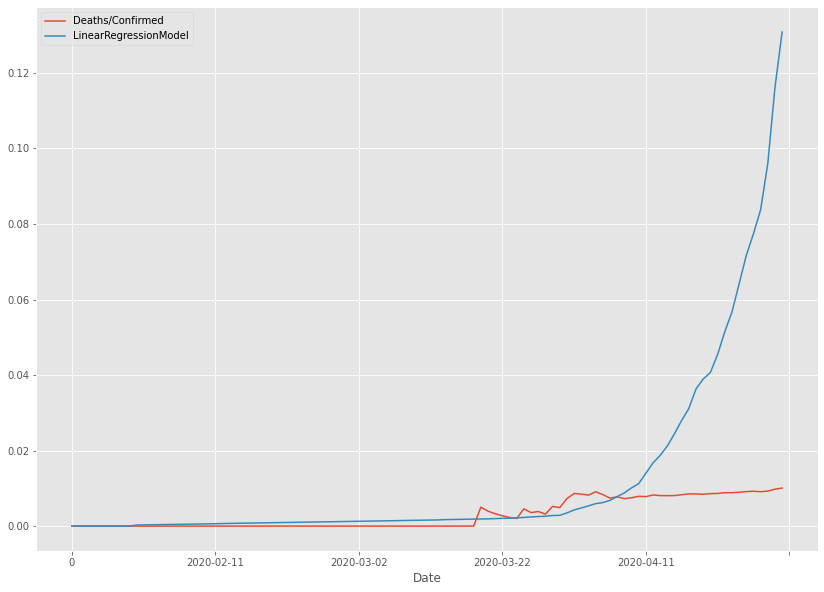

In [ ]:
df_russia_100['LinearRegressionModel'] = np.hstack((LinearRegressionModel(df_russia_100, ['TimeIndex', 'Recovered'])[0], 
                                                    LinearRegressionModel(df_russia_100, ['TimeIndex', 'Recovered'])[1]))
df_russia_100.plot(kind="line", x="Date", y = ["Deaths/Confirmed", "LinearRegressionModel"])


In [ ]:
# Качество на тесте
LinearRegressionModel_RMSE_ru = RMSE(df_russia_100.iloc[80:100]['Deaths/Confirmed'], df_russia_100.iloc[80:100]['LinearRegressionModel'])
LinearRegressionModel_RMSE_ru

0.05494555503756797

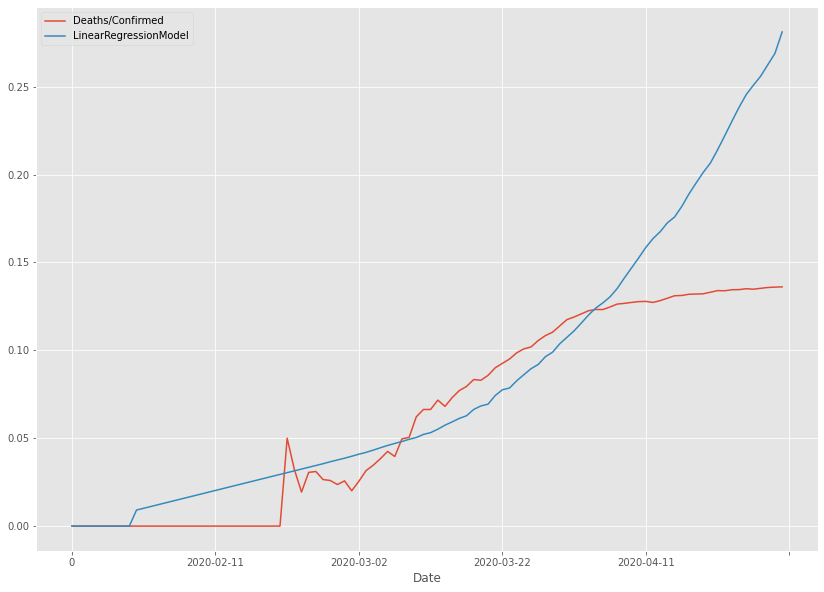

In [ ]:
df_italy_100['LinearRegressionModel'] = np.hstack((LinearRegressionModel(df_italy_100, ['TimeIndex', 'Recovered'])[0], 
                                                   LinearRegressionModel(df_italy_100, ['TimeIndex', 'Recovered'])[1]))
df_italy_100.plot(kind="line", x="Date", y = ["Deaths/Confirmed", "LinearRegressionModel"])


In [ ]:
# Качество на тесте
LinearRegressionModel_RMSE_it = RMSE(df_italy_100.iloc[80:100]['Deaths/Confirmed'], df_italy_100.iloc[80:100]['LinearRegressionModel'])
LinearRegressionModel_RMSE_it

0.08855766964417892

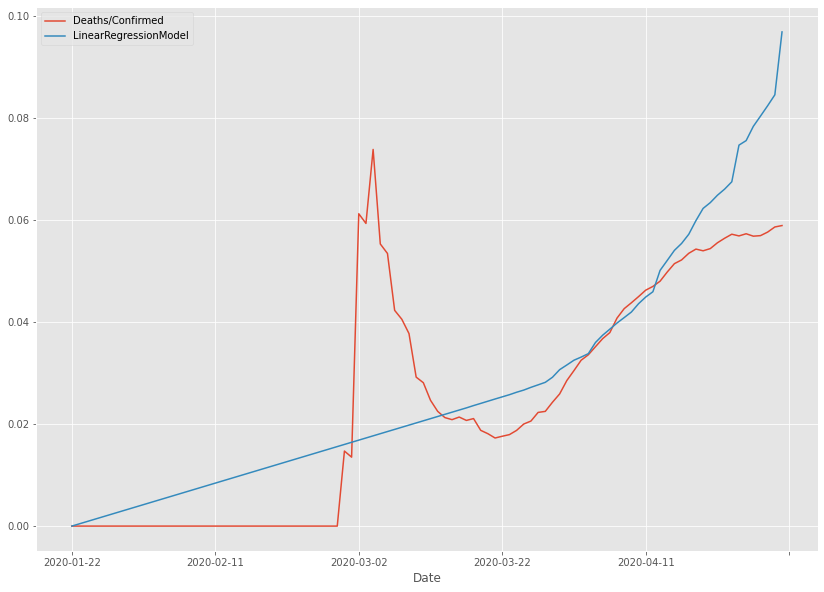

In [ ]:
df_us_100['LinearRegressionModel'] = np.hstack((LinearRegressionModel(df_us_100, ['TimeIndex', 'Recovered'])[0], 
                                                LinearRegressionModel(df_us_100, ['TimeIndex', 'Recovered'])[1]))
df_us_100.plot(kind="line", x="Date", y = ["Deaths/Confirmed", "LinearRegressionModel"])


In [ ]:
# Качество на тесте
LinearRegressionModel_RMSE_us = RMSE(df_us_100.iloc[80:100]['Deaths/Confirmed'], df_us_100.iloc[80:100]['LinearRegressionModel'])
LinearRegressionModel_RMSE_us 

0.01564878614928615

2.11 (Бонус) Используйте любую другую известную вам модель для предсказания.

![](https://lh3.googleusercontent.com/proxy/apcO3hDn7joDv-qU7Cz1gTc8zAvJpE3XmknjktN4OOyRnNwkcQf9nMfh26Be1McM9Hdd4PE3PP5ZIbUyvRb-q3wx-NE)

In [ ]:
df_russia_100.drop(columns = ['ARIMA_1', 'ARIMA_2', 'SARIMA_1', 'SARIMA_2', 'Delta_1'], inplace=True)
df_italy_100.drop(columns = ['ARIMA_1', 'ARIMA_2',  'SARIMA_1', 'SARIMA_2', 'Delta_1'], inplace = True)
df_us_100.drop(columns = ['ARIMA_1', 'ARIMA_2',  'SARIMA_1', 'SARIMA_2', 'Delta_1'], inplace = True)

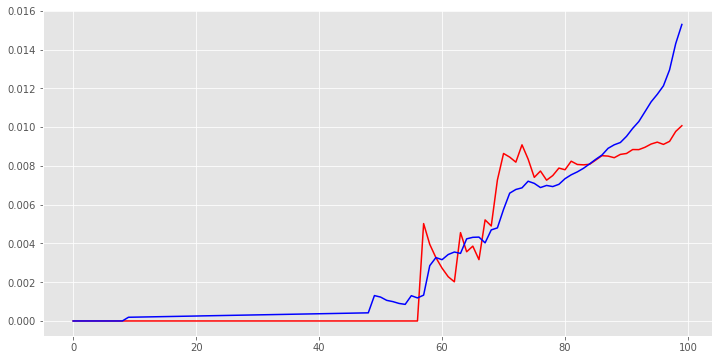

In [ ]:
ensemble_ru = np.mean(np.array(df_russia_100.loc[:, 'ConstantModel':'LinearRegressionModel'].values), axis = 1)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_russia_100['Deaths/Confirmed'].iloc[:100].values, color = 'red')
ax.plot(np.arange(100), ensemble_ru, color = 'blue')

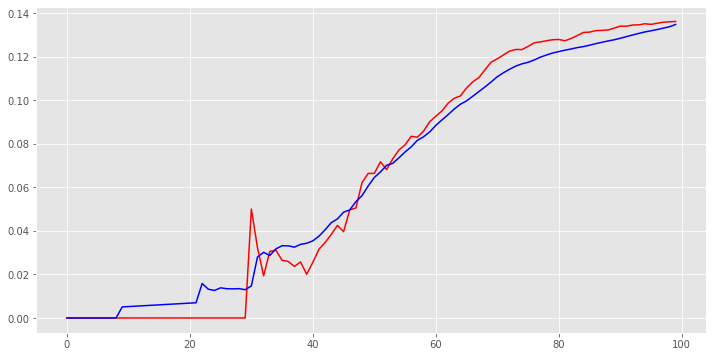

In [ ]:
ensemble_it = np.mean(np.array(df_italy_100.loc[:, 'ConstantModel':'LinearRegressionModel'].values), axis = 1)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_italy_100['Deaths/Confirmed'].iloc[:100].values, color = 'red')
ax.plot(np.arange(100), ensemble_it, color = 'blue')

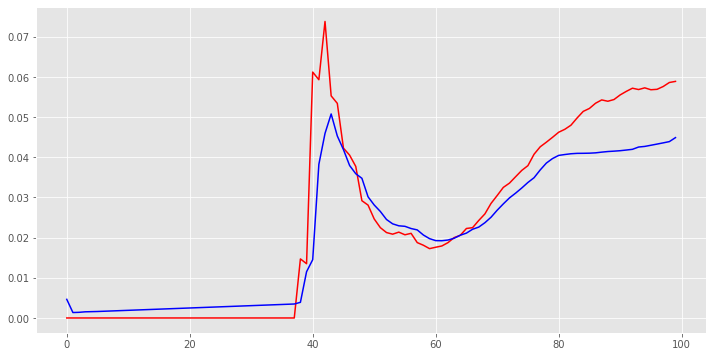

In [ ]:
ensemble_us = np.mean(np.array(df_us_100.loc[:, 'ConstantModel':'LinearRegressionModel'].values), axis = 1)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_us_100['Deaths/Confirmed'].iloc[:100].values, color = 'red')
ax.plot(np.arange(100), ensemble_us, color = 'blue')

Предсказания ансамбля выглядят лучше, чем предсказания отдельно взятых моделей, но все равно оставляют желать лучшего.

In [ ]:
X_train_ru = np.array(df_russia_100.loc[:, 'ConstantModel':'LinearRegressionModel'].values[:80, :])
X_test_ru = np.array(df_russia_100.loc[:, 'ConstantModel':'LinearRegressionModel'].values[80:100, :])

X_train_it = np.array(df_italy_100.loc[:, 'ConstantModel':'LinearRegressionModel'].values[:80, :])
X_test_it = np.array(df_italy_100.loc[:, 'ConstantModel':'LinearRegressionModel'].values[80:100, :])

X_train_us = np.array(df_us_100.loc[:, 'ConstantModel':'LinearRegressionModel'].values[:80, :])
X_test_us = np.array(df_us_100.loc[:, 'ConstantModel':'LinearRegressionModel'].values[80:100, :])

y_train_ru = df_russia_100['Deaths/Confirmed'].values[:80]
y_test_ru = df_russia_100['Deaths/Confirmed'].values[80:100]

y_train_it = df_italy_100['Deaths/Confirmed'].values[:80]
y_test_it = df_italy_100['Deaths/Confirmed'].values[80:100]

y_train_us = df_us_100['Deaths/Confirmed'].values[:80]
y_test_us = df_us_100['Deaths/Confirmed'].values[80:100]

In [ ]:
from sklearn.linear_model import LinearRegression

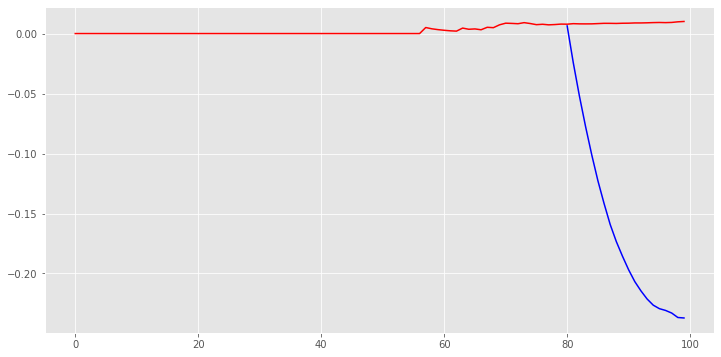

In [ ]:
stack_ru = LinearRegression().fit(X_train_ru, y_train_ru)
stack_ru_pred = stack_ru.predict(X_test_ru)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_russia_100['Deaths/Confirmed'].iloc[:100].values, color = 'red')
ax.plot(np.arange(80,100), list(stack_ru_pred), color = 'blue')

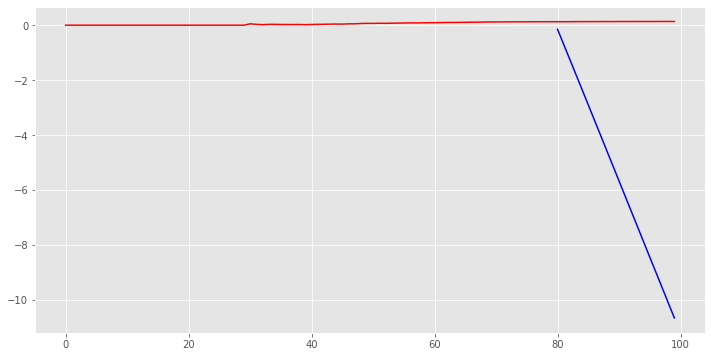

In [ ]:
stack_it = LinearRegression().fit(X_train_it, y_train_it)
stack_it_pred = stack_ru.predict(X_test_it)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_italy_100['Deaths/Confirmed'].iloc[:100].values, color = 'red')
ax.plot(np.arange(80,100), list(stack_it_pred), color = 'blue')

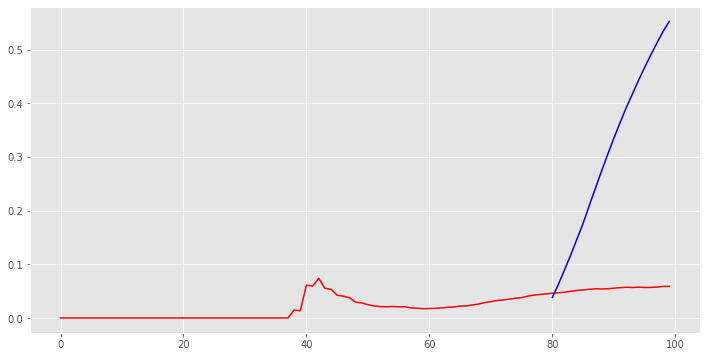

In [ ]:
stack_us = LinearRegression().fit(X_train_us, y_train_us)
stack_us_pred = stack_us.predict(X_test_us)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_us_100['Deaths/Confirmed'].iloc[:100].values, color = 'red')
ax.plot(np.arange(80,100), list(stack_us_pred), color = 'blue')

Простое усреднение оказалось лучше, чем построение линейной регрессии на этих прогнозах моделей.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

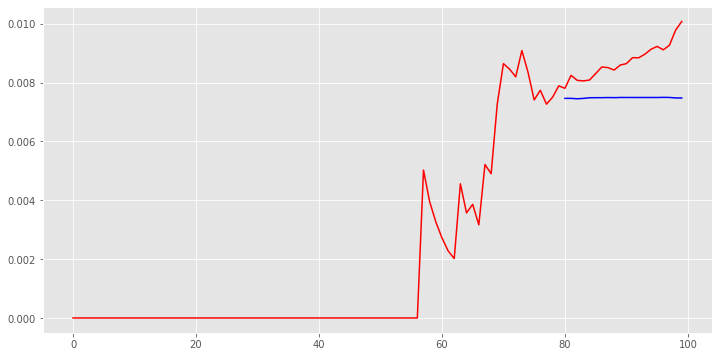

In [ ]:
RFR_ru = RandomForestRegressor(n_estimators = 300, max_depth=10, criterion='mse', random_state=0).fit(X_train_ru, y_train_ru)
RFR_ru_pred = RFR_ru.predict(X_test_ru)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_russia_100['Deaths/Confirmed'].iloc[:100].values, color = 'red')
ax.plot(np.arange(80,100), RFR_ru_pred, color = 'blue')

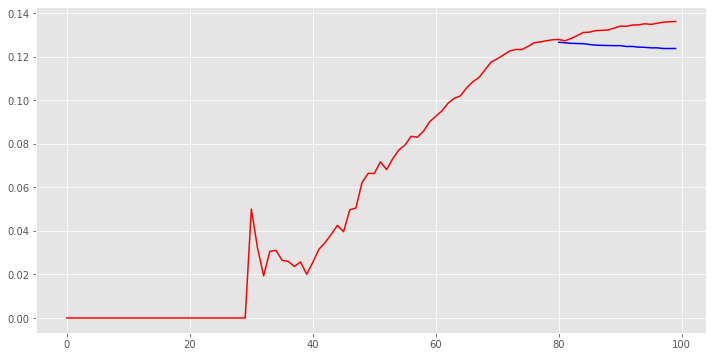

In [ ]:
RFR_it = RandomForestRegressor(n_estimators = 300, max_depth=30, min_samples_split=3, criterion='mse', random_state=0).fit(X_train_it, y_train_it)
RFR_it_pred = RFR_it.predict(X_test_it)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_italy_100['Deaths/Confirmed'].iloc[:100].values, color = 'red')
ax.plot(np.arange(80,100), RFR_it_pred, color = 'blue')

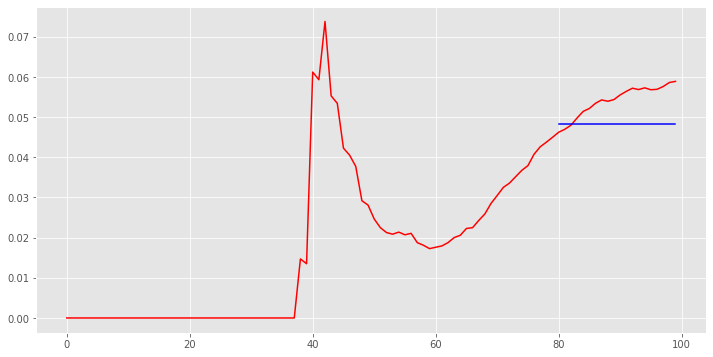

In [ ]:
RFR_us = RandomForestRegressor(n_estimators = 300, max_depth=10, min_samples_split=3, criterion='mse', random_state=0).fit(X_train_us, y_train_us)
RFR_us_pred = RFR_us.predict(X_test_it)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_us_100['Deaths/Confirmed'].iloc[:100].values, color = 'red')
ax.plot(np.arange(80,100), RFR_us_pred, color = 'blue')

Случайный лес на прогнозах алгоритмов работает чуть лучше, чем простое усреднение

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

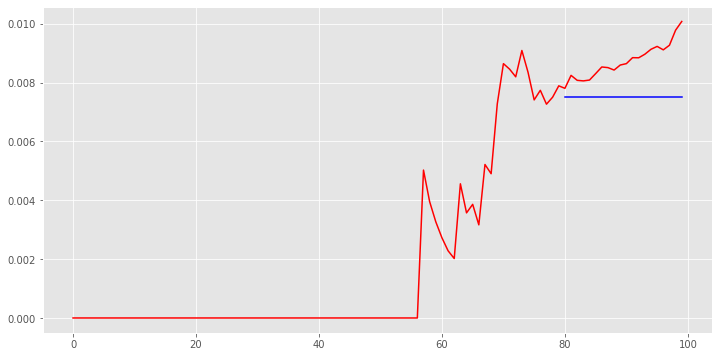

In [ ]:
GBR_ru = GradientBoostingRegressor(n_estimators = 500, max_depth=2, min_samples_split=2, criterion='mse', random_state=0).fit(X_train_ru, y_train_ru)
GBR_ru_pred = GBR_ru.predict(X_test_ru)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_russia_100['Deaths/Confirmed'].iloc[:100].values, color = 'red')
ax.plot(np.arange(80,100), GBR_ru_pred, color = 'blue')

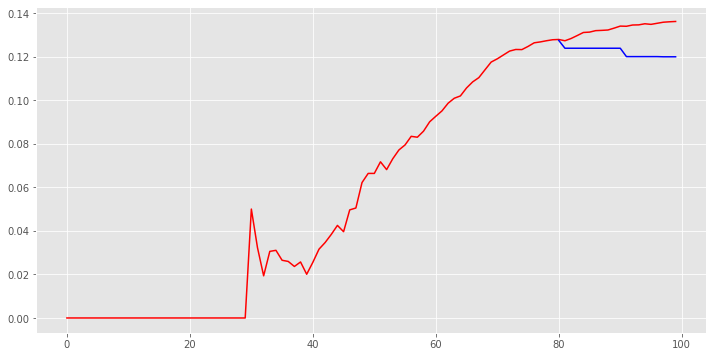

In [ ]:
GBR_it = GradientBoostingRegressor(n_estimators = 500, max_depth=2, min_samples_split=3, criterion='mse', random_state=0).fit(X_train_it, y_train_it)
GBR_it_pred = GBR_it.predict(X_test_it)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_italy_100['Deaths/Confirmed'].iloc[:100].values, color = 'red')
ax.plot(np.arange(80,100), GBR_it_pred, color = 'blue')

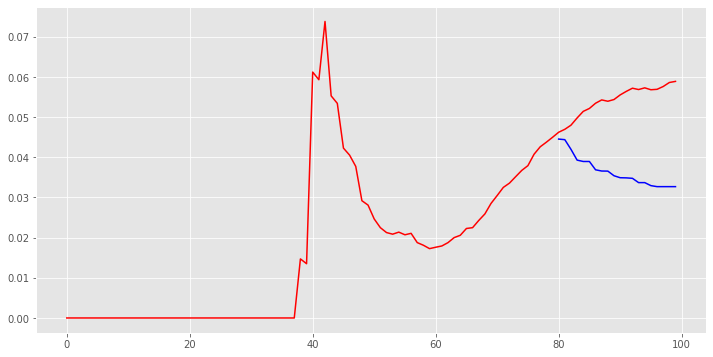

In [ ]:
GBR_us = GradientBoostingRegressor(n_estimators = 500, max_depth=2, min_samples_split=3, criterion='mse', random_state=0).fit(X_train_us, y_train_us)
GBR_us_pred = GBR_us.predict(X_test_us)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(100), df_us_100['Deaths/Confirmed'].iloc[:100].values, color = 'red')
ax.plot(np.arange(80,100), GBR_us_pred, color = 'blue')

Из регрессии, бустинга, случайного леса и усреднения прогнозов самыми лучшими оказалось усреднение прогнозов, особенно для Италии, но случайный лес не сильно ошибался. 
При этом у меня не было времени тюнить гиперпараметры и отбирать из моделей. Также есть возможность дообучить сами временные модели и исключить слабые по типу константной или неудачных AR

#### 2.11 Выводы

Метрика, которую надо спрогнозировать в большинстве случаев бедет иметь наибольшее свое значение в конце эпидемии. Она является аналогом летальности и занижает реальную летальность. При окончании эпидемии ее значение становится равно реальной летальности. Более подробно я писал об этом в 1 главе. ЭТи размышления приводят нас к тому, что ряды исходной метрики будут не стационарным (убедились в этом) и придется брать разности. Нам повезло и ряды разностей 1 порядка оказались стационарными для 3 стран, что не может не радовать. Этот ряд хоть как-то можно интерпретировать. Это прирост метрики в абсолютном выражении, измеряющийся в долях, так как метрика это доля. Как я уже сказал максимальное значение метрики будет с большей вероятностью в конце эпидемии и соответственно если ряд разностей первого порядка близко к нулю, то вероятнее всего пик эпидемии уже прошел или эпидемия только началась. Пик можно заметить по другим признакам, поэтому прогноз ряда разностей также полезен. Как я уже сказал исходные ряды не стационарные и модели на них работают не очень, но я оставлял плохие модели, так как, с моей точки зрения плохой прогноз исходной метрики лучше чем прогноз менее информативного ряда разностей первого порядка. Так как процесс эпидемии не имеет сезонной природы, то SARIMA модели также плохо работали.  

## Выводы по работе
В целом, все выводы написаны в самой работе. Работа и так большая смысл повторяться. Facebook не осилил.